Notebook descriptios:


# Required Imports

In [1]:
# import 
# Standard libraries
import os
import glob
import warnings
import gc

# Data manipulation and analysis libraries
import numpy as np
import pandas as pd
import dask.dataframe as dd
import dask.array as da
import xarray as xr
import geopandas as gpd
#from shapely.geometry import Point
from netCDF4 import Dataset
# geopandas 
import shapely

from shapely.geometry import Polygon, Point, box as shapely_box


#
import h3
# Dask diagnostics and progress bar
from dask.diagnostics import ProgressBar

# Plotting libraries
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm
from matplotlib.cm import ScalarMappable
from matplotlib.ticker import MultipleLocator, ScalarFormatter
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap, LogNorm
import cmocean
import colormaps as cmaps
#import cartopy.crs as ccrs
from pylag.processing.plot import FVCOMPlotter, create_figure, colourmap
from pylag.processing.plot import colourmap 
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from matplotlib.colorbar import ColorbarBase
from netCDF4 import Dataset

import warnings
warnings.filterwarnings("ignore", message="Measured.*not supported")

# Inputs

In [2]:
# Inputs
Streamwatershed_path = "/mnt/d/Users/abolmaal/Arcgis/NASAOceanProject/GIS_layer/Streamwatershed/PointWaterdhed_LH_NAD1983.shp"
# Define Core Directories
# -----------------------------
#GIS_LAYERS = '/home/abolmaal/Data/GIS_layer'  # For general GIS layers
Huron = '/mnt/d/Users/abolmaal/code/boundry/hydro_p_LakeHuron/hydro_p_LakeHuron.shp'
Lakes = '/mnt/d/Users/abolmaal/Arcgis/NASAOceanProject/GIS_layer/ne_10m_lakes/ne_10m_lakes.shp'
counties = '/mnt/hydroglg/Data/GIS_Data/Downloaded/Worldwide_Datasets/Natural_Earth_Data/10m_cultural/ne_10m_admin_0_countries_lakes.shp'
#NHDHRPLUS = '/mnt/d/Users/abolmaal/Arcgis/NASAOceanProject/GIS_layer/NHDHRPLUS/NetworkNHDFlowline_nati_Clip.shp'
NHDflowline = '/mnt/d/Users/abolmaal/Arcgis/NASAOceanProject/GIS_layer/NHDHRPLUS/NHDplusv1_Plus04_flowline.shp'

# read the shapefile for NHD flowlines
NHD_flowline = gpd.read_file(NHDflowline)
# initial position files
initial_position = '/mnt/d/Users/abolmaal/Arcgis/NASAOceanProject/GIS_layer/pourpoints/Streamwatershedpourpoints_NAD1983.shp'
# read the shapefile for inial positions
initial_positions = gpd.read_file(initial_position)
# read the shapefile for Lakes
Lakes = gpd.read_file(Lakes)
# read the shapefile for Counties
counties = gpd.read_file(counties)

#CW_path = '/mnt/d/Users/abolmaal/Arcgis/NASAOceanProject/GIS_layer/CoastalWatersheds/Erase_Riperian'  # Coastal wetlands (50m buffer)
# CW_path = '/mnt/d/Users/abolmaal/Arcgis/NASAOceanProject/GIS_layer/Coastalwetland/hitshoreline/'  # Alternative path (optional)
out_dir = '/home/abolmaal/modelling/FVCOM/Huron/TotalNP/2023/new'
# FVCOM grid metrics file
grid_metrics_file_name = '/home/abolmaal/modelling/FVCOM/Huron/input/gridfile/grid_metrics_huron_senseflux_Seasonal.nc'
# -----------------------------
# Coastal Wetland Shapefiles (Buffered 50m)
# -----------------------------
# CW_avg_path   = os.path.join(CW_path, 'Wetland_connected_avg_erasebuff_50.shp')
# CW_low_path   = os.path.join(CW_path, 'Wetland_connected_low_erasebuff_50.shp')
# CW_high_path  = os.path.join(CW_path, 'Wetland_connected_high_erasebuff_50.shp')
# CW_surge_path = os.path.join(CW_path, 'Wetland_connected_surge_erasebuff_50.shp')
#CW_path = '/mnt/d/Users/abolmaal/Arcgis/NASAOceanProject/GIS_layer/CoastalWatersheds/Buff_CW'
CW_path = '/mnt/d/Users/abolmaal/Arcgis/NASAOceanProject/GIS_layer/Coastalwetland/Removeoverlapstreamwatershed'

# -----------------------------
# Coastal Wetland Shapefiles (Buffered 50m)
# -----------------------------)
CW_avg_path   = os.path.join(CW_path, 'Wetland_connected_avg_inundation_NAD1983_shorelineinteraction_buffer2000m_noStreamOverlap.shp')
CW_low_path   = os.path.join(CW_path, 'Wetland_connected_low_inundation_NAD1983_shorelineinteraction_buffer2000m_noStreamOverlap.shp')
CW_high_path  = os.path.join(CW_path, 'Wetland_connected_high_inundation_NAD1983_shorelineinteraction_buffer2000m_noStreamOverlap.shp')
CW_surge_path = os.path.join(CW_path, 'Wetland_connected_surge_inundation_NAD1983_shorelineinteraction_buffer2000m_noStreamOverlap.shp')
# Load shapefiles as GeoDataFrames
CW_avg   = gpd.read_file(CW_avg_path)
CW_low   = gpd.read_file(CW_low_path)
CW_high  = gpd.read_file(CW_high_path)
CW_surge = gpd.read_file(CW_surge_path)
# FVCOM grid metrics file
grid_metrics_file_name = '/home/abolmaal/modelling/FVCOM/Huron/input/gridfile/grid_metrics_huron_senseflux_Seasonal.nc'

# -----------------------------
# Direct Nutrient Load (Stream Watersheds)
# -----------------------------
Direct_Nutrient_load = '/mnt/d/Users/abolmaal/Arcgis/NASAOceanProject/ZonalStats/DirectTNTP_StreamWatresheds.csv'
DirectStreamWatershed_NutrientLoad = pd.read_csv(Direct_Nutrient_load)

# InDirect Nutrient Load (Coastal Wetlands)
# -
categories = ['avg', 'high', 'low', 'surge']
# days_list = ["first1days", "first5days", "first10days",
#              "first26days", "first60days", "first90days"]
year = 23
# read the total loads
for cat in categories:
    total_load_file = os.path.join(out_dir, f'Total_Direct_Indirect_Loads_{cat}_{year}.csv')
    globals()[f'TotalLoad_CW_{cat}'] = pd.read_csv(total_load_file)


# saginaw_dir = os.path.join(out_dir, "Saginaw")
# for cat in categories:
#     total_load_file_saginaw = os.path.join(saginaw_dir, f'Total_Direct_Indirect_Loads_saginaw_{cat}_{year}.csv')
#     globals()[f'TotalLoad_CW_saginaw_{cat}'] = pd.read_csv(total_load_file_saginaw)

# Outpath

In [3]:
output_figures = '/home/abolmaal/modelling/FVCOM/Huron/Figures'

# Parameters

In [4]:
TARGET_CRS = "EPSG:3174"   # Great Lakes Albers

#release_times = ["2301", "2302", "2303", "2304", "2305", "2306", "2307", "2308", "2309", "2310", "2311", "2312"]
release_times = ["2401", "2402", "2403", "2404", "2405", "2406", "2407", "2408", "2409", "2410", "2411", "2412"]

# Figure parameters
blues = ['#f7fbff', '#deebf7', '#c6dbef', '#9ecae1',
         '#6baed6', '#4292c6', '#2171b5', '#084594']
# Create colormap
blue_shades = mcolors.LinearSegmentedColormap.from_list("blue_shades", blues)
# ✅ Correct way to reverse
blue_shades_reversed = blue_shades.reversed()

# Define a list of green shades for the colormap
greens =  ["#e5f9e0",  # very light mint
    "#a8f5a0",  # soft green
    "#70e070",  # medium green
    "#33cc33",  # strong bright green
    "#009933",  # forest green
    "#006622",  # dark green
    "#003311"]  # very dark green
# Create a custom green colormap
green_shades = LinearSegmentedColormap.from_list('custom_green', greens)

# Replace pink_cmap with viridis and plasma
viridis_cmap = plt.colormaps['viridis']  # Updated to use new interface
plasma_cmap = plt.colormaps['plasma']  # Updated to use new interface
reversed_plasma_cmap = plasma_cmap.reversed()  # Reversed colormap  

#define a colormap for nutrient loads
YlGnBu_cmap = ['#ffffcc','#c7e9b4','#7fcdbb','#41b6c4','#2c7fb8','#253494']
bounds = [4e1,6.2e1,1e2]
norm = mpl.colors.BoundaryNorm(bounds, len(YlGnBu_cmap),extend='both')

YlGnBu_colors =  mcolors.LinearSegmentedColormap.from_list('custom_hue', YlGnBu_cmap)


# Set up plotting parameters
font_size = 18
cmap = plt.colormaps['hsv_r']  # Fixed: using an existing colormap (hsv_r)
# figure sizes

double_size=(6.69, 5)
single_size=(3.35, 5)
# Extent of the plot
#extents = np.array([275, 277.69, 43, 46.3], dtype=float)

#extents_ausable = np.array([276.5, 276.8, 45, 45.5], dtype=float)

# main extent for lake huron
extent=[-84, -82.35, 42.65, 45.65]

# inset boxes that hit CW (EPSG:3174 meters); adjust as you like
inset_extents=[
    [1_070_000, 1_087_000, 930_000, 950_000],
    [1_040_000, 1_057_000, 776_000, 796_000],
    [1_145_000, 1_162_000, 768_000, 788_000]]

inset_fig_boxes=[[0.685,0.64,0.18,0.24],[0.685,0.37,0.18,0.24],[0.685,0.10,0.18,0.24]]

# Some parameters for the Zonal Stats Fields
# Fields to calculate / Direct delivery to Watersheds
# Fields to calculate / Direct delivery to Watersheds
StreamDirectTN = 'StreamDirectTN_kgday'
StreamDirectTP = 'StreamDirectTP_kgday'

# set figure sizes


# Helper Functions 

In [5]:

# ---------- helpers ----------
def _force_to_target(gdf_or_path, src_crs=None, name="layer", target_crs=TARGET_CRS):
    """Force a GeoDataFrame or file path to a target CRS.

    Args:
        gdf_or_path (_type_): _description_
        src_crs (_type_, optional): _description_. Defaults to None.
        name (str, optional): _description_. Defaults to "layer".
        target_crs (_type_, optional): _description_. Defaults to TARGET_CRS.

    Raises:
        ValueError: _description_

    Returns:
        _type_: _description_
    """
    if gdf_or_path is None:
        return None
    gdf = gdf_or_path.copy() if isinstance(gdf_or_path, gpd.GeoDataFrame) else gpd.read_file(gdf_or_path)
    if src_crs is not None:
        gdf = gdf.set_crs(src_crs, allow_override=True)
    elif gdf.crs is None:
        raise ValueError(f"{name}: source CRS is missing; pass {name}_src_crs='EPSG:XXXX'.")
    gdf = gdf[gdf.geometry.notna()].copy()
    try:
        gdf["geometry"] = gdf.geometry.make_valid()
    except Exception:
        gdf["geometry"] = gdf.geometry.buffer(0)
    try:
        gdf = gdf.explode(index_parts=False).reset_index(drop=True)
    except Exception:
        pass
    gdf = gdf[gdf.geometry.notna() & ~gdf.geometry.is_empty].copy()
    gdf_t = gdf.to_crs(target_crs)
    gdf_t = gdf_t[gdf_t.geometry.notna() & ~gdf_t.geometry.is_empty].copy()
    b = None if gdf_t.empty else gdf_t.total_bounds
    print(f"[{name} RAW] crs={gdf.crs} -> [{target_crs}] count={0 if gdf_t.empty else len(gdf_t)} bounds={b}")
    return gdf_t

def _project_extent_4326_to_target(extent_ll, target_crs=TARGET_CRS):
    """
    Convert a lon/lat bounding box (EPSG:4326) into the target projection.

    Args:
      extent_ll: [minlon, maxlon, minlat, maxlat] in degrees.
      target_crs: e.g. EPSG:3174 (Great Lakes Albers)

    Returns:
      [minx, maxx, miny, maxy] in target CRS units (meters).
    """
    minlon, maxlon, minlat, maxlat = extent_ll
    bbox_ll = gpd.GeoSeries([shapely_box(minlon, minlat, maxlon, maxlat)], crs="EPSG:4326")
    minx_p, miny_p, maxx_p, maxy_p = bbox_ll.to_crs(target_crs).total_bounds
    return [minx_p, maxx_p, miny_p, maxy_p]

def _clip_gdf_box(gdf, xmin, xmax, ymin, ymax):
    """
    Spatially clip a GeoDataFrame to a rectangular bounding box.

    Args:
      gdf: input GeoDataFrame
      xmin, xmax, ymin, ymax: box boundaries in the CRS of gdf

    Returns:
      GeoDataFrame with only features intersecting the box.
    """
    if gdf is None or gdf.empty:
        return gdf
    bbox = shapely_box(xmin, ymin, xmax, ymax)
    return gdf[gdf.intersects(bbox)]

def _colormap_from_any(cmap_or_name):
    """
    Accept either a Matplotlib colormap object or a string name.

    If string, looks up via matplotlib.colormaps.
    Ensures user can pass custom or built-in colormaps seamlessly.
    """
    import matplotlib
    if hasattr(cmap_or_name, "__call__") and hasattr(cmap_or_name, "name"):
        return cmap_or_name
    return matplotlib.colormaps.get_cmap(cmap_or_name)

def add_normal_colorbar(fig, ax_or_axes, cmap, norm, *,
                        label="", box=(0.90, 0.74, 0.02, 0.14),
                        ticks=None, tick_right=True, fontsize=14,
                        cbar_high_top=True):
    """
    Add a vertical colorbar to the figure.

    Args:
      fig: the parent Matplotlib figure
      ax_or_axes: one or more axes the cbar applies to
      cmap: colormap
      norm: normalization (e.g. LogNorm)
      label: colorbar label string
      box: [left, bottom, width, height] in fig coordinates
      ticks: optional fixed tick values
      tick_right: if True, draw ticks/labels on right side
      fontsize: label font size
      cbar_high_top: if True (default), higher values appear at the TOP

    Returns:
      The colorbar object.
    """
    if not isinstance(ax_or_axes, (list, tuple)):
        ax_or_axes = [ax_or_axes]
    cax = fig.add_axes(box)
    sm = ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])

    cb = fig.colorbar(sm, cax=cax, orientation="vertical")
    cb.set_label(label, fontsize=fontsize)

    if ticks is not None:
        # keep ticks in ascending order; axis inversion (if any) will handle the visual
        cb.set_ticks(ticks)
        if isinstance(norm, LogNorm):
            cb.set_ticklabels([f"{t:.1e}" for t in ticks])

    cb.ax.tick_params(labelsize=fontsize-2)

    if tick_right:
        cb.ax.yaxis.set_label_position("right")
        cb.ax.yaxis.tick_right()

    # Control which side shows higher values
    if not cbar_high_top:
        cb.ax.invert_yaxis()
    return cb

# ticks helpers (still here in case you turn them on later)
def _apply_ticks(ax, minx, maxx, miny, maxy, interval_m=20000, fontsize=12, show=False):
    """
    Apply axis ticks for maps.

    Args:
      ax: the axes to update
      minx, maxx, miny, maxy: limits in meters
      interval_m: tick spacing in meters
      fontsize: label font size
      show: if False, hides ticks/labels (clean figure)

    Returns:
      None (modifies ax in place).
    """
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)
    if not show:
        ax.set_xticks([]); ax.set_yticks([])
        return
    ax.xaxis.set_major_locator(MultipleLocator(interval_m))
    ax.yaxis.set_major_locator(MultipleLocator(interval_m))
    fmt = ScalarFormatter(useMathText=True); fmt.set_powerlimits((-3, 4))
    ax.xaxis.set_major_formatter(fmt); ax.yaxis.set_major_formatter(fmt)
    ax.tick_params(axis='both', which='major', labelsize=fontsize)

# center+size helper for insets
def box_from_center(cx, cy, width_m, height_m):
    """
    Create a bounding box from a center coordinate and dimensions.

    Args:
      cx, cy: center in target CRS
      width_m, height_m: dimensions in meters

    Returns:
      [xmin, xmax, ymin, ymax] box list
    """
    half_w, half_h = width_m/2, height_m/2
    return [cx - half_w, cx + half_w, cy - half_h, cy + half_h]

# inset helpers
def _auto_insets_from_layer(layer_gdf, k=2, buffer_m=3500):
    """
    Auto-generate inset boxes from the largest features in a layer.

    Args:
      layer_gdf: input GeoDataFrame
      k: number of insets to generate
      buffer_m: extra margin in meters around each feature

    Returns:
      List of bounding boxes [xmin, xmax, ymin, ymax] in target CRS
    """
    out = []
    if layer_gdf is None or layer_gdf.empty: return out
    g = layer_gdf.copy()
    if g.geom_type.isin(["Polygon","MultiPolygon"]).any():
        g["area_or_len"] = g.geometry.area
    else:
        g["area_or_len"] = g.geometry.length
    g = g.sort_values("area_or_len", ascending=False)
    for geom in g.geometry.head(k):
        xmin, ymin, xmax, ymax = geom.buffer(buffer_m).bounds
        out.append([xmin, xmax, ymin, ymax])
    return out

def _box_hits(gdf, b):
    """
    Check whether a GeoDataFrame has features inside a box.

    Args:
      gdf: GeoDataFrame
      b: [xmin, xmax, ymin, ymax] box

    Returns:
      True if non-empty intersection, False otherwise
    """
    if gdf is None or gdf.empty: return False
    x0,x1,y0,y1 = b
    return not _clip_gdf_box(gdf, x0,x1,y0,y1).empty

# Adjust CRS 

In [6]:
watershed_gdf = gpd.read_file(Streamwatershed_path)

# Reproject if needed
if watershed_gdf.crs != "EPSG:4326":
    watershed_gdf = watershed_gdf.to_crs("EPSG:3172")
    
# set initial positions crs to 3174
initial_positions = _force_to_target(initial_positions, target_crs="EPSG:3174")

[layer RAW] crs=EPSG:3174 -> [EPSG:3174] count=80 bounds=[ 983589.29560957  718976.42850433 1164799.31201039 1019651.24474242]


In [7]:
counties_gdf = _force_to_target(counties, target_crs="EPSG:3174", name="counties")

[counties RAW] crs=EPSG:4326 -> [EPSG:3174] count=4360 bounds=[-14305552.61735841  -8042233.99836776  16305606.43433335
  16739875.79434085]


In [8]:
#print Lakes.crs
Lakes = _force_to_target(Lakes, target_crs="EPSG:3174", name="Lakes")

[Lakes RAW] crs=EPSG:4326 -> [EPSG:3174] count=1366 bounds=[-13058875.18186331  -7022795.60638082  14464699.12086754
  13589634.4328059 ]


In [9]:
print(Lakes.crs)

EPSG:3174


# Plot Functions

In [ ]:
from urllib.request import urlopen
import json
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)

In [ ]:
import os
import geopandas as gpd
import numpy as np
import h3
import plotly.express as px
import plotly.graph_objects as go
from shapely.geometry import Polygon

def plot_wetload_choropleth_interactive(
    df, 
    category,
    resolution=6,
    map_extent=None,
    watershed_shapefile_path=None,
    lakes_shapefile_path=None,
    counties_shapefile_path=None,
    output_figures="outputs"
):
    """
    Create an interactive hexbin choropleth map of nutrient loads.
    - df: DataFrame containing TotalN_{category}_grm2yr, start_lat, start_lon.
    - category: 'avg', 'low', 'high', or 'surge'.
    - resolution: H3 hex resolution.
    - map_extent: (lon_min, lon_max, lat_min, lat_max) or None.
    - watershed_shapefile_path: path or GeoDataFrame for watershed overlay.
    - lakes_shapefile_path: path to Great Lakes shapefile.
    - counties_shapefile_path: path to counties shapefile.
    """
    # Create GeoDataFrame from coordinates
    gdf = gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df['start_lon'], df['start_lat']),
        crs='EPSG:4326'
    )

    # Assign H3 index and aggregate
    gdf['h3_index'] = gdf.geometry.apply(lambda p: h3.latlng_to_cell(p.y, p.x, resolution))
    agg_df = gdf.groupby('h3_index')[f'TotalN_{category}_grm2yr'].sum().reset_index()

    # Convert hex indexes to polygons
    agg_df['geometry'] = agg_df['h3_index'].apply(
        lambda cell: Polygon([(lon, lat) for lat, lon in h3.cell_to_boundary(cell)])
    )
    agg_df['log_load'] = np.log10(agg_df[f'TotalN_{category}_grm2yr'] + 1e-6)
    hex_gdf = gpd.GeoDataFrame(agg_df, geometry='geometry', crs='EPSG:4326')
    hex_gdf['id'] = hex_gdf.index.astype(str)
    geojson_data = hex_gdf.__geo_interface__

    # Map extent
    if map_extent:
        lon_min, lon_max, lat_min, lat_max = map_extent
        center_lon = (lon_min + lon_max) / 2
        center_lat = (lat_min + lat_max) / 2
        zoom = 6
    else:
        center_lon, center_lat, zoom = -82.5, 44.5, 6

    # Create base choropleth
    fig = px.choropleth_map(
        hex_gdf,
        geojson=geojson_data,
        locations='id',
        color='log_load',
        zoom=zoom,
        center={"lat": center_lat, "lon": center_lon},
        opacity=0.7,
        map_style="carto-positron",
        color_continuous_scale="rainbow",
        labels={"log_load": f"Log₁₀(Total N {category} g/m²/yr)"}
    )

    # Optional watershed overlay
    if watershed_shapefile_path is not None:
        if isinstance(watershed_shapefile_path, gpd.GeoDataFrame):
            watershed_gdf = watershed_shapefile_path
        else:
            watershed_gdf = gpd.read_file(watershed_shapefile_path)
        if watershed_gdf.crs != "EPSG:4326":
            watershed_gdf = watershed_gdf.to_crs("EPSG:4326")
        for _, row in watershed_gdf.iterrows():
            if row.geometry is None:
                continue
            for geom in ([row.geometry] if row.geometry.geom_type != 'MultiPolygon' else row.geometry.geoms):
                if geom.geom_type == 'Polygon':
                    lons, lats = zip(*list(geom.exterior.coords))
                    fig.add_trace(go.Scattermap(lon=lons, lat=lats, mode='lines',
                                                line=dict(width=1, color='green'),
                                                name='Watershed'))

    # Optional lakes overlay
    if lakes_shapefile_path is not None:
        if isinstance(lakes_shapefile_path, gpd.GeoDataFrame):
            lakes_gdf = lakes_shapefile_path
        elif isinstance(lakes_shapefile_path, str) and os.path.exists(lakes_shapefile_path):
            lakes_gdf = gpd.read_file(lakes_shapefile_path)
        else:
            lakes_gdf = None

        if lakes_gdf is not None:
            if lakes_gdf.crs != "EPSG:4326":
                lakes_gdf = lakes_gdf.to_crs("EPSG:4326")
            for _, row in lakes_gdf.iterrows():
                if row.geometry is None:
                    continue
                for geom in ([row.geometry] if row.geometry.geom_type != 'MultiPolygon' else row.geometry.geoms):
                    if geom.geom_type == 'Polygon':
                        lons, lats = zip(*list(geom.exterior.coords))
                        fig.add_trace(go.Scattermap(
                            lon=lons, lat=lats, mode='lines',
                            line=dict(width=1.5, color='blue'),
                            name='Great Lakes'
                        ))

    # # Optional counties overlay
    # if counties_shapefile_path is not None:
    #     if isinstance(counties_shapefile_path, gpd.GeoDataFrame):
    #         counties_gdf = counties_shapefile_path
    #     elif isinstance(counties_shapefile_path, str) and os.path.exists(counties_shapefile_path):
    #         counties_gdf = gpd.read_file(counties_shapefile_path)
    #     else:
    #         counties_gdf = None  # unsupported type or missing path

    #     if counties_gdf is not None and not counties_gdf.empty:
    #         if counties_gdf.crs != "EPSG:4326":
    #             counties_gdf = counties_gdf.to_crs("EPSG:4326")

    #         for geom in counties_gdf.geometry:
    #             if geom is None:
    #                 continue
    #             geoms = [geom] if geom.geom_type != "MultiPolygon" else geom.geoms
    #             for g in geoms:
    #                 if g.geom_type == "Polygon":
    #                     lons, lats = zip(*list(g.exterior.coords))
    #                     # If you're using Mapbox, Scattermapbox is the correct trace type:
    #                     fig.add_trace(go.Scattermapbox(
    #                         lon=lons, lat=lats, mode='lines',
    #                         line=dict(width=0.8),
    #                         name='County'
    #                     ))

    # Layout
    fig.update_layout(
       #title=f"Log-Scaled Indirect Nitrogen Load ({category}) with Overlays",
        mapbox_style="carto-positron",
        mapbox_zoom=zoom,
        mapbox_center={"lat": center_lat, "lon": center_lon},
        margin={"r": 0, "t": 40, "l": 0, "b": 0}
    )

    os.makedirs(output_figures, exist_ok=True)
    #fig.write_html(os.path.join(output_figures, f"WetLoad_Choropleth_{category}.html"))
    fig.write_image(os.path.join(output_figures, f"WetLoad_Choropleth_{category}.jpeg"), format="jpeg", scale=2)
    fig.show()


In [ ]:
# categories = ['avg', 'high', 'low', 'surge']

# for cat in categories:
#     df = globals()[f"TotalLoad_CW_{cat}"]
#     plot_wetload_choropleth_interactive(
#         df = df,
#         category=cat,
#         resolution=6,
#         watershed_shapefile_path=Streamwatershed_path,
#         lakes_shapefile_path=Lakes,
#         counties_shapefile_path=counties,
#         output_figures=out_dir
#     )


# Plot Study area

In [11]:
import os
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box
from shapely.ops import unary_union as _uun

# ---------- helpers ----------
def _force_to_target(src, src_crs=None, name="layer", target_crs="EPSG:3174"):
    """
    src can be a GeoDataFrame or a path to a vector file.
    src_crs is used only if src has no CRS set.
    Always returns a GeoDataFrame in target_crs (or None).
    """
    if src is None:
        return None
    if isinstance(src, str):
        g = gpd.read_file(src)
    else:
        g = src.copy()
    if g is None or g.empty:
        return None
    if g.crs is None:
        if not src_crs:
            raise ValueError(f"{name}: CRS is None and src_crs not provided")
        g = g.set_crs(src_crs)
    if str(g.crs) != str(target_crs):
        g = g.to_crs(target_crs)
    return g

def _clip_gdf_box(g, xmin, xmax, ymin, ymax):
    """Clip GeoDataFrame to a rectangular bbox in the SAME CRS as g."""
    if g is None or g.empty:
        return g
    bb = box(xmin, ymin, xmax, ymax)
    try:
        out = g.clip(bb)
    except Exception:
        out = g[g.geometry.intersects(bb)].copy()
        out["geometry"] = out.geometry.intersection(bb)
    # Clean invalids
    out = out[~out.geometry.is_empty & out.geometry.notnull()].copy()
    return out

def _apply_ticks(ax, xmin, xmax, ymin, ymax, interval_m=20000, fontsize=10, show=False):
    """Simple tick helper in projected meters CRS."""
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    if not show:
        ax.set_xticks([]); ax.set_yticks([])
        ax.set_xlabel(""); ax.set_ylabel("")
        return
    # grid every interval_m
    def _mk_ticks(a, b, step):
        start = np.ceil(a/step)*step
        return np.arange(start, b + 0.5*step, step)
    xt = _mk_ticks(xmin, xmax, interval_m)
    yt = _mk_ticks(ymin, ymax, interval_m)
    ax.set_xticks(xt); ax.set_yticks(yt)
    ax.tick_params(labelsize=fontsize)

def _auto_insets_from_layer(g, k=2, buffer_m=3500):
    """
    Pick up to k windows around geometries in g (largest bounds first).
    Returns list of [xmin,xmax,ymin,ymax] in g.crs.
    """
    if g is None or g.empty:
        return []
    windows = []
    for geom in g.geometry:
        if geom is None or geom.is_empty:
            continue
        minx, miny, maxx, maxy = geom.bounds
        # pad
        minx -= buffer_m; miny -= buffer_m; maxx += buffer_m; maxy += buffer_m
        windows.append([minx, maxx, miny, maxy])
    # sort by area desc
    windows = sorted(windows, key=lambda w: (w[1]-w[0])*(w[3]-w[2]), reverse=True)
    return windows[:k]

def _project_extent_4326_to_target(extent_ll, target_crs="EPSG:3174"):
    """
    extent_ll = [minlon, maxlon, minlat, maxlat] in EPSG:4326
    returns (minx, maxx, miny, maxy) in target_crs
    """
    minlon, maxlon, minlat, maxlat = extent_ll
    g = gpd.GeoDataFrame(geometry=[box(minlon, minlat, maxlon, maxlat)], crs="EPSG:4326")
    bx_minx, bx_miny, bx_maxx, bx_maxy = g.to_crs(target_crs).total_bounds
    return bx_minx, bx_maxx, bx_miny, bx_maxy

# ---------- main plotting ----------
def plot_study_area_single(
    # layers (path or GeoDataFrame)
    Counties=None,
    Lake=None,               # lake polygon(s)
    CW_layers=None,          # dict {"avg": path/gdf, ...} or single path/GDF
    NHD_flowline=None,       # lines
    Watershed=None,          # polys

    # CRS info
    counties_src_crs=None,
    lake_src_crs=None,
    cw_src_crs=None,
    nhd_src_crs=None,
    watershed_src_crs=None,
    target_crs="EPSG:3174",  # <- set your map CRS here

    # which CW to show if CW_layers is a dict
    cw_key_for_display="avg",

    # view & style
    extent=[-85, -82.40, 42.65, 45.75],  # lon/lat box
    auto_expand_extent=True,
    extent_padding_m=5000,
    font_size=14,
    fig_size=double_size,
    output_figures=".",
    file_stub="StudyArea",

    # ticks
    show_ticks=False,
    tick_interval_m=20000,

    # NHD visibility + style
    show_nhd_on_main=True,
    show_nhd_on_insets=True,
    nhd_color="#3182bd",
    nhd_linewidth_min=0.15,
    nhd_linewidth_step=0.20,
    nhd_alpha=0.95,

    # CW outline style + enlargement
    cw_color="#1b7837",
    cw_line_width=1,
    cw_halo_width=2.0,
    enlarge_m=0,   # e.g., 600 to visually enlarge wetlands and clip to lake

    # layout: where to put the main axes (figure coords)
    main_axes_rect=(0.06, 0.10, 0.78, 0.85),

    # insets
    inset_fig_boxes=None,     # list of [left,bottom,width,height] in figure coords (can be >1 to sit outside)
    inset_extents=None,       # list of [xmin,xmax,ymin,ymax] in target CRS
    locator_lw=2.2,
    inset_spine_lw=2.0,
):
    # ---------- 1) Read/transform layers ----------
    counties_t  = _force_to_target(Counties,  src_crs=counties_src_crs,  name="Counties",  target_crs=target_crs) if Counties   is not None else None
    lake_t      = _force_to_target(Lake,      src_crs=lake_src_crs,      name="Lake",      target_crs=target_crs) if Lake       is not None else None
    watershed_t = _force_to_target(Watershed, src_crs=watershed_src_crs, name="Watershed", target_crs=target_crs) if Watershed  is not None else None

    cw_t = None
    if CW_layers is not None:
        src = CW_layers.get(cw_key_for_display, None) if isinstance(CW_layers, dict) else CW_layers
        if src is not None:
            cw_t = _force_to_target(src, src_crs=cw_src_crs, name=f"CW[{cw_key_for_display}]", target_crs=target_crs)

    nhd_t = _force_to_target(NHD_flowline, src_crs=nhd_src_crs, name="NHD", target_crs=target_crs) if NHD_flowline is not None else None

    # ---------- 2) Compute extent in TARGET_CRS ----------
    minx, maxx, miny, maxy = _project_extent_4326_to_target(extent, target_crs=target_crs)
    if auto_expand_extent:
        boxes = []
        for layer in (lake_t, cw_t, watershed_t):
            if layer is not None and not layer.empty:
                boxes.append(layer.total_bounds)
        if boxes:
            L = np.vstack(boxes)
            lxmin, lymin = np.nanmin(L[:,0]), np.nanmin(L[:,1])
            lxmax, lymax = np.nanmax(L[:,2]), np.nanmax(L[:,3])
            pad = extent_padding_m
            minx = min(minx, lxmin - pad); maxx = max(maxx, lxmax + pad)
            miny = min(miny, lymin - pad); maxy = max(maxy, lymax + pad)

    # ---------- 3) Clip to main view ----------
    def _clip(g): return _clip_gdf_box(g, minx, maxx, miny, maxy) if g is not None else None
    counties_t   = _clip(counties_t)
    lake_t       = _clip(lake_t)
    watershed_t  = _clip(watershed_t)
    cw_t         = _clip(cw_t)
    nhd_t_main   = _clip(nhd_t)

    # ---------- 4) Figure & main axes ----------
    fig = plt.figure(figsize=fig_size)
    ax  = fig.add_axes(main_axes_rect)

    # Colors
    COUNTY_FACE     = "#d4d9e0"
    LAKE_FACE       = "#bcd7ff"
    LAKE_EDGE       = "#5b7aa6"
    WATERSHED_EDGE  = "#131312"
    WATERSHED_FILL  = (0.1, 0.1, 0.1, 0.06)  # very light gray fill

    # Draw order: counties -> lake -> watershed -> NHD -> CW
    if counties_t is not None and not counties_t.empty:
        counties_t.plot(ax=ax, facecolor=COUNTY_FACE, edgecolor="black",
                        linewidth=0.5, zorder=0.5)

    if lake_t is not None and not lake_t.empty:
        lake_t.plot(ax=ax, facecolor=LAKE_FACE, edgecolor=LAKE_EDGE,
                    linewidth=0.8, zorder=0.6)

    if watershed_t is not None and not watershed_t.empty:
        watershed_t.plot(ax=ax, facecolor=WATERSHED_FILL, edgecolor=WATERSHED_EDGE,
                         linewidth=0.8, zorder=1.0)

    if show_nhd_on_main and nhd_t_main is not None and not nhd_t_main.empty:
        # Stream order width if available
        so_col = None
        for c in ["StreamOrde", "StreamOrder", "StOrd", "Strahler", "StO", "StO_", "order"]:
            if c in nhd_t_main.columns:
                so_col = c; break
        if so_col is None:
            nhd_t_main.plot(ax=ax, color=nhd_color,
                            linewidth=nhd_linewidth_min + nhd_linewidth_step,
                            alpha=nhd_alpha, zorder=1.2)
        else:
            for so, sub in nhd_t_main.groupby(so_col):
                try:
                    so_f = float(so)
                except Exception:
                    so_f = 0.0
                lw = nhd_linewidth_min + nhd_linewidth_step * max(0.0, so_f - 1.0)
                sub.plot(ax=ax, color=nhd_color, linewidth=lw, alpha=nhd_alpha, zorder=1.2 + 0.01*lw)

    # CW outline (with subtle halo)
    if cw_t is not None and not cw_t.empty:
        cw_t.plot(ax=ax, facecolor="none", edgecolor="white", linewidth=cw_halo_width, alpha=0.95, zorder=6.0)
        cw_t.plot(ax=ax, facecolor="none", edgecolor=cw_color,  linewidth=cw_line_width, alpha=1.0,  zorder=6.1)

    # View & ticks
    ax.set_aspect("equal"); ax.autoscale(False)
    _apply_ticks(ax, minx, maxx, miny, maxy,
                 interval_m=tick_interval_m,
                 fontsize=font_size-2,
                 show=show_ticks)
    
    # ---------- 5) Insets ----------
    # Choose windows if not provided
    if inset_extents is None:
        inset_extents = (_auto_insets_from_layer(cw_t, k=2, buffer_m=3500)
                         or _auto_insets_from_layer(lake_t, k=2, buffer_m=3500)
                         or _auto_insets_from_layer(nhd_t_main, k=2, buffer_m=3500)
                         or [])

    # Default inset placements (outside to the right) if not provided
    if inset_fig_boxes is None:
        inset_fig_boxes = [
            [0.86, 0.58, 0.12, 0.32],  # right column, upper (outside main_axes_rect)
            [0.86, 0.16, 0.12, 0.32],  # right column, lower
        ]
    if len(inset_fig_boxes) < len(inset_extents):
        inset_fig_boxes = inset_fig_boxes + [inset_fig_boxes[-1]]*(len(inset_extents) - len(inset_fig_boxes))

    locator_colors = ["tab:red", "tab:blue", "tab:purple", "tab:orange"][:len(inset_extents)]

    # Precompute lake union for clipping enlarged CW inside insets
    lake_union_geom = None
    if lake_t is not None and not lake_t.empty:
        try:
            lake_union_geom = lake_t.union_all()
        except Exception:
            lake_union_geom = _uun(lake_t.geometry)

    for (xmin_i, xmax_i, ymin_i, ymax_i), fig_box, loc_color in zip(inset_extents, inset_fig_boxes, locator_colors):
        # skip windows completely outside main view
        if (xmax_i < minx) or (xmin_i > maxx) or (ymax_i < miny) or (ymin_i > maxy):
            continue

        # locator on main
        ax.add_patch(
            plt.Polygon(
                [[xmin_i, ymin_i], [xmax_i, ymin_i], [xmax_i, ymax_i], [xmin_i, ymax_i]],
                closed=True, fill=False, ec=loc_color, lw=locator_lw, zorder=7
            )
        )

        # build inset axis in figure coords (these can be >1.0 to sit outside)
        ax_zoom = fig.add_axes(fig_box)
        for s in ax_zoom.spines.values():
            s.set_edgecolor(loc_color); s.set_linewidth(inset_spine_lw)

        # clip layers to inset window
        sub_cnty = _clip_gdf_box(counties_t,  xmin_i, xmax_i, ymin_i, ymax_i) if (counties_t  is not None) else None
        sub_lake = _clip_gdf_box(lake_t,      xmin_i, xmax_i, ymin_i, ymax_i) if (lake_t      is not None) else None
        sub_cw   = _clip_gdf_box(cw_t,        xmin_i, xmax_i, ymin_i, ymax_i) if (cw_t        is not None) else None
        sub_nhd  = _clip_gdf_box(nhd_t_main,  xmin_i, xmax_i, ymin_i, ymax_i) if (show_nhd_on_insets and nhd_t_main is not None) else None

        # draw order: counties -> lake -> NHD -> CW (top)
        if sub_cnty is not None and not sub_cnty.empty:
            sub_cnty.plot(ax=ax_zoom, facecolor="#c0c8d2", edgecolor="black", linewidth=0.5, zorder=0.5)
        if sub_lake is not None and not sub_lake.empty:
            sub_lake.plot(ax=ax_zoom, facecolor="#bcd7ff", edgecolor="#5b7aa6", linewidth=0.6, zorder=0.6)

        if sub_nhd is not None and not sub_nhd.empty:
            so_col = None
            for c in ["StreamOrde", "StreamOrder", "StOrd", "Strahler", "StO", "StO_", "order"]:
                if c in sub_nhd.columns:
                    so_col = c; break
            if so_col is None:
                sub_nhd.plot(ax=ax_zoom, color=nhd_color,
                             linewidth=nhd_linewidth_min + nhd_linewidth_step,
                             alpha=nhd_alpha, zorder=1.2)
            else:
                for so, s in sub_nhd.groupby(so_col):
                    try:
                        so_f = float(so)
                    except Exception:
                        so_f = 0.0
                    lw = nhd_linewidth_min + nhd_linewidth_step * max(0.0, so_f - 1.0)
                    s.plot(ax=ax_zoom, color=nhd_color, linewidth=lw, alpha=nhd_alpha, zorder=1.2 + 0.01*lw)

        # CW enlargement & clipping to lake for crisp “coastal wetland” look
        if sub_cw is not None and not sub_cw.empty:
            cw_draw = sub_cw.copy()
            if enlarge_m and enlarge_m > 0:
                cw_draw["geometry"] = cw_draw.buffer(enlarge_m, join_style=2).buffer(0)
            if lake_union_geom is not None:
                try:
                    cw_draw["geometry"] = cw_draw.geometry.intersection(lake_union_geom).buffer(0)
                except Exception:
                    pass
            # halo + outline
            cw_draw.boundary.plot(ax=ax_zoom, color="white", linewidth=max(0.8, 0.5*inset_spine_lw), zorder=2.75)
            cw_draw.boundary.plot(ax=ax_zoom, color=cw_color,  linewidth=max(0.8, 0.4*inset_spine_lw), zorder=2.8)

        # lock inset view + ticks
        ax_zoom.set_xlim(xmin_i, xmax_i)
        ax_zoom.set_ylim(ymin_i, ymax_i)
        ax_zoom.set_aspect("equal")
        _apply_ticks(ax_zoom, xmin_i, xmax_i, ymin_i, ymax_i,
                     interval_m=5000,
                     fontsize=max(6, font_size-4),
                     show=False)

    # ---------- 6) Save ----------
    os.makedirs(output_figures, exist_ok=True)
    outpath = os.path.join(output_figures, f"{file_stub}.jpeg")
    plt.savefig(outpath, dpi=300, bbox_inches="tight")
    print(f"✅ Saved: {outpath}")
    plt.show()

✅ Saved: /home/abolmaal/modelling/FVCOM/Huron/Figures/StudyArea.jpeg


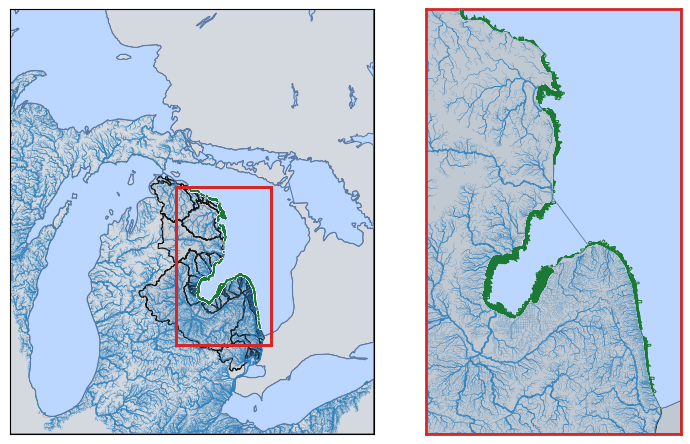

In [12]:
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)

plot_study_area_single(
    Lake=Lakes, 
    lake_src_crs="EPSG:3174",
    Counties=counties, counties_src_crs="EPSG:4326",
    CW_layers={"avg": CW_avg}, cw_src_crs="EPSG:3174", cw_key_for_display="avg",
    NHD_flowline=NHD_flowline, nhd_src_crs="EPSG:4269",
    Watershed=Streamwatershed_path, watershed_src_crs="EPSG:3174",
    extent=[-88.2, -80.0, 41.30, 48.5],
    auto_expand_extent=False,
    show_nhd_on_main=True, show_nhd_on_insets=True,
    enlarge_m=800,
    # shrink main map to leave a right margin (optional)
    main_axes_rect=(0.06, 0.10, 0.78, 0.85),

    # two small insets OUTSIDE the map (figure coords)
    # inset_fig_boxes=[
    #     [0.80, 0.20, 0.20, 1],
    #     # [0.70, 0.60, 0.15, 0.33],
    #     # [0.70, 0.37, 0.15, 0.33],
    #     # [0.70, 0.17, 0.15, 0.33]
        
    # ],
    inset_fig_boxes = [
    [0.60, 0.100, 0.78, 0.85]  # -> [0.86, 0.10, 0.14, 0.85]
],
    # give two specific inset windows (in TARGET_CRS meters)
    inset_extents=[
        [1_000_000,1_180_000,700_000,1_000_000],
        #[1_060_000, 1_110_000, 890_000, 970_000],
        #[1_020_000, 1_070_000, 760_000, 835_000],
        #[1_130_000, 1_190_000, 790_000, 840_000],
    ],

    output_figures=output_figures
)


## plot with zoom in extents

## Plot(Direct, Indirect, Indirect/Indirect) 

In [ ]:
def plot_wetload_distribution_h3_tripanel(
    cat,
    # layers (path or GeoDataFrame)
    Counties=None,
    Lake=None,                 # lake polygon(s) instead of FVCOM nodes
    CW_layers=None,
    NHD_flowline=None,

    # TRUE source CRS
    counties_src_crs=None,
    lake_src_crs=None,
    cw_src_crs=None,
    nhd_src_crs=None,

    # general
    font_size=18,
    resolution=8,
    output_figures=".",
    extent=[-84, -82.35, 42.65, 45.65],   # lon/lat
    auto_expand_extent=False,
    extent_padding_m=5000,

    # insets
    inset_extents=None,                   # [[xmin,xmax,ymin,ymax], ...] in TARGET_CRS
    inset_fig_boxes=None,                 # [[left,bottom,width,height], ...] in fig coords
    show_inset_ticks=False,
    inset_tick_interval_m=5000,

    # ticks
    show_main_ticks=False,
    main_tick_interval_m=20000,

    # NHD visibility
    show_nhd_on_main=False,
    show_nhd_on_insets=True,

    # colors / colorbars
    load_cmap="magma",
    ratio_cmap="magma",
    cbar_box_load=(0.87, 0.64, 0.02, 0.16),   # N-load colorbar (for Direct + Indirect)
    cbar_box_ratio=(0.95, 0.64, 0.02, 0.16),  # Indirect/Direct colorbar (right panel)
):
    """
    Tripanel:
      - Left:  Direct TN (hex)
      - Middle: Indirect TN (hex) [no CW overlay]
      - Right: Indirect / Direct (hex)
    Background: Lake polygons (no FVCOM points).
    Insets: CW polygons only, filled by Indirect TN color (same cmap/norm as N-load).
    """

    # -------------------------------
    # Helpers
    # -------------------------------
    def _cw_colored_by_hex(cw_gdf, hex_gdf):
        """Return CW polygons with a 'load' column from overlapping hexes (median)."""
        if cw_gdf is None or hex_gdf is None:
            return None
        if cw_gdf.empty or hex_gdf.empty:
            out = cw_gdf.copy(); out["load"] = np.nan; return out
        cw_tmp = cw_gdf[["geometry"]].copy().reset_index().rename(columns={"index": "_cw_idx"})
        sj = gpd.sjoin(cw_tmp, hex_gdf[["geometry","load"]], how="left", predicate="intersects")
        if sj.empty:
            out = cw_gdf.copy(); out["load"] = np.nan; return out
        med = sj.groupby("_cw_idx")["load"].median()
        out = cw_gdf.reset_index().rename(columns={"index": "_cw_idx"})
        out["load"] = out["_cw_idx"].map(med)
        out = out.drop(columns=["_cw_idx"]).set_index(cw_gdf.index)
        return out

    def _equalize_inset_extents(extents, target_size=None):
        """
        Make all extents the same width & height (in TARGET_CRS meters) about their centers.
        target_size: (width_m, height_m). If None, uses max width/height among extents.
        """
        if not extents: return extents
        wh = [(ex[1]-ex[0], ex[3]-ex[2]) for ex in extents]
        if target_size is None:
            tgt_w = max(w for w,h in wh); tgt_h = max(h for w,h in wh)
        else:
            tgt_w, tgt_h = target_size
        fixed = []
        for xmin,xmax,ymin,ymax in extents:
            cx, cy = 0.5*(xmin+xmax), 0.5*(ymin+ymax)
            fixed.append([cx - tgt_w/2, cx + tgt_w/2, cy - tgt_h/2, cy + tgt_h/2])
        return fixed

    # -------------------------------
    # Columns we need
    # -------------------------------
    directN_col   = f"CoastalWatershedDirectTN_{cat}_grm2yr"
    indirectN_col = "TotalIndirectCW_TN_grm2yr"

    df = globals().get(f"TotalLoad_CW_{cat}")
    if df is None:
        raise ValueError(f"No dataframe found for category '{cat}'")
    for col in [directN_col, indirectN_col]:
        if col not in df.columns:
            raise ValueError(f"{col} missing in dataframe")

    # valid coords only
    df = df[df.start_lon.notna() & df.start_lat.notna() &
            (df.start_lon != 0.0) & (df.start_lat != 0.0)].copy()

    # H3 index
    df["h3_index"] = df.apply(lambda r: h3.latlng_to_cell(r.start_lat, r.start_lon, resolution), axis=1)

    # aggregate helper (median per hex)
    def _agg(col):
        tmp = df.groupby("h3_index")[col].median().reset_index()
        tmp["geometry"] = tmp["h3_index"].apply(
            lambda cell: Polygon([(lon, lat) for lat, lon in h3.cell_to_boundary(cell)])
        )
        gdf = gpd.GeoDataFrame(tmp, geometry="geometry", crs="EPSG:4326").to_crs(TARGET_CRS)
        gdf.rename(columns={col: "load"}, inplace=True)
        return gdf

    # hex layers
    hex_directN   = _agg(directN_col)     # left
    hex_indirectN = _agg(indirectN_col)   # middle

    # Indirect / Direct ratio per hex (right)
    rtmp = hex_indirectN[["h3_index","geometry","load"]].rename(columns={"load":"I"})
    rtmp = rtmp.merge(
        hex_directN[["h3_index","load"]].rename(columns={"load":"D"}),
        on="h3_index", how="outer"  # keep any hex seen in either layer
    )
    # avoid div by zero or negative/invalid
    rtmp["ratio"] = np.where((rtmp["D"] > 0) & np.isfinite(rtmp["D"]),
                             rtmp["I"] / rtmp["D"], np.nan)
    hex_ratio = gpd.GeoDataFrame(rtmp[["h3_index","geometry","ratio"]],
                                 geometry="geometry", crs=hex_directN.crs)

    # -------------------------------
    # Optional layers -> TARGET_CRS
    # -------------------------------
    counties_t = _force_to_target(Counties, src_crs=counties_src_crs, name="Counties") if Counties is not None else None
    lake_t     = _force_to_target(Lake,     src_crs=lake_src_crs,     name="Lake")     if Lake     is not None else None
    cw_t = None
    if CW_layers is not None:
        src = CW_layers.get(cat, None) if isinstance(CW_layers, dict) else CW_layers
        if src is not None:
            cw_t = _force_to_target(src, src_crs=cw_src_crs, name=f"CW[{cat}]")
    nhd_t = _force_to_target(NHD_flowline, src_crs=nhd_src_crs, name="NHD") if NHD_flowline is not None else None

    # -------------------------------
    # Extent in TARGET_CRS
    # -------------------------------
    minx, maxx, miny, maxy = _project_extent_4326_to_target(extent, target_crs=TARGET_CRS)
    if auto_expand_extent:
        boxes = []
        for layer in (lake_t, cw_t):
            if layer is not None and not layer.empty: boxes.append(layer.total_bounds)
        if boxes:
            L = np.vstack(boxes)
            lxmin, lymin = np.nanmin(L[:,0]), np.nanmin(L[:,1])
            lxmax, lymax = np.nanmax(L[:,2]), np.nanmax(L[:,3])
            pad = extent_padding_m
            minx = min(minx, lxmin - pad); maxx = max(maxx, lxmax + pad)
            miny = min(miny, lymin - pad); maxy = max(maxy, lymax + pad)

    # clip to main view
    def _clip(g): return _clip_gdf_box(g, minx, maxx, miny, maxy) if g is not None else None
    hex_directN   = _clip(hex_directN)
    hex_indirectN = _clip(hex_indirectN)
    hex_ratio     = _clip(hex_ratio)
    counties_t    = _clip(counties_t)
    lake_t        = _clip(lake_t)
    cw_t          = _clip(cw_t)
    nhd_t_main    = _clip(nhd_t)

    # -------------------------------
    # Color scales
    # -------------------------------
    # N load (for left & middle panels)
    valsN = np.asarray(pd.concat([hex_directN["load"], hex_indirectN["load"]], axis=0)).astype(float)
    valsN = valsN[np.isfinite(valsN)]
    if valsN.size == 0: valsN = np.array([1e-12, 1e-11])
    q05, q95 = np.nanquantile(valsN, [0.05, 0.95])
    vminN, vmaxN = max(q05, 1e-12), max(q05 * 10, q95)
    normN = LogNorm(vmin=vminN, vmax=vmaxN)
    cmapN = _colormap_from_any(load_cmap)

    # Indirect / Direct ratio (right panel)
    valsR = hex_ratio["ratio"].astype(float).values
    valsR = valsR[np.isfinite(valsR) & (valsR > 0)]
    if valsR.size == 0: valsR = np.array([0.5, 2.0])
    r05, r95 = np.nanquantile(valsR, [0.05, 0.95])
    vminR, vmaxR = max(r05, 1e-3), max(r05 * 1.5, r95)
    normR = LogNorm(vmin=vminR, vmax=vmaxR)
    cmapR = _colormap_from_any(ratio_cmap)

    # -------------------------------
    # Figure & axes
    # -------------------------------
    fig = plt.figure(figsize=(26., 26.))
    gs_main = fig.add_gridspec(nrows=1, ncols=3,
                               left=0.05, right=0.84,
                               top=0.96, bottom=0.06,
                               wspace=0.03)
    axD = fig.add_subplot(gs_main[0, 0])
    axI = fig.add_subplot(gs_main[0, 1], sharex=axD, sharey=axD)
    axR = fig.add_subplot(gs_main[0, 2], sharex=axD, sharey=axD)

    # base drawing (counties + lake + optional NHD)
    COUNTY_FACE = "lightgray"
    LAKE_FACE   = "#bcd7ff"
    LAKE_EDGE   = "#5b7aa6"
    NHD_COLOR   = "deepskyblue"

    def _draw_base(ax, draw_nhd=False):
        if counties_t is not None and not counties_t.empty:
            counties_t.plot(ax=ax, facecolor=COUNTY_FACE, edgecolor="black",
                            linewidth=0.6, zorder=0.6)
        if lake_t is not None and not lake_t.empty:
            lake_t.plot(ax=ax, facecolor=LAKE_FACE, edgecolor=LAKE_EDGE,
                        linewidth=0.8, zorder=0.5)
        if draw_nhd and nhd_t_main is not None and not nhd_t_main.empty:
            for so, sub in nhd_t_main.groupby("StO"):
                lw = 0.5 + 0.7 * float(so) if pd.notna(so) else 0.8
                sub.plot(ax=ax, color=NHD_COLOR, linewidth=lw, alpha=0.9, zorder=1.2)

    def _draw_hex(ax, gdf_hex, cmap, norm, z=1.5, colname=None):
        if gdf_hex is not None and not gdf_hex.empty:
            col = colname or ("load" if "load" in gdf_hex else "ratio")
            gdf_hex.plot(ax=ax, column=col, cmap=cmap, norm=norm,
                         edgecolor="none", alpha=0.9, zorder=z)

    # panels
    _draw_base(axD, draw_nhd=show_nhd_on_main); _draw_hex(axD, hex_directN,   cmapN, normN)
    _draw_base(axI, draw_nhd=show_nhd_on_main); _draw_hex(axI, hex_indirectN, cmapN, normN)
    _draw_base(axR, draw_nhd=show_nhd_on_main); _draw_hex(axR, hex_ratio,     cmapR, normR, colname="ratio")

    # extents + ticks
    for ax in (axD, axI, axR):
        ax.set_aspect("equal"); ax.autoscale(False)
        _apply_ticks(ax, minx, maxx, miny, maxy,
                     interval_m=main_tick_interval_m,
                     fontsize=font_size-4,
                     show=show_main_ticks)
        if not show_main_ticks:
            ax.set_xlabel(""); ax.set_ylabel("")

    # colorbars
    ticksN = [vminN, np.sqrt(vminN * vmaxN), vmaxN]
    add_normal_colorbar(fig, [axD, axI], cmapN, normN,
                        label="N Load (g/m²/yr)", box=cbar_box_load,
                        ticks=ticksN, tick_right=True, fontsize=font_size,
                        cbar_high_top=True)

    ticksR = [vminR, np.sqrt(vminR * vmaxR), vmaxR]
    add_normal_colorbar(fig, [axR], cmapR, normR,
                        label="Indirect / Direct (–)", box=cbar_box_ratio,
                        ticks=ticksR, tick_right=True, fontsize=font_size,
                        cbar_high_top=True)

    # -------------------------------
    # Insets (CW filled by Indirect TN; no hexes drawn)
    # -------------------------------
    if inset_extents is None:
        inset_extents = _auto_insets_from_layer(cw_t, k=2, buffer_m=3500) \
                        or _auto_insets_from_layer(nhd_t_main, k=2, buffer_m=3500)

    # Force same size for all inset extents (or pass target_size=(W,H) you want)
    inset_extents = _equalize_inset_extents(inset_extents, target_size=(32_000, 25_000))

    if inset_fig_boxes is None:
        inset_fig_boxes = [
            [cbar_box_load[0] - 0.01, cbar_box_load[1] - 0.20, 0.115, 0.17],
            [cbar_box_load[0] - 0.01, cbar_box_load[1] - 0.40, 0.115, 0.17],
        ]
    if len(inset_fig_boxes) < len(inset_extents):
        last = inset_fig_boxes[-1]
        inset_fig_boxes += [last] * (len(inset_extents) - len(inset_fig_boxes))

    inset_colors = ["tab:red", "tab:blue", "tab:purple", "tab:orange"][:len(inset_extents or [])]

    for (xmin_i, xmax_i, ymin_i, ymax_i), fig_box, color in zip(inset_extents or [], inset_fig_boxes, inset_colors):

        if (xmax_i < minx) or (xmin_i > maxx) or (ymax_i < miny) or (ymin_i > maxy):
            print(f"[INSET WARN] Skipping inset outside main extent: {(xmin_i, xmax_i, ymin_i, ymax_i)}")
            continue

        # locator boxes on all three panels
        for ax_loc in (axD, axI, axR):
            ax_loc.add_patch(
                plt.Polygon(
                    [[xmin_i, ymin_i], [xmax_i, ymin_i], [xmax_i, ymax_i], [xmin_i, ymax_i]],
                    closed=True, fill=False, ec=color, lw=4.0, zorder=6
                )
            )

        ax_zoom = fig.add_axes(fig_box)
        for s in ax_zoom.spines.values():
            s.set_edgecolor(color); s.set_linewidth(3.0)

        # clip layers to inset
        sub_cnty = _clip_gdf_box(counties_t, xmin_i, xmax_i, ymin_i, ymax_i) if counties_t is not None else None
        sub_lake = _clip_gdf_box(lake_t,     xmin_i, xmax_i, ymin_i, ymax_i) if lake_t     is not None else None
        sub_nhd  = _clip_gdf_box(nhd_t_main, xmin_i, xmax_i, ymin_i, ymax_i) if (show_nhd_on_insets and nhd_t_main is not None) else None
        sub_cw   = _clip_gdf_box(cw_t,       xmin_i, xmax_i, ymin_i, ymax_i) if cw_t       is not None else None

        # Use **Indirect TN** to color CW in insets
        sub_hex_for_cw = _clip_gdf_box(hex_indirectN, xmin_i, xmax_i, ymin_i, ymax_i)

        # ---- draw order: counties -> lake -> NHD -> CW FILL ON TOP ----
        if sub_cnty is not None and not sub_cnty.empty:
            sub_cnty.plot(ax=ax_zoom, facecolor=COUNTY_FACE, edgecolor="black",
                          linewidth=0.6, zorder=0.5)
        if sub_lake is not None and not sub_lake.empty:
            sub_lake.plot(ax=ax_zoom, facecolor=LAKE_FACE, edgecolor=LAKE_EDGE,
                          linewidth=0.8, zorder=0.6)
        if sub_nhd is not None and not sub_nhd.empty:
            for so, sub in sub_nhd.groupby("StO"):
                lw = 0.5 + 0.7 * float(so) if pd.notna(so) else 0.8
                sub.plot(ax=ax_zoom, color="blue", linewidth=lw, alpha=0.9, zorder=1.2)
        
        
        # ---- CW fill (enlarged with buffer, halo, on TOP of NHD) ----
        cw_fill = _cw_colored_by_hex(sub_cw, sub_hex_for_cw)

        if cw_fill is not None and not cw_fill.empty:
            ENLARGE_M = 800  # try 300–1200 m

            # Make an enlarged copy just for drawing
            cw_draw = cw_fill.copy()
            # Expand geometry; join_style=2 (mitre) keeps corners sharp; buffer(0) cleans topology
            cw_draw["geometry"] = cw_draw.buffer(ENLARGE_M, join_style=2).buffer(0)

            # (Optional) keep the enlargement inside the lake to avoid bleeding over land
            if sub_lake is not None and not sub_lake.empty:
                try:
                    lake_union = sub_lake.unian_all()
                    cw_draw["geometry"] = cw_draw.geometry.intersection(lake_union).buffer(0)
                except Exception:
                    pass  # if topology errors occur, just skip clipping

            # 1) Halo for separation
            cw_draw.boundary.plot(ax=ax_zoom, color="black", linewidth=3.0, zorder=2.75)

            # 2) Filled, enlarged CW (uses same cmap/norm as main N-load)
            cw_draw.plot(ax=ax_zoom, column="load", cmap=cmapN, norm=normN,
                        edgecolor="none", linewidth=2.4, alpha=0.96, zorder=2.8)

            # 3) (Optional) Thin inner outline from original (non-enlarged) geometry
            cw_fill.boundary.plot(ax=ax_zoom, color="none", linewidth=1.2, zorder=2.85)

        else:
            # Fallback: outline only if no load joined
            if sub_cw is not None and not sub_cw.empty:
                sub_cw.plot(ax=ax_zoom, facecolor="none", edgecolor="#2E8B57",
                            linewidth=2.0, alpha=1.0, zorder=2.8)

        ax_zoom.set_xlim(xmin_i, xmax_i)
        ax_zoom.set_ylim(ymin_i, ymax_i)
        ax_zoom.set_aspect("equal")
        _apply_ticks(ax_zoom, xmin_i, xmax_i, ymin_i, ymax_i,
                     interval_m=inset_tick_interval_m,
                     fontsize=font_size-6,
                     show=show_inset_ticks)

    # -------------------------------
    # Save
    # -------------------------------
    outpath = os.path.join(output_figures, f"WetLoad_Direct_Indirect_Ratio_{cat}_H3_tripanel_{year}.jpeg")
    os.makedirs(output_figures, exist_ok=True)
    plt.savefig(outpath, dpi=300, bbox_inches="tight")
    print(f"✅ Saved: {outpath}")
    plt.show()


In [11]:
import cmocean
def plot_wetload_distribution_h3_tripanel(
    cat,
    # layers (path or GeoDataFrame)
    Counties=None,
    Lake=None,                 # lake polygon(s)
    CW_layers=None,
    NHD_flowline=None,

    # TRUE source CRS
    counties_src_crs=None,
    lake_src_crs=None,
    cw_src_crs=None,
    nhd_src_crs=None,

    # general
    value_type="N",            # "N" or "P"
    font_size=20,
    resolution=8,
    output_figures=".",
    extent=[-84, -82.35, 42.65, 45.65],   # lon/lat
    auto_expand_extent=False,
    extent_padding_m=5000,

    # insets
    inset_extents=None,                   # [[xmin,xmax,ymin,ymax], ...] in TARGET_CRS
    inset_fig_boxes=None,                 # [[left,bottom,width,height], ...] in fig coords
    show_inset_ticks=False,
    inset_tick_interval_m=5000,

    # ticks
    show_main_ticks=False,
    main_tick_interval_m=20000,

    # NHD visibility
    show_nhd_on_main=False,
    show_nhd_on_insets=True,

    # CW visual enlargement (meters)
    enlarge_m=600,

    # colors / colorbars
    load_cmap=cmaps.sunset,
    ratio_cmap=cmaps.sunset,
    cbar_box_load=None,     # (left,bottom,width,height) for left+middle colorbar
    cbar_box_ratio=None,    # for ratio colorbar

    # figure sizing
    fig_size=(6.69, 5.0),
    base_fig_size=(26.0, 26.0),
):
    """
    Tripanel:
      - Left:   Direct (N or P) hex
      - Middle: Indirect (N or P) hex
      - Right:  Indirect / Direct (same nutrient) hex
    Background: Lake polygons (no FVCOM points).
    Insets: CW polygons only, filled by Indirect (same nutrient), drawn on top of NHD,
            with optional enlargement (buffer) in meters.
    """

    # -------------------------------
    # scale visual sizes for small figure
    # -------------------------------
    base_w, base_h = base_fig_size
    tgt_w,  tgt_h  = fig_size
    scale = min(tgt_w / base_w, tgt_h / base_h)

    fs = max(6, int(round(font_size * max(0.45, scale))))  # scaled font size

    # line widths (scaled)
    lw_county   = max(0.3, 0.6 * scale)
    lw_lake     = max(0.4, 0.8 * scale)
    lw_nhd_base = max(0.1, 0.5 * scale)
    lw_nhd_inc  = max(0.1, 0.5 * scale)
    lw_cw_halo  = max(0.9, 2.0 * scale)
    lw_cw_edge  = max(0.8, 12 * scale)
    lw_cw_inner = max(0.6, 1.2 * scale)
    lw_locator  = max(1.2, 4.0 * scale)

    # default colorbar boxes if not provided (compact for small fig)
    if cbar_box_load is None:
        cbar_box_load = (0.882, 0.70, 0.012, 0.24)
    if cbar_box_ratio is None:
        cbar_box_ratio = (0.995, 0.70, 0.012, 0.24)

    use_compact_inset_defaults = (inset_fig_boxes is None)

    # -------------------------------
    # Column mapping by value_type
    # -------------------------------
    vt = (value_type or "N").upper()
    if vt == "N":
        direct_col   = f"CoastalWatershedDirectTN_{cat}_grm2yr"
        indirect_col = "TotalIndirectCW_TN_grm2yr"
        load_label   = "N Load (g/m²/yr)"
        save_tag     = "N"
    elif vt == "P":
        direct_col   = f"CoastalWatershedDirectTP_{cat}_grm2yr"
        indirect_col = "TotalIndirectCW_TP_grm2yr"
        load_label   = "P Load (g/m²/yr)"
        save_tag     = "P"
    else:
        raise ValueError("value_type must be 'N' or 'P'")

    # -------------------------------
    # Data
    # -------------------------------
    df = globals().get(f"TotalLoad_CW_{cat}")
    if df is None:
        raise ValueError(f"No dataframe found for category '{cat}'")
    for col in [direct_col, indirect_col]:
        if col not in df.columns:
            raise ValueError(f"{col} missing in dataframe")

    # valid coords only
    df = df[df.start_lon.notna() & df.start_lat.notna() &
            (df.start_lon != 0.0) & (df.start_lat != 0.0)].copy()

    # H3 index
    df["h3_index"] = df.apply(lambda r: h3.latlng_to_cell(r.start_lat, r.start_lon, resolution), axis=1)

    # aggregate helper (median per hex)
    def _agg(col):
        tmp = df.groupby("h3_index")[col].median().reset_index()
        tmp["geometry"] = tmp["h3_index"].apply(
            lambda cell: Polygon([(lon, lat) for lat, lon in h3.cell_to_boundary(cell)])
        )
        gdf = gpd.GeoDataFrame(tmp, geometry="geometry", crs="EPSG:4326").to_crs(TARGET_CRS)
        gdf.rename(columns={col: "load"}, inplace=True)
        return gdf

    # hex layers
    hex_direct   = _agg(direct_col)     # left
    hex_indirect = _agg(indirect_col)   # middle

    # Indirect / Direct ratio per hex (right)
    rtmp = hex_indirect[["h3_index","geometry","load"]].rename(columns={"load":"I"})
    rtmp = rtmp.merge(
        hex_direct[["h3_index","load"]].rename(columns={"load":"D"}),
        on="h3_index", how="outer"
    )
    rtmp["ratio"] = np.where((rtmp["D"] > 0) & np.isfinite(rtmp["D"]),
                             rtmp["I"] / rtmp["D"], np.nan)
    hex_ratio = gpd.GeoDataFrame(rtmp[["h3_index","geometry","ratio"]],
                                 geometry="geometry", crs=hex_direct.crs)

    # -------------------------------
    # Optional layers -> TARGET_CRS
    # -------------------------------
    counties_t = _force_to_target(Counties, src_crs=counties_src_crs, name="Counties") if Counties is not None else None
    lake_t     = _force_to_target(Lake,     src_crs=lake_src_crs,     name="Lake")     if Lake     is not None else None
    cw_t = None
    if CW_layers is not None:
        src = CW_layers.get(cat, None) if isinstance(CW_layers, dict) else CW_layers
        if src is not None:
            cw_t = _force_to_target(src, src_crs=cw_src_crs, name=f"CW[{cat}]")
    nhd_t = _force_to_target(NHD_flowline, src_crs=nhd_src_crs, name="NHD") if NHD_flowline is not None else None

    # -------------------------------
    # Extent in TARGET_CRS
    # -------------------------------
    minx, maxx, miny, maxy = _project_extent_4326_to_target(extent, target_crs=TARGET_CRS)
    if auto_expand_extent:
        boxes = []
        for layer in (lake_t, cw_t):
            if layer is not None and not layer.empty: boxes.append(layer.total_bounds)
        if boxes:
            L = np.vstack(boxes)
            lxmin, lymin = np.nanmin(L[:,0]), np.nanmin(L[:,1])
            lxmax, lymax = np.nanmax(L[:,2]), np.nanmax(L[:,3])
            pad = extent_padding_m
            minx = min(minx, lxmin - pad); maxx = max(maxx, lxmax + pad)
            miny = min(miny, lymin - pad); maxy = max(maxy, lymax + pad)

    # clip to main view
    def _clip(g): return _clip_gdf_box(g, minx, maxx, miny, maxy) if g is not None else None
    hex_direct   = _clip(hex_direct)
    hex_indirect = _clip(hex_indirect)
    hex_ratio    = _clip(hex_ratio)
    counties_t   = _clip(counties_t)
    lake_t       = _clip(lake_t)
    cw_t         = _clip(cw_t)
    nhd_t_main   = _clip(nhd_t)

    # -------------------------------
    # Color scales
    # -------------------------------
    # load (left & middle)
    valsL = np.asarray(pd.concat([hex_direct["load"], hex_indirect["load"]], axis=0)).astype(float)
    valsL = valsL[np.isfinite(valsL)]
    if valsL.size == 0: valsL = np.array([1e-12, 1e-11])
    q05, q95 = np.nanquantile(valsL, [0.05, 0.95])
    vminL, vmaxL = max(q05, 1e-12), max(q05 * 10, q95)
    normL = LogNorm(vmin=vminL, vmax=vmaxL)
    cmapL = _colormap_from_any(load_cmap)

    # ratio (right)
    valsR = hex_ratio["ratio"].astype(float).values
    valsR = valsR[np.isfinite(valsR) & (valsR > 0)]
    if valsR.size == 0: valsR = np.array([0.5, 2.0])
    r05, r95 = np.nanquantile(valsR, [0.05, 0.95])
    vminR, vmaxR = max(r05, 1e-3), max(r05 * 1.5, r95)
    normR = LogNorm(vmin=vminR, vmax=vmaxR)
    cmapR = _colormap_from_any(ratio_cmap)

    # -------------------------------
    # Figure & axes (scaled layout)
    # -------------------------------
    fig = plt.figure(figsize=fig_size)
    gs_main = fig.add_gridspec(
        nrows=1, ncols=3,
        left=0.06, right=0.88,   # room for bars + insets at right
        top=0.95, bottom=0.12,
        wspace=0.03
    )
    axD = fig.add_subplot(gs_main[0, 0])
    axI = fig.add_subplot(gs_main[0, 1], sharex=axD, sharey=axD)
    axR = fig.add_subplot(gs_main[0, 2], sharex=axD, sharey=axD)

    # base drawing (bind layers into defaults so NameError can't happen)
    COUNTY_FACE = "#d4d9e0"
    LAKE_FACE   = "#bcd7ff"
    LAKE_EDGE   = "#5b7aa6"
    NHD_COLOR   = "deepskyblue"

    def _draw_base(ax, draw_nhd=False,
                   _counties=counties_t, _lake=lake_t, _nhd=nhd_t_main,
                   _lw_county=lw_county, _lw_lake=lw_lake,
                   _lw_nhd_base=lw_nhd_base, _lw_nhd_inc=lw_nhd_inc):
        if _counties is not None and not _counties.empty:
            _counties.plot(ax=ax, facecolor=COUNTY_FACE, edgecolor="black",
                           linewidth=_lw_county, zorder=0.6)
        if _lake is not None and not _lake.empty:
            _lake.plot(ax=ax, facecolor=LAKE_FACE, edgecolor=LAKE_EDGE,
                       linewidth=_lw_lake, zorder=0.5)
        if draw_nhd and _nhd is not None and not _nhd.empty:
            for so, sub in _nhd.groupby("StO"):
                try:
                    so_f = float(so)
                except Exception:
                    so_f = 0.0
                lw = _lw_nhd_base + _lw_nhd_inc * so_f
                sub.plot(ax=ax, color=NHD_COLOR, linewidth=lw, alpha=0.9, zorder=1.2)

    def _draw_hex(ax, gdf_hex, cmap, norm, z=1.5, colname=None):
        if gdf_hex is not None and not gdf_hex.empty:
            col = colname or ("load" if "load" in gdf_hex else "ratio")
            gdf_hex.plot(ax=ax, column=col, cmap=cmap, norm=norm,
                         edgecolor="none", alpha=0.9, zorder=z)

    # draw panels
    _draw_base(axD, draw_nhd=show_nhd_on_main); _draw_hex(axD, hex_direct,   cmapL, normL)
    _draw_base(axI, draw_nhd=show_nhd_on_main); _draw_hex(axI, hex_indirect, cmapL, normL)
    _draw_base(axR, draw_nhd=show_nhd_on_main); _draw_hex(axR, hex_ratio,    cmapR, normR, colname="ratio")

    # extents + ticks
    for ax in (axD, axI, axR):
        ax.set_aspect("equal"); ax.autoscale(False)
        _apply_ticks(ax, minx, maxx, miny, maxy,
                     interval_m=main_tick_interval_m,
                     fontsize=fs-2,
                     show=show_main_ticks)
        if not show_main_ticks:
            ax.set_xlabel(""); ax.set_ylabel("")

    # colorbars
    ticksL = [vminL, np.sqrt(vminL * vmaxL), vmaxL]
    add_normal_colorbar(fig, [axD, axI], cmapL, normL,
                        label=load_label, box=cbar_box_load,
                        ticks=ticksL, tick_right=True, fontsize=fs,
                        cbar_high_top=True)

    ticksR = [vminR, np.sqrt(vminR * vmaxR), vmaxR]
    add_normal_colorbar(fig, [axR], cmapR, normR,
                        label="Indirect / Direct (–)", box=cbar_box_ratio,
                        ticks=ticksR, tick_right=True, fontsize=fs,
                        cbar_high_top=True)

    # -------------------------------
    # Insets (CW filled by Indirect; CW can be enlarged)
    # -------------------------------
    if inset_extents is None:
        inset_extents = _auto_insets_from_layer(cw_t, k=2, buffer_m=3500) \
                        or _auto_insets_from_layer(nhd_t_main, k=2, buffer_m=3500)

    # equalize inset sizes (keep your chosen extents if you pass them)
    def _equalize_inset_extents(extents, target_size=None):
        if not extents: return extents
        wh = [(ex[1]-ex[0], ex[3]-ex[2]) for ex in extents]
        if target_size is None:
            tgt_w = max(w for w,h in wh); tgt_h = max(h for w,h in wh)
        else:
            tgt_w, tgt_h = target_size
        fixed = []
        for xmin,xmax,ymin,ymax in extents:
            cx, cy = 0.5*(xmin+xmax), 0.5*(ymin+ymax)
            fixed.append([cx - tgt_w/2, cx + tgt_w/2, cy - tgt_h/2, cy + tgt_h/2])
        return fixed

    inset_extents = _equalize_inset_extents(inset_extents, target_size=(32_000, 28_000))

    # default small-figure inset boxes if none provided
    if use_compact_inset_defaults:
        inset_fig_boxes = [
            [0.895, 0.58, 0.085, 0.30],
            [0.895, 0.20, 0.085, 0.30],
        ]
    if len(inset_fig_boxes) < len(inset_extents):
        last = inset_fig_boxes[-1]
        inset_fig_boxes += [last] * (len(inset_extents) - len(inset_fig_boxes))

    inset_colors = ["tab:red", "tab:blue", "tab:purple", "tab:orange"][:len(inset_extents or [])]

    # Precompute lake union once
    lake_union_geom = None
    if lake_t is not None and not lake_t.empty:
        try:
            lake_union_geom = lake_t.union_all() if hasattr(lake_t, "union_all") else lake_t.unary_union
        except Exception:
            try:
                from shapely.ops import unary_union as _uun
                lake_union_geom = _uun(lake_t.geometry)
            except Exception:
                lake_union_geom = None

    for (xmin_i, xmax_i, ymin_i, ymax_i), fig_box, color in zip(inset_extents or [], inset_fig_boxes, inset_colors):

        if (xmax_i < minx) or (xmin_i > maxx) or (ymax_i < miny) or (ymin_i > maxy):
            print(f"[INSET WARN] Skipping inset outside main extent: {(xmin_i, xmax_i, ymin_i, ymax_i)}")
            continue

        # locator on all three panels
        for ax_loc in (axD, axI, axR):
            ax_loc.add_patch(
                plt.Polygon(
                    [[xmin_i, ymin_i], [xmax_i, ymin_i], [xmax_i, ymax_i], [xmin_i, ymax_i]],
                    closed=True, fill=False, ec=color, lw=lw_locator, zorder=6
                )
            )

        ax_zoom = fig.add_axes(fig_box)
        for s in ax_zoom.spines.values():
            s.set_edgecolor(color); s.set_linewidth(max(1.2, 2.0*scale))

        # clip layers to inset
        sub_cnty = _clip_gdf_box(counties_t, xmin_i, xmax_i, ymin_i, ymax_i) if counties_t is not None else None
        sub_lake = _clip_gdf_box(lake_t,     xmin_i, xmax_i, ymin_i, ymax_i) if lake_t     is not None else None
        sub_nhd  = _clip_gdf_box(nhd_t_main, xmin_i, xmax_i, ymin_i, ymax_i) if (show_nhd_on_insets and nhd_t_main is not None) else None
        sub_cw   = _clip_gdf_box(cw_t,       xmin_i, xmax_i, ymin_i, ymax_i) if cw_t       is not None else None

        # Indirect of selected nutrient to color CW
        sub_hex_for_cw = _clip_gdf_box(hex_indirect, xmin_i, xmax_i, ymin_i, ymax_i)

        # draw order: counties -> lake -> NHD -> CW (top)
        if sub_cnty is not None and not sub_cnty.empty:
            sub_cnty.plot(ax=ax_zoom, facecolor="lightgray", edgecolor="darkgray",
                          linewidth=lw_county, zorder=0.5)
        if sub_lake is not None and not sub_lake.empty:
            sub_lake.plot(ax=ax_zoom, facecolor="#bcd7ff", edgecolor="#5b7aa6",
                          linewidth=lw_lake, zorder=0.6)
        if sub_nhd is not None and not sub_nhd.empty:
            for so, sub in sub_nhd.groupby("StO"):
                try:
                    so_f = float(so)
                except Exception:
                    so_f = 0.0
                lw = lw_nhd_base + lw_nhd_inc * so_f
                sub.plot(ax=ax_zoom, color="blue", linewidth=lw, alpha=0.9, zorder=1.2)

        # CW fill (enlarged + halo) on top
        cw_fill = None
        if sub_cw is not None and not sub_cw.empty:
            # join Indirect values onto CW polys by spatial overlap (median)
            def _cw_colored_by_hex(cw_gdf, hex_gdf):
                if cw_gdf is None or hex_gdf is None:
                    return None
                if cw_gdf.empty or hex_gdf.empty:
                    out = cw_gdf.copy(); out["load"] = np.nan; return out
                cw_tmp = cw_gdf[["geometry"]].copy().reset_index().rename(columns={"index": "_cw_idx"})
                sj = gpd.sjoin(cw_tmp, hex_gdf[["geometry","load"]], how="left", predicate="intersects")
                if sj.empty:
                    out = cw_gdf.copy(); out["load"] = np.nan; return out
                med = sj.groupby("_cw_idx")["load"].median()
                out = cw_gdf.reset_index().rename(columns={"index": "_cw_idx"})
                out["load"] = out["_cw_idx"].map(med)
                out = out.drop(columns=["_cw_idx"]).set_index(cw_gdf.index)
                return out

            cw_fill = _cw_colored_by_hex(sub_cw, sub_hex_for_cw)

        if cw_fill is not None and not cw_fill.empty:
            if enlarge_m and enlarge_m > 0:
                cw_draw = cw_fill.copy()
                cw_draw["geometry"] = cw_draw.buffer(enlarge_m, join_style=2).buffer(0)
                if lake_union_geom is not None:
                    try:
                        cw_draw["geometry"] = cw_draw.geometry.intersection(lake_union_geom).buffer(0)
                    except Exception:
                        pass
                cw_draw.boundary.plot(ax=ax_zoom, color="black", linewidth=0.4, zorder=2.75)
                cw_draw.plot(ax=ax_zoom, column="load", cmap=cmapL, norm=normL,
                             edgecolor="none", linewidth=lw_cw_edge, alpha=0.96, zorder=2.8)
                cw_fill.boundary.plot(ax=ax_zoom, color="none", linewidth=lw_cw_inner, zorder=2.85)
            else:
                cw_fill.boundary.plot(ax=ax_zoom, color="none", linewidth=lw_cw_halo*0.8, zorder=2.75)
                cw_fill.plot(ax=ax_zoom, column="load", cmap=cmapL, norm=normL,
                             edgecolor="none", linewidth=lw_cw_edge*0.8, alpha=0.96, zorder=2.8)
        elif sub_cw is not None and not sub_cw.empty:
            sub_cw.plot(ax=ax_zoom, facecolor="none", edgecolor="none",
                        linewidth=lw_cw_edge*0.8, alpha=1.0, zorder=2.8)

        # lock inset
        ax_zoom.set_xlim(xmin_i, xmax_i)
        ax_zoom.set_ylim(ymin_i, ymax_i)
        ax_zoom.set_aspect("equal")
        _apply_ticks(ax_zoom, xmin_i, xmax_i, ymin_i, ymax_i,
                     interval_m=inset_tick_interval_m,
                     fontsize=max(5, fs-4),
                     show=show_inset_ticks)

    # -------------------------------
    # Save
    # -------------------------------
    #os.makedirs(output_figures, exist_ok=True)
    outpath = os.path.join(output_figures, f"WetLoad_{save_tag}_Direct_Indirect_Ratio_{cat}_H3_tripanel_{year}.jpeg")
    plt.savefig(outpath, dpi=300, bbox_inches="tight")
    print(f"✅ Saved: {outpath}")
    plt.show()

In [10]:
import cmocean
#Helpers for plotting
def _panel_letter(ax, letter, fontsize=14, loc=(0.01, 0.99)):
    """Place a bold panel letter like '(a)' inside the axes (axes coords)."""
    ax.text(
        loc[0], loc[1], f"({letter})",
        transform=ax.transAxes, ha="left", va="top",
        fontsize=fontsize, fontweight="bold",
        bbox=dict(boxstyle="round,pad=0.18", fc="none", ec="none", alpha=0.7),
        zorder=10,
    )
##
def plot_wetload_distribution_h3_tripanel(
    cat,
    # layers (path or GeoDataFrame)
    Counties=None,
    Lake=None,                 # lake polygon(s)
    CW_layers=None,
    NHD_flowline=None,

    # TRUE source CRS
    counties_src_crs=None,
    lake_src_crs=None,
    cw_src_crs=None,
    nhd_src_crs=None,

    # general
    value_type="N",            # "N" or "P"
    font_size=20,
    resolution=8,
    output_figures=".",
    extent=[-84, -82.35, 42.65, 45.65],   # lon/lat
    auto_expand_extent=False,
    extent_padding_m=5000,
    save_hex=False,
    hex_outdir=None,
    hex_format="shp",  

    # insets
    inset_extents=None,                   # [[xmin,xmax,ymin,ymax], ...] in TARGET_CRS
    inset_fig_boxes=None,                 # [[left,bottom,width,height], ...] in fig coords
    show_inset_ticks=False,
    inset_tick_interval_m=5000,

    # ticks
    show_main_ticks=False,
    main_tick_interval_m=20000,

    # NHD visibility
    show_nhd_on_main=False,
    show_nhd_on_insets=True,

    # CW visual enlargement (meters)
    enlarge_m=600,

    # colors / colorbars
    load_cmap=cmaps.sunset,
    ratio_cmap=cmaps.sunset,
    cbar_box_load=None,     # (left,bottom,width,height) for left+middle colorbar
    cbar_box_ratio=None,    # for ratio colorbar

    # figure sizing
    fig_size=(6.69, 5.0),
    base_fig_size=(26.0, 26.0),
):
    """
    Tripanel:
      - Left:   Direct (N or P) hex
      - Middle: Indirect (N or P) hex
      - Right:  Indirect / Direct (same nutrient) hex
    Background: Lake polygons (no FVCOM points).
    Insets: CW polygons only, filled by Indirect (same nutrient), drawn on top of NHD,
            with optional enlargement (buffer) in meters.
    """

    # -------------------------------
    # scale visual sizes for small figure
    # -------------------------------
    base_w, base_h = base_fig_size
    tgt_w,  tgt_h  = fig_size
    scale = min(tgt_w / base_w, tgt_h / base_h)

    fs = max(6, int(round(font_size * max(0.45, scale))))  # scaled font size

    # line widths (scaled)
    lw_county   = max(0.3, 0.6 * scale)
    lw_lake     = max(0.4, 0.8 * scale)
    lw_nhd_base = max(0.1, 0.5 * scale)
    lw_nhd_inc  = max(0.1, 0.5 * scale)
    lw_cw_halo  = max(0.9, 2.0 * scale)
    lw_cw_edge  = max(0.8, 12 * scale)
    lw_cw_inner = max(0.6, 1.2 * scale)
    lw_locator  = max(1.2, 4.0 * scale)

    # default colorbar boxes if not provided (compact for small fig)
    if cbar_box_load is None:
        cbar_box_load = (0.880, 0.70, 0.012, 0.24)
    if cbar_box_ratio is None:
        cbar_box_ratio = (0.999, 0.70, 0.012, 0.24)

    use_compact_inset_defaults = (inset_fig_boxes is None)

    # -------------------------------
    # Column mapping by value_type
    # -------------------------------
    vt = (value_type or "N").upper()
    if vt == "N":
        direct_col   = f"CoastalWatershedDirectTN_{cat}_grm2yr"
        indirect_col = "TotalIndirectCW_TN_grm2yr"
        load_label   =  r"N Load (g m$^{-2}$ yr$^{-1}$)"
        save_tag     = "N"
    elif vt == "P":
        direct_col   = f"CoastalWatershedDirectTP_{cat}_grm2yr"
        indirect_col = "TotalIndirectCW_TP_grm2yr"
        load_label   =  r"P Load (g m$^{-2}$ yr$^{-1}$)"
        save_tag     = "P"
    else:
        raise ValueError("value_type must be 'N' or 'P'")

    # -------------------------------
    # Data
    # -------------------------------
    df = globals().get(f"TotalLoad_CW_{cat}")
    if df is None:
        raise ValueError(f"No dataframe found for category '{cat}'")
    for col in [direct_col, indirect_col]:
        if col not in df.columns:
            raise ValueError(f"{col} missing in dataframe")

    # valid coords only
    df = df[df.start_lon.notna() & df.start_lat.notna() &
            (df.start_lon != 0.0) & (df.start_lat != 0.0)].copy()

    # H3 index
    df["h3_index"] = df.apply(lambda r: h3.latlng_to_cell(r.start_lat, r.start_lon, resolution), axis=1)

    # aggregate helper (median per hex)
    def _agg(col):
        tmp = df.groupby("h3_index")[col].median().reset_index()
        tmp["geometry"] = tmp["h3_index"].apply(
            lambda cell: Polygon([(lon, lat) for lat, lon in h3.cell_to_boundary(cell)])
        )
        gdf = gpd.GeoDataFrame(tmp, geometry="geometry", crs="EPSG:4326").to_crs(TARGET_CRS)
        gdf.rename(columns={col: "load"}, inplace=True)
        return gdf

    # hex layers
    hex_direct   = _agg(direct_col)     # left
    hex_indirect = _agg(indirect_col)   # middle

    # Indirect / Direct ratio per hex (right)
    rtmp = hex_indirect[["h3_index","geometry","load"]].rename(columns={"load":"I"})
    rtmp = rtmp.merge(
        hex_direct[["h3_index","load"]].rename(columns={"load":"D"}),
        on="h3_index", how="outer"
    )
    rtmp["ratio"] = np.where((rtmp["D"] > 0) & np.isfinite(rtmp["D"]),
                             rtmp["I"] / rtmp["D"], np.nan)
    hex_ratio = gpd.GeoDataFrame(rtmp[["h3_index","geometry","ratio"]],
                                 geometry="geometry", crs=hex_direct.crs)

    # -------------------------------
    # Optional layers -> TARGET_CRS
    # -------------------------------
    counties_t = _force_to_target(Counties, src_crs=counties_src_crs, name="Counties") if Counties is not None else None
    lake_t     = _force_to_target(Lake,     src_crs=lake_src_crs,     name="Lake")     if Lake     is not None else None
    cw_t = None
    if CW_layers is not None:
        src = CW_layers.get(cat, None) if isinstance(CW_layers, dict) else CW_layers
        if src is not None:
            cw_t = _force_to_target(src, src_crs=cw_src_crs, name=f"CW[{cat}]")
    nhd_t = _force_to_target(NHD_flowline, src_crs=nhd_src_crs, name="NHD") if NHD_flowline is not None else None

    # -------------------------------
    # Extent in TARGET_CRS
    # -------------------------------
    minx, maxx, miny, maxy = _project_extent_4326_to_target(extent, target_crs=TARGET_CRS)
    if auto_expand_extent:
        boxes = []
        for layer in (lake_t, cw_t):
            if layer is not None and not layer.empty: boxes.append(layer.total_bounds)
        if boxes:
            L = np.vstack(boxes)
            lxmin, lymin = np.nanmin(L[:,0]), np.nanmin(L[:,1])
            lxmax, lymax = np.nanmax(L[:,2]), np.nanmax(L[:,3])
            pad = extent_padding_m
            minx = min(minx, lxmin - pad); maxx = max(maxx, lxmax + pad)
            miny = min(miny, lymin - pad); maxy = max(maxy, lymax + pad)

    # clip to main view
    def _clip(g): return _clip_gdf_box(g, minx, maxx, miny, maxy) if g is not None else None
    hex_direct   = _clip(hex_direct)
    hex_indirect = _clip(hex_indirect)
    hex_ratio    = _clip(hex_ratio)
    counties_t   = _clip(counties_t)
    lake_t       = _clip(lake_t)
    cw_t         = _clip(cw_t)
    nhd_t_main   = _clip(nhd_t)
    # -----------------------------------
    # Save hexagons as vector layers
    # -----------------------------------
    if save_hex:
        from pathlib import Path

        hex_outdir = Path(hex_outdir or output_figures)
        hex_outdir.mkdir(parents=True, exist_ok=True)

        # base name for files
        base = f"WetLoad_{save_tag}_{cat}_H3_{year}"

        # choose driver by format
        if hex_format.lower() == "gpkg":
            driver = "GPKG"
            ext = "gpkg"
        else:  # default to ESRI Shapefile
            driver = "ESRI Shapefile"
            ext = "shp"

        # optional: one combined layer with all three values
        hex_all = (
            hex_direct[["h3_index", "geometry", "load"]]
            .rename(columns={"load": "load_dir"})
            .merge(
                hex_indirect[["h3_index", "load"]].rename(columns={"load": "load_ind"}),
                on="h3_index",
                how="outer",
            )
            .merge(
                hex_ratio[["h3_index", "ratio"]],
                on="h3_index",
                how="outer",
            )
        )
        out_all = hex_outdir / f"{base}_all.{ext}"
        hex_all.to_file(out_all, driver=driver)
        print(f"✅ Saved combined hex layer: {out_all}")

        # (optional) also save each separately
        out_d = hex_outdir / f"{base}_direct.{ext}"
        out_i = hex_outdir / f"{base}_indirect.{ext}"
        out_r = hex_outdir / f"{base}_ratio.{ext}"

        hex_direct.to_file(out_d, driver=driver)
        hex_indirect.to_file(out_i, driver=driver)
        hex_ratio.to_file(out_r, driver=driver)

        print(f"✅ Saved: {out_d}")
        print(f"✅ Saved: {out_i}")
        print(f"✅ Saved: {out_r}")
    # -------------------------------
    # Color scales
    # -------------------------------
    # load (left & middle)
    valsL = np.asarray(pd.concat([hex_direct["load"], hex_indirect["load"]], axis=0)).astype(float)
    valsL = valsL[np.isfinite(valsL)]
    if valsL.size == 0: valsL = np.array([1e-12, 1e-11])
    q05, q95 = np.nanquantile(valsL, [0.05, 0.95])
    vminL, vmaxL = max(q05, 1e-12), max(q05 * 10, q95)
    normL = LogNorm(vmin=vminL, vmax=vmaxL)
    cmapL = _colormap_from_any(load_cmap)

    # ratio (right)
    valsR = hex_ratio["ratio"].astype(float).values
    valsR = valsR[np.isfinite(valsR) & (valsR > 0)]
    if valsR.size == 0: valsR = np.array([0.5, 2.0])
    r05, r95 = np.nanquantile(valsR, [0.05, 0.95])
    vminR, vmaxR = max(r05, 1e-3), max(r05 * 1.5, r95)
    normR = LogNorm(vmin=vminR, vmax=vmaxR)
    cmapR = _colormap_from_any(ratio_cmap)

    # -------------------------------
    # Figure & axes (scaled layout)
    # -------------------------------
    fig = plt.figure(figsize=fig_size)
    gs_main = fig.add_gridspec(
        nrows=1, ncols=3,
        left=0.06, right=0.88,   # room for bars + insets at right
        top=0.95, bottom=0.12,
        wspace=0.03
    )
    axD = fig.add_subplot(gs_main[0, 0])
    axI = fig.add_subplot(gs_main[0, 1], sharex=axD, sharey=axD)
    axR = fig.add_subplot(gs_main[0, 2], sharex=axD, sharey=axD)
    # Panel letters
    _panel_letter(axD, "a", fontsize=max(10, fs))
    _panel_letter(axI, "b", fontsize=max(10, fs))
    _panel_letter(axR, "c", fontsize=max(10, fs))
    # base drawing (bind layers into defaults so NameError can't happen)
    COUNTY_FACE = "#d4d9e0"
    LAKE_FACE   = "#bcd7ff"
    LAKE_EDGE   = "#5b7aa6"
    NHD_COLOR   = "deepskyblue"

    def _draw_base(ax, draw_nhd=False,
                   _counties=counties_t, _lake=lake_t, _nhd=nhd_t_main,
                   _lw_county=lw_county, _lw_lake=lw_lake,
                   _lw_nhd_base=lw_nhd_base, _lw_nhd_inc=lw_nhd_inc):
        if _counties is not None and not _counties.empty:
            _counties.plot(ax=ax, facecolor=COUNTY_FACE, edgecolor="black",
                           linewidth=_lw_county, zorder=0.6)
        if _lake is not None and not _lake.empty:
            _lake.plot(ax=ax, facecolor=LAKE_FACE, edgecolor=LAKE_EDGE,
                       linewidth=_lw_lake, zorder=0.5)
        if draw_nhd and _nhd is not None and not _nhd.empty:
            for so, sub in _nhd.groupby("StO"):
                try:
                    so_f = float(so)
                except Exception:
                    so_f = 0.0
                lw = _lw_nhd_base + _lw_nhd_inc * so_f
                sub.plot(ax=ax, color=NHD_COLOR, linewidth=lw, alpha=0.9, zorder=1.2)

    def _draw_hex(ax, gdf_hex, cmap, norm, z=1.5, colname=None):
        if gdf_hex is not None and not gdf_hex.empty:
            col = colname or ("load" if "load" in gdf_hex else "ratio")
            gdf_hex.plot(ax=ax, column=col, cmap=cmap, norm=norm,
                         edgecolor="none", alpha=0.9, zorder=z)

    # draw panels
    _draw_base(axD, draw_nhd=show_nhd_on_main); _draw_hex(axD, hex_direct,   cmapL, normL)
    _draw_base(axI, draw_nhd=show_nhd_on_main); _draw_hex(axI, hex_indirect, cmapL, normL)
    _draw_base(axR, draw_nhd=show_nhd_on_main); _draw_hex(axR, hex_ratio,    cmapR, normR, colname="ratio")

    # extents + ticks
    for ax in (axD, axI, axR):
        ax.set_aspect("equal"); ax.autoscale(False)
        _apply_ticks(ax, minx, maxx, miny, maxy,
                     interval_m=main_tick_interval_m,
                     fontsize=fs-2,
                     show=show_main_ticks)
        if not show_main_ticks:
            ax.set_xlabel(""); ax.set_ylabel("")

    # colorbars
    ticksL = [vminL, np.sqrt(vminL * vmaxL), vmaxL]
    add_normal_colorbar(fig, [axD, axI], cmapL, normL,
                        label=load_label, box=cbar_box_load,
                        ticks=ticksL, tick_right=True, fontsize=fs,
                        cbar_high_top=True)

    ticksR = [vminR, np.sqrt(vminR * vmaxR), vmaxR]
    add_normal_colorbar(fig, [axR], cmapR, normR,
                        label="Indirect / Direct (–)", box=cbar_box_ratio,
                        ticks=ticksR, tick_right=True, fontsize=fs,
                        cbar_high_top=True)

    # -------------------------------
    # Insets (CW filled by Indirect; CW can be enlarged)
    # -------------------------------
    if inset_extents is None:
        inset_extents = _auto_insets_from_layer(cw_t, k=2, buffer_m=3500) \
                        or _auto_insets_from_layer(nhd_t_main, k=2, buffer_m=3500)

    # equalize inset sizes (keep your chosen extents if you pass them)
    def _equalize_inset_extents(extents, target_size=None):
        if not extents: return extents
        wh = [(ex[1]-ex[0], ex[3]-ex[2]) for ex in extents]
        if target_size is None:
            tgt_w = max(w for w,h in wh); tgt_h = max(h for w,h in wh)
        else:
            tgt_w, tgt_h = target_size
        fixed = []
        for xmin,xmax,ymin,ymax in extents:
            cx, cy = 0.5*(xmin+xmax), 0.5*(ymin+ymax)
            fixed.append([cx - tgt_w/2, cx + tgt_w/2, cy - tgt_h/2, cy + tgt_h/2])
        return fixed

    inset_extents = _equalize_inset_extents(inset_extents, target_size=(32_000, 28_000))

    # default small-figure inset boxes if none provided
    if use_compact_inset_defaults:
        inset_fig_boxes = [
            [0.895, 0.58, 0.085, 0.30],
            [0.895, 0.20, 0.085, 0.30],
        ]
    if len(inset_fig_boxes) < len(inset_extents):
        last = inset_fig_boxes[-1]
        inset_fig_boxes += [last] * (len(inset_extents) - len(inset_fig_boxes))

    inset_colors = ["tab:red", "tab:blue", "tab:purple", "tab:orange"][:len(inset_extents or [])]

    # Precompute lake union once
    lake_union_geom = None
    if lake_t is not None and not lake_t.empty:
        try:
            lake_union_geom = lake_t.union_all() if hasattr(lake_t, "union_all") else lake_t.unary_union
        except Exception:
            try:
                from shapely.ops import unary_union as _uun
                lake_union_geom = _uun(lake_t.geometry)
            except Exception:
                lake_union_geom = None

    for (xmin_i, xmax_i, ymin_i, ymax_i), fig_box, color in zip(inset_extents or [], inset_fig_boxes, inset_colors):

        if (xmax_i < minx) or (xmin_i > maxx) or (ymax_i < miny) or (ymin_i > maxy):
            print(f"[INSET WARN] Skipping inset outside main extent: {(xmin_i, xmax_i, ymin_i, ymax_i)}")
            continue

        # locator on all three panels
        for ax_loc in (axD, axI, axR):
            ax_loc.add_patch(
                plt.Polygon(
                    [[xmin_i, ymin_i], [xmax_i, ymin_i], [xmax_i, ymax_i], [xmin_i, ymax_i]],
                    closed=True, fill=False, ec=color, lw=lw_locator, zorder=6
                )
            )

        ax_zoom = fig.add_axes(fig_box)
        for s in ax_zoom.spines.values():
            s.set_edgecolor(color); s.set_linewidth(max(1.2, 2.0*scale))

        # clip layers to inset
        sub_cnty = _clip_gdf_box(counties_t, xmin_i, xmax_i, ymin_i, ymax_i) if counties_t is not None else None
        sub_lake = _clip_gdf_box(lake_t,     xmin_i, xmax_i, ymin_i, ymax_i) if lake_t     is not None else None
        sub_nhd  = _clip_gdf_box(nhd_t_main, xmin_i, xmax_i, ymin_i, ymax_i) if (show_nhd_on_insets and nhd_t_main is not None) else None
        sub_cw   = _clip_gdf_box(cw_t,       xmin_i, xmax_i, ymin_i, ymax_i) if cw_t       is not None else None

        # Indirect of selected nutrient to color CW
        sub_hex_for_cw = _clip_gdf_box(hex_indirect, xmin_i, xmax_i, ymin_i, ymax_i)

        # draw order: counties -> lake -> NHD -> CW (top)
        if sub_cnty is not None and not sub_cnty.empty:
            sub_cnty.plot(ax=ax_zoom, facecolor="lightgray", edgecolor="darkgray",
                          linewidth=lw_county, zorder=0.5)
        if sub_lake is not None and not sub_lake.empty:
            sub_lake.plot(ax=ax_zoom, facecolor="#bcd7ff", edgecolor="#5b7aa6",
                          linewidth=lw_lake, zorder=0.6)
        if sub_nhd is not None and not sub_nhd.empty:
            for so, sub in sub_nhd.groupby("StO"):
                try:
                    so_f = float(so)
                except Exception:
                    so_f = 0.0
                lw = lw_nhd_base + lw_nhd_inc * so_f
                sub.plot(ax=ax_zoom, color="blue", linewidth=lw, alpha=0.9, zorder=1.2)

        # CW fill (enlarged + halo) on top
        cw_fill = None
        if sub_cw is not None and not sub_cw.empty:
            # join Indirect values onto CW polys by spatial overlap (median)
            def _cw_colored_by_hex(cw_gdf, hex_gdf):
                if cw_gdf is None or hex_gdf is None:
                    return None
                if cw_gdf.empty or hex_gdf.empty:
                    out = cw_gdf.copy(); out["load"] = np.nan; return out
                cw_tmp = cw_gdf[["geometry"]].copy().reset_index().rename(columns={"index": "_cw_idx"})
                sj = gpd.sjoin(cw_tmp, hex_gdf[["geometry","load"]], how="left", predicate="intersects")
                if sj.empty:
                    out = cw_gdf.copy(); out["load"] = np.nan; return out
                med = sj.groupby("_cw_idx")["load"].median()
                out = cw_gdf.reset_index().rename(columns={"index": "_cw_idx"})
                out["load"] = out["_cw_idx"].map(med)
                out = out.drop(columns=["_cw_idx"]).set_index(cw_gdf.index)
                return out

            cw_fill = _cw_colored_by_hex(sub_cw, sub_hex_for_cw)

        if cw_fill is not None and not cw_fill.empty:
            if enlarge_m and enlarge_m > 0:
                cw_draw = cw_fill.copy()
                cw_draw["geometry"] = cw_draw.buffer(enlarge_m, join_style=2).buffer(0)
                if lake_union_geom is not None:
                    try:
                        cw_draw["geometry"] = cw_draw.geometry.intersection(lake_union_geom).buffer(0)
                    except Exception:
                        pass
                cw_draw.boundary.plot(ax=ax_zoom, color="black", linewidth=0.4, zorder=2.75)
                cw_draw.plot(ax=ax_zoom, column="load", cmap=cmapL, norm=normL,
                             edgecolor="none", linewidth=lw_cw_edge, alpha=0.96, zorder=2.8)
                cw_fill.boundary.plot(ax=ax_zoom, color="none", linewidth=lw_cw_inner, zorder=2.85)
            else:
                cw_fill.boundary.plot(ax=ax_zoom, color="none", linewidth=lw_cw_halo*0.8, zorder=2.75)
                cw_fill.plot(ax=ax_zoom, column="load", cmap=cmapL, norm=normL,
                             edgecolor="none", linewidth=lw_cw_edge*0.8, alpha=0.96, zorder=2.8)
        elif sub_cw is not None and not sub_cw.empty:
            sub_cw.plot(ax=ax_zoom, facecolor="none", edgecolor="none",
                        linewidth=lw_cw_edge*0.8, alpha=1.0, zorder=2.8)

        # lock inset
        ax_zoom.set_xlim(xmin_i, xmax_i)
        ax_zoom.set_ylim(ymin_i, ymax_i)
        ax_zoom.set_aspect("equal")
        _apply_ticks(ax_zoom, xmin_i, xmax_i, ymin_i, ymax_i,
                     interval_m=inset_tick_interval_m,
                     fontsize=max(5, fs-4),
                     show=show_inset_ticks)

    # -------------------------------
    # Save
    # -------------------------------
    #os.makedirs(output_figures, exist_ok=True)
    outpath = os.path.join(output_figures, f"WetLoad_{save_tag}_Direct_Indirect_Ratio_{cat}_H3_tripanel_{year}.jpeg")
    plt.savefig(outpath, dpi=300, bbox_inches="tight")
    print(f"✅ Saved: {outpath}")
    plt.show()


[Counties RAW] crs=EPSG:3174 -> [EPSG:3174] count=4369 bounds=[-14305552.61735841  -8042233.99836776  16305606.43433335
  16739875.79434085]
[Lake RAW] crs=EPSG:3174 -> [EPSG:3174] count=1366 bounds=[-13058875.18186331  -7022795.60638082  14464699.12086754
  13589634.4328059 ]
[CW[avg] RAW] crs=EPSG:3174 -> [EPSG:3174] count=8407 bounds=[ 979197.81657121  714870.51918752 1165953.51306024 1022476.24360609]
[NHD RAW] crs=EPSG:4269 -> [EPSG:3174] count=113244 bounds=[ 337331.38196757  425342.33219035 1847767.56219043 1299493.67154364]
✅ Saved combined hex layer: /home/abolmaal/hex_shapefiles/WetLoad_N_avg_H3_23_all.shp
✅ Saved: /home/abolmaal/hex_shapefiles/WetLoad_N_avg_H3_23_direct.shp
✅ Saved: /home/abolmaal/hex_shapefiles/WetLoad_N_avg_H3_23_indirect.shp
✅ Saved: /home/abolmaal/hex_shapefiles/WetLoad_N_avg_H3_23_ratio.shp
✅ Saved: /home/abolmaal/modelling/FVCOM/Huron/Figures/WetLoad_N_Direct_Indirect_Ratio_avg_H3_tripanel_23.jpeg


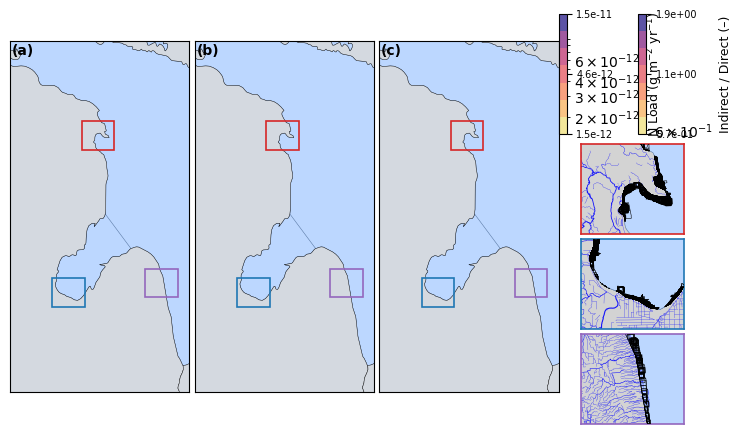

[Counties RAW] crs=EPSG:3174 -> [EPSG:3174] count=4369 bounds=[-14305552.61735841  -8042233.99836776  16305606.43433335
  16739875.79434085]
[Lake RAW] crs=EPSG:3174 -> [EPSG:3174] count=1366 bounds=[-13058875.18186331  -7022795.60638082  14464699.12086754
  13589634.4328059 ]
[CW[low] RAW] crs=EPSG:3174 -> [EPSG:3174] count=5998 bounds=[ 979197.81657121  714870.51918752 1165953.51306024 1022476.24360609]
[NHD RAW] crs=EPSG:4269 -> [EPSG:3174] count=113244 bounds=[ 337331.38196757  425342.33219035 1847767.56219043 1299493.67154364]
✅ Saved combined hex layer: /home/abolmaal/hex_shapefiles/WetLoad_N_low_H3_23_all.shp
✅ Saved: /home/abolmaal/hex_shapefiles/WetLoad_N_low_H3_23_direct.shp
✅ Saved: /home/abolmaal/hex_shapefiles/WetLoad_N_low_H3_23_indirect.shp
✅ Saved: /home/abolmaal/hex_shapefiles/WetLoad_N_low_H3_23_ratio.shp
✅ Saved: /home/abolmaal/modelling/FVCOM/Huron/Figures/WetLoad_N_Direct_Indirect_Ratio_low_H3_tripanel_23.jpeg


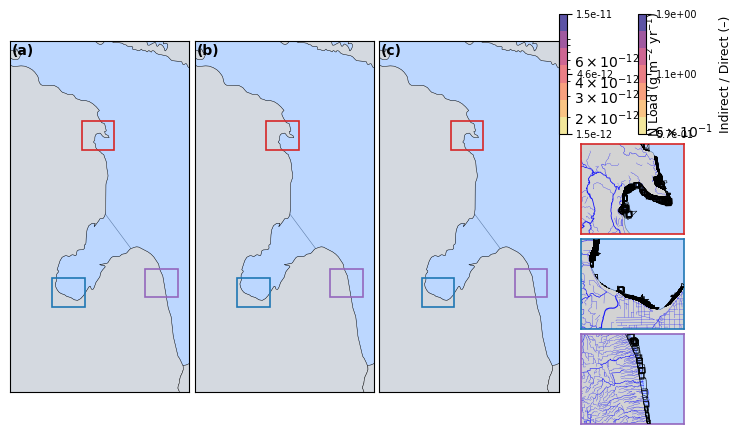

[Counties RAW] crs=EPSG:3174 -> [EPSG:3174] count=4369 bounds=[-14305552.61735841  -8042233.99836776  16305606.43433335
  16739875.79434085]
[Lake RAW] crs=EPSG:3174 -> [EPSG:3174] count=1366 bounds=[-13058875.18186331  -7022795.60638082  14464699.12086754
  13589634.4328059 ]
[CW[high] RAW] crs=EPSG:3174 -> [EPSG:3174] count=14081 bounds=[ 979197.81657121  714870.51918752 1165953.51306024 1022476.2436061 ]
[NHD RAW] crs=EPSG:4269 -> [EPSG:3174] count=113244 bounds=[ 337331.38196757  425342.33219035 1847767.56219043 1299493.67154364]
✅ Saved combined hex layer: /home/abolmaal/hex_shapefiles/WetLoad_N_high_H3_23_all.shp
✅ Saved: /home/abolmaal/hex_shapefiles/WetLoad_N_high_H3_23_direct.shp
✅ Saved: /home/abolmaal/hex_shapefiles/WetLoad_N_high_H3_23_indirect.shp
✅ Saved: /home/abolmaal/hex_shapefiles/WetLoad_N_high_H3_23_ratio.shp
✅ Saved: /home/abolmaal/modelling/FVCOM/Huron/Figures/WetLoad_N_Direct_Indirect_Ratio_high_H3_tripanel_23.jpeg


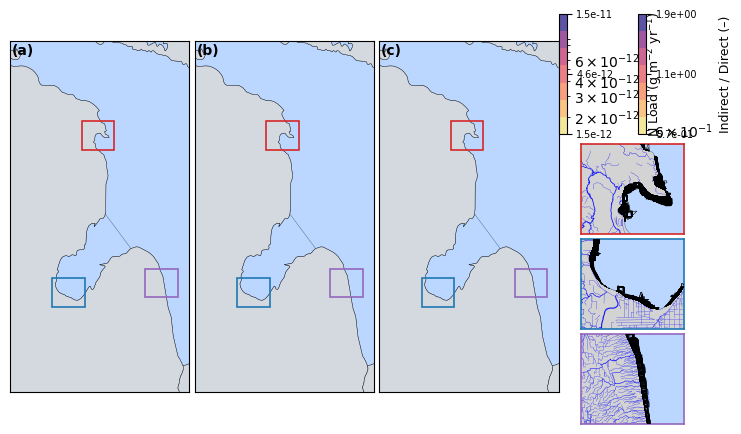

[Counties RAW] crs=EPSG:3174 -> [EPSG:3174] count=4369 bounds=[-14305552.61735841  -8042233.99836776  16305606.43433335
  16739875.79434085]
[Lake RAW] crs=EPSG:3174 -> [EPSG:3174] count=1366 bounds=[-13058875.18186331  -7022795.60638082  14464699.12086754
  13589634.4328059 ]
[CW[surge] RAW] crs=EPSG:3174 -> [EPSG:3174] count=19166 bounds=[ 979197.81657121  714870.51918752 1165953.51306024 1022476.24360609]
[NHD RAW] crs=EPSG:4269 -> [EPSG:3174] count=113244 bounds=[ 337331.38196757  425342.33219035 1847767.56219043 1299493.67154364]
✅ Saved combined hex layer: /home/abolmaal/hex_shapefiles/WetLoad_N_surge_H3_23_all.shp
✅ Saved: /home/abolmaal/hex_shapefiles/WetLoad_N_surge_H3_23_direct.shp
✅ Saved: /home/abolmaal/hex_shapefiles/WetLoad_N_surge_H3_23_indirect.shp
✅ Saved: /home/abolmaal/hex_shapefiles/WetLoad_N_surge_H3_23_ratio.shp
✅ Saved: /home/abolmaal/modelling/FVCOM/Huron/Figures/WetLoad_N_Direct_Indirect_Ratio_surge_H3_tripanel_23.jpeg


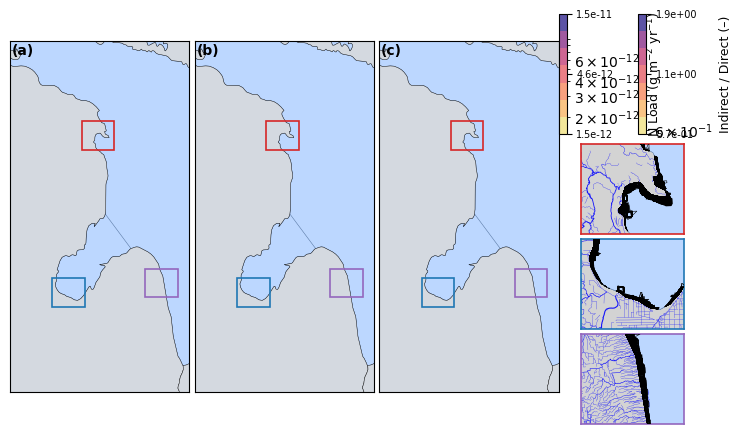

In [11]:
# =============PLOT Nitrogen==================
CW_layers = {"avg": CW_avg, "low": CW_low, "high": CW_high, "surge": CW_surge}
for cat in ["avg", "low", "high", "surge"]:  # list keeps order
    plot_wetload_distribution_h3_tripanel(
        cat=cat,
        value_type="N",                 # or "P"
        Lake=Lakes, lake_src_crs="EPSG:3174",
        Counties=counties_gdf, counties_src_crs="EPSG:3174",
        CW_layers=CW_layers, cw_src_crs="EPSG:3174",
        NHD_flowline=NHD_flowline, nhd_src_crs="EPSG:4269",

        resolution=6,
        output_figures=output_figures,
        extent=[-84.5, -82.35, 42.80, 45.88],

        fig_size=(6.69, 5.0),          # small figure
        enlarge_m=800, 
        inset_extents=[
                [1_050_000, 1_115_000, 920_000, 968_000],
                [1_044_000, 1_064_000, 745_000, 835_000],
                [1_130_000, 1_160_000, 798_000, 800_000],
            ],
        inset_fig_boxes=[
            [0.840,0.50,0.30,0.18],
            [0.840,0.31,0.30,0.18],
            [0.840,0.12,0.30,0.18]],
        show_nhd_on_main=False,
        show_nhd_on_insets=True,
        show_inset_ticks=False,
        save_hex=True,
        hex_outdir="/home/abolmaal/hex_shapefiles",
        hex_format="shp",
    )




✅ Saved: /home/abolmaal/modelling/FVCOM/Huron/Figures/WetLoad_P_Direct_Indirect_Ratio_avg_H3_tripanel_23.jpeg


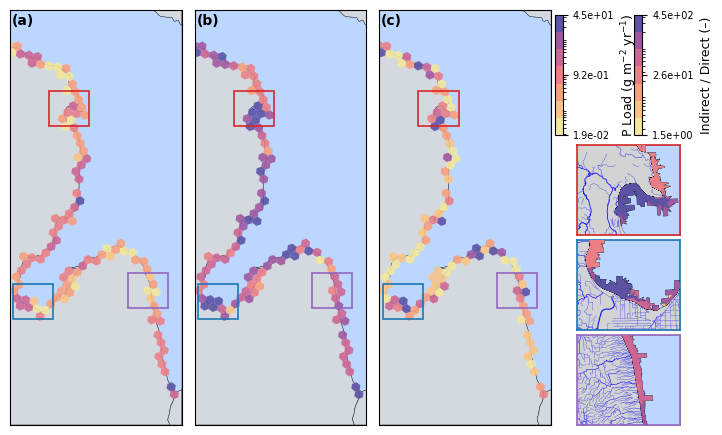

✅ Saved: /home/abolmaal/modelling/FVCOM/Huron/Figures/WetLoad_P_Direct_Indirect_Ratio_low_H3_tripanel_23.jpeg


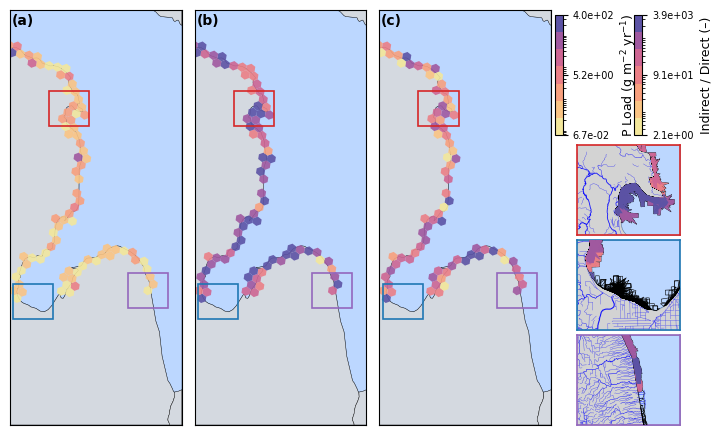

✅ Saved: /home/abolmaal/modelling/FVCOM/Huron/Figures/WetLoad_P_Direct_Indirect_Ratio_high_H3_tripanel_23.jpeg


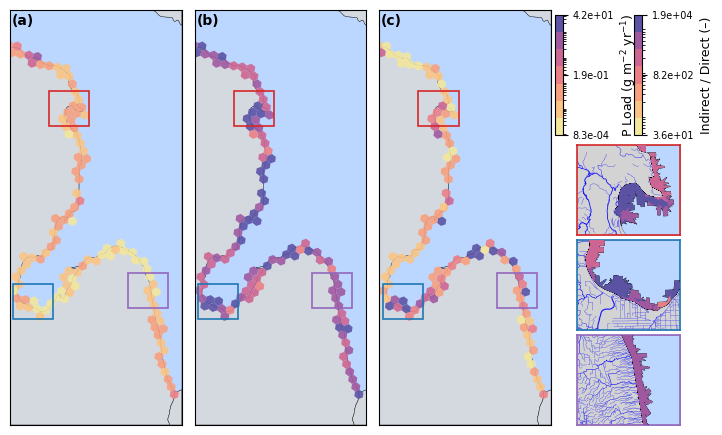

✅ Saved: /home/abolmaal/modelling/FVCOM/Huron/Figures/WetLoad_P_Direct_Indirect_Ratio_surge_H3_tripanel_23.jpeg


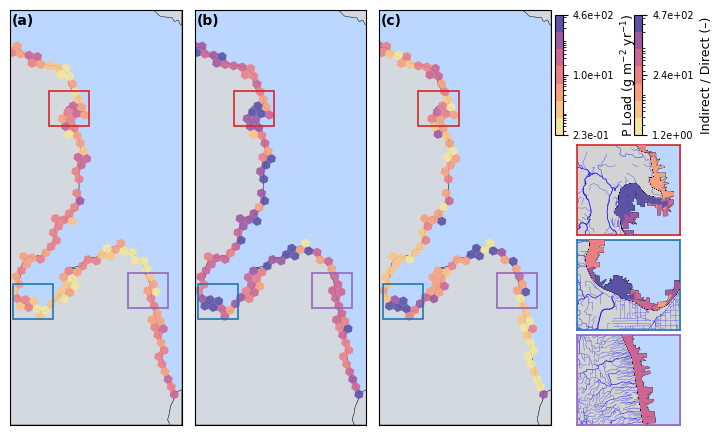

In [15]:
# =============PLOT Nitrogen==================
CW_layers = {"avg": CW_avg, "low": CW_low, "high": CW_high, "surge": CW_surge}
for cat in ["avg", "low", "high", "surge"]:  # list keeps order
    plot_wetload_distribution_h3_tripanel(
        cat=cat,
        value_type="P",                 # or "P"
        Lake=Lakes, lake_src_crs="EPSG:3174",
        Counties=counties_gdf, counties_src_crs="EPSG:3174",
        CW_layers=CW_layers, cw_src_crs="EPSG:3174",
        NHD_flowline=NHD_flowline, nhd_src_crs="EPSG:4269",

        resolution=6,
        output_figures=output_figures,
        extent=[-84, -82.35, 42.80, 45.75],

        fig_size=(6.69, 5.0),          # small figure
        enlarge_m=800, 
        inset_extents=[
                [1_050_000, 1_115_000, 920_000, 968_000],
                [1_044_000, 1_064_000, 745_000, 835_000],
                [1_130_000, 1_160_000, 798_000, 800_000],
            ],
        inset_fig_boxes=[
            [0.840,0.50,0.30,0.18],
            [0.840,0.31,0.30,0.18],
            [0.840,0.12,0.30,0.18]],
        show_nhd_on_main=False,
        show_nhd_on_insets=True,
        show_inset_ticks=False,
    )


#### PLot one 


In [19]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
from matplotlib.patches import Rectangle
import geopandas as gpd
from shapely.geometry import box

GL_ALBERS = "EPSG:3175"   # NAD83 / Great Lakes Albers Equal Area
# Modern colormap API (no deprecation warning)
reversed_plasma_cmap = matplotlib.colormaps.get_cmap("plasma").reversed()

# ------------------ helpers ------------------
def _load_gdf(src):
    """Load a GeoDataFrame from a GeoDataFrame, path, or GeoJSON-like dict."""
    if src is None:
        return None
    if isinstance(src, gpd.GeoDataFrame):
        return src.copy()
    if isinstance(src, str):
        return gpd.read_file(src)
    if isinstance(src, dict):
        return gpd.GeoDataFrame.from_features(src["features"], crs="EPSG:4326")
    raise TypeError(f"Unsupported type for geodata source: {type(src)}")

def _to_3175(gdf: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    if gdf is None:
        return None
    if gdf.crs is None:
        raise ValueError("A layer has no CRS. Set its CRS before plotting (e.g., gdf.set_crs('EPSG:4326')).")
    return gdf.to_crs(GL_ALBERS)

def _project_extent_4326_to_3175(extent_ll):
    """extent_ll = [minlon, maxlon, minlat, maxlat] -> returns [minx, maxx, miny, maxy] in EPSG:3175."""
    minlon, maxlon, minlat, maxlat = extent_ll
    bbox_ll = gpd.GeoSeries([box(minlon, minlat, maxlon, maxlat)], crs="EPSG:4326")
    minx_p, miny_p, maxx_p, maxy_p = bbox_ll.to_crs(GL_ALBERS).total_bounds
    return [minx_p, maxx_p, miny_p, maxy_p]

# ------------------ main function ------------------
def plot_wetload_distribution(
    cat,
    Lakes=None,         # GeoDataFrame | path | GeoJSON-like dict | None
    Counties=None,      # GeoDataFrame | path | GeoJSON-like dict | None
    value_type="N",     # "N" or "P"
    font_size=20,
    title=None,
    colorbar_outside=True,
    output_figures='.',
    extent=[-84.5, -81, 42.5, 46.5],          # lon/lat; projected internally
    inset_extents=None,                       # list of [minx,maxx,miny,maxy] in EPSG:3175
    inset_boxes=None,                         # list of [x0,y0,w,h] in axes fraction
    inset_colors=None                         # e.g., ["tab:red","tab:green"]
):
    """
    Draws hexbin of Total{value_type}_{cat}_grm2yr on EPSG:3175 with optional colored insets.

    inset_extents: list of projected extents to zoom into (EPSG:3175).
    inset_boxes:   list of placements for insets in axes fraction [x0,y0,w,h].
    inset_colors:  list of colors for each inset (also colors the locator rectangles).
    """
    # -------- Data prep (in 4326) --------
    df = globals().get(f'TotalLoad_CW_{cat}')
    if df is None:
        raise ValueError(f"No dataframe found for category '{cat}'")

    # Filter invalid coords
    df = df[
        df['start_lon'].notna() & df['start_lat'].notna() &
        (df['start_lon'] != 0.0) & (df['start_lat'] != 0.0)
    ].copy()

    # Clip by lon/lat extent
    lon_min, lon_max, lat_min, lat_max = extent
    df = df[
        (df['start_lon'] >= lon_min) & (df['start_lon'] <= lon_max) &
        (df['start_lat'] >= lat_min) & (df['start_lat'] <= lat_max)
    ].copy()
    if df.empty:
        raise ValueError("No points remain after filtering by extent/valid coords.")

    col_key = f"Total{value_type}_{cat}_grm2yr"
    if col_key not in df.columns:
        raise ValueError(f"Column '{col_key}' not found in dataframe")

    # Make points in 4326 and project to 3175
    pts_4326 = gpd.GeoDataFrame(
        df, geometry=gpd.points_from_xy(df['start_lon'], df['start_lat']), crs="EPSG:4326"
    )
    pts_3175 = pts_4326.to_crs(GL_ALBERS)

    # -------- Overlays in 3175 --------
    Lakes_gdf = _to_3175(_load_gdf(Lakes)) if Lakes is not None else None
    Counties_gdf = _to_3175(_load_gdf(Counties)) if Counties is not None else None

    # Projected plot extent + clip overlays to it
    minx_p, maxx_p, miny_p, maxy_p = _project_extent_4326_to_3175(extent)
    bbox_proj = box(minx_p, miny_p, maxx_p, maxy_p)

    def _clip(gdf):
        if gdf is None or gdf.empty:
            return gdf
        try:
            return gpd.clip(gdf, bbox_proj)
        except Exception:
            return gdf[gdf.geometry.intersects(bbox_proj)]

    Lakes_clip = _clip(Lakes_gdf)
    Counties_clip = _clip(Counties_gdf)

    # -------- Plot (in EPSG:3175 meters) --------
    fig, ax = plt.subplots(figsize=(18, 20))

    if Counties_clip is not None and not Counties_clip.empty:
        Counties_clip.plot(ax=ax, facecolor='gray', edgecolor='black', linewidth=0.8, zorder=0)
    if Lakes_clip is not None and not Lakes_clip.empty:
        Lakes_clip.plot(ax=ax, facecolor='deepskyblue', edgecolor='black', alpha=0.5, linewidth=0.8, zorder=1)

    # Hexbin on projected x/y
    x = pts_3175.geometry.x.values
    y = pts_3175.geometry.y.values
    values = pts_3175[col_key].astype(float).values

    q_min = np.nanquantile(values, 0.05)
    q_max = np.nanquantile(values, 0.95)
    vmin = max(q_min, 1e-12)
    vmax = max(vmin * 10.0, q_max)

    hb = ax.hexbin(
        x, y, C=values,
        gridsize=60,
        cmap=reversed_plasma_cmap,
        norm=LogNorm(vmin=vmin, vmax=vmax),
        reduce_C_function=np.mean,
        edgecolors='none',
        zorder=2
    )

    # Colorbar
    cbar = fig.colorbar(hb, ax=ax, pad=0.02 if colorbar_outside else 0.1)
    cbar.set_label(f'{value_type} Load (gram/m²/yr)', fontsize=font_size)
    log_ticks = np.logspace(np.log10(vmin), np.log10(vmax), num=7)
    cbar.set_ticks(log_ticks)
    cbar.set_ticklabels([f"{tick:.1e}" for tick in log_ticks])
    cbar.ax.tick_params(labelsize=font_size + 2)

    # Main labels
    ax.set_title(title or f"Total {value_type} Load to CW({cat} inundation)", fontsize=font_size + 2)
    ax.set_xlabel("Easting", fontsize=font_size+2)
    ax.set_ylabel("Northing", fontsize=font_size+2)
    ax.tick_params(labelsize=font_size - 2)
    ax.set_xlim(minx_p, maxx_p)
    ax.set_ylim(miny_p, maxy_p)
    ax.set_aspect('equal')

    # -------- Colored Insets (thicker lines) --------
    if inset_extents is not None and len(inset_extents) > 0:
        # Default placements inside the main axes if none provided
        if inset_boxes is None:
            inset_boxes = [
                [0.68, 0.62, 0.30, 0.30],  # [x0,y0,w,h] in axes fraction
                [0.68, 0.24, 0.30, 0.30],
            ]
        # Match counts
        inset_boxes = inset_boxes[:len(inset_extents)]

        # default colors if not provided (red, green by request)
        if inset_colors is None or len(inset_colors) == 0:
            inset_colors = ["tab:red", "tab:green", "tab:purple", "tab:orange"]
        # repeat/trim to match count
        if len(inset_colors) < len(inset_extents):
            times = (len(inset_extents) + len(inset_colors) - 1) // len(inset_colors)
            inset_colors = (inset_colors * times)[:len(inset_extents)]
        else:
            inset_colors = inset_colors[:len(inset_extents)]

        for (xmin_i, xmax_i, ymin_i, ymax_i), ibox, color in zip(inset_extents, inset_boxes, inset_colors):
            # Locator rectangle on the main map with matching color, thicker lines
            ax.add_patch(Rectangle(
                (xmin_i, ymin_i), xmax_i - xmin_i, ymax_i - ymin_i,
                fill=False, lw=3.5, ec=color, zorder=3
            ))
            # Inset axis with colored, thicker frame
            axins = ax.inset_axes(ibox)
            for spine in axins.spines.values():
                spine.set_edgecolor(color)
                spine.set_linewidth(3.5)

            # background overlays
            if Counties_clip is not None and not Counties_clip.empty:
                Counties_clip.plot(ax=axins, facecolor='gray', edgecolor='black', linewidth=0.5, zorder=0)
            if Lakes_clip is not None and not Lakes_clip.empty:
                Lakes_clip.plot(ax=axins, facecolor='deepskyblue', edgecolor='black', alpha=0.5, linewidth=0.5, zorder=1)

            # hexbin inset (same normalization so colors match)
            axins.hexbin(
                x, y, C=values,
                gridsize=40,
                cmap=reversed_plasma_cmap,
                norm=LogNorm(vmin=vmin, vmax=vmax),
                reduce_C_function=np.mean,
                edgecolors='none',
                zorder=2
            )
            axins.set_xlim(xmin_i, xmax_i)
            axins.set_ylim(ymin_i, ymax_i)
            axins.set_xticks([]); axins.set_yticks([])
            axins.set_aspect('equal')

    # -------- Save (fallback if tight bbox fails) --------
    outpath = f"{output_figures}/WetLoad_{value_type}_{cat}_GLAlbers2.png"
    try:
        plt.savefig(outpath, dpi=300, bbox_inches='tight')
    except ValueError:
        plt.savefig(outpath, dpi=300)
    print(f"✅ Saved: {outpath}")
    plt.show()


In [ ]:
for cat in ['avg', 'high', 'low', 'surge']:
    plot_wetload_distribution(
        cat=cat,
        Lakes=Lakes,
        Counties=counties,
        value_type="N",
        title=f"Total Nitrogen Load ({cat} inundation)",
        inset_extents=[
            [0.978e6, 1.02e6, 0.92e6, 0.96e6],
            [0.93e6, 1e6, 0.77e6, 0.85e6]
        ],
        output_figures=output_figures
    )

In [ ]:
for cat in ['avg', 'high', 'low', 'surge']:
    plot_wetload_distribution(
        cat=cat,
        Lakes=Lakes,
        Counties=counties,
        value_type="P",
        title=f"Total Phosphorus Load ({cat} inundation)",
        inset_extents=[
            [0.978e6, 1.02e6, 0.92e6, 0.96e6],
            [0.93e6, 1e6, 0.77e6, 0.85e6]
        ],
        output_figures=output_figures
    )

### show the contribution of Direct vs Indirect load 

In [ ]:
import matplotlib.pyplot as plt

def plot_direct_vs_indirect_pie(cat, df=None, save_path=None):
    """
    Makes a pie (donut) chart showing contribution of Direct vs Indirect TN load
    to the total for a given wetland category.
    
    Parameters
    ----------
    cat : str
        Inundation category (e.g., 'avg', 'high', 'low', 'surge')
    df : pd.DataFrame, optional
        Dataframe. If None, will use globals()[f'TotalLoad_CW_{cat}'].
    save_path : str, optional
        Path to save the figure. If None, just shows it.
    """
    if df is None:
        df = globals().get(f'TotalLoad_CW_{cat}')
        if df is None:
            raise ValueError(f"No dataframe found for category '{cat}'")

    # Columns
    col_direct = f"CoastalWatershedDirectTN_{cat}_grm2yr"
    col_indirect = "TotalIndirectCW_TN_grm2yr"

    if col_direct not in df.columns or col_indirect not in df.columns:
        raise ValueError("Required columns not found in dataframe")

    # Sum up all sites
    direct_sum = df[col_direct].sum(skipna=True)
    indirect_sum = df[col_indirect].sum(skipna=True)

    # Pie chart
    values = [direct_sum, indirect_sum]
    labels = ["Direc             t TN", "Indirect TN"]
    colors = ["#E15759", "#4E79A7"]  # red vs blue

    fig, ax = plt.subplots(figsize=(7, 7))
    wedges, texts, autotexts = ax.pie(
        values,
        labels=labels,
        colors=colors,
        autopct=lambda p: f"{p:.1f}%",  # show percentages
        textprops={"fontsize": 14, "color": "white"},
        startangle=90,
        wedgeprops=dict(width=0.5)  # makes it a donut
    )

    ax.set_title(f"Direct vs Indirect TN Load ({cat})", fontsize=16)
    plt.tight_layout()
    outpath = f"{output_figures}/piechartDirectIndirectcontribution_{cat}.png"
    plt.savefig(outpath, dpi=300, bbox_inches='tight')
    print(f"✅ Saved: {outpath}")
    plt.show()


In [ ]:
# For all categories and save
for cat in ["avg", "high", "low", "surge"]:
    plot_direct_vs_indirect_pie(cat, save_path=f"{output_figures}/PieChart_TN_{cat}.png")

## Different particles release number 

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_total_load_diff_extent(
    cat,
    extent=(1_044_000, 1_064_000, 745_000, 835_000),
    id_col="group_id",
    x_col="x",
    y_col="y",
    diff_mode="saginaw-minus-total",  # or "total-minus-saginaw"
    point_size=18,
    cmap="coolwarm",
    output_figures=".",
    dpi=200,
):
    """
    Plot Total load difference (TN & TP) between:
      - globals()[f"TotalLoad_CW_{cat}"]           (the 'total' file)
      - globals()[f"TotalLoad_CW_saginaw_{cat}"]   (the 'saginaw' file)

    The difference is computed per matched {id_col} and plotted for points inside `extent`.

    Parameters
    ----------
    cat : str
        Category key (e.g., "avg", "high", "low", "surge").
    extent : (xmin, xmax, ymin, ymax)
        Bounding box in the same CRS/units as your coordinate columns.
    id_col : str
        Column that identifies matching rows (e.g., "group_id" / "CW_id").
    x_col, y_col : str
        Coordinate column names used for spatial filtering/plotting.
    diff_mode : str
        "saginaw-minus-total" or "total-minus-saginaw".
    """

    # ---- pull dataframes from globals as you already read them ----
    df_total   = globals().get(f"TotalLoad_CW_{cat}")
    df_sag     = globals().get(f"TotalLoad_CW_saginaw_{cat}")
    if df_total is None or df_sag is None:
        raise ValueError("Expected globals TotalLoad_CW_{cat} and TotalLoad_CW_saginaw_{cat} to be loaded.")

    # ---- sanity checks ----
    for name, df in [("Total", df_total), ("Saginaw", df_sag)]:
        for c in [id_col, x_col, y_col]:
            if c not in df.columns:
                raise ValueError(f"{name} df missing column '{c}'. "
                                 f"Pass correct id_col/x_col/y_col or rename columns.")
    tn_col = f"TotalN_{cat}_grm2yr"
    tp_col = f"TotalP_{cat}_grm2yr"
    for c in [tn_col, tp_col]:
        if c not in df_total.columns or c not in df_sag.columns:
            raise ValueError(f"Missing total column '{c}' in one of the dataframes.")

    # ---- merge on id_col to align rows ----
    keep_cols = [id_col, x_col, y_col, tn_col, tp_col]
    a = df_total[keep_cols].copy()
    b = df_sag[keep_cols].copy()
    m = a.merge(b, on=id_col, suffixes=("_tot", "_sag"))

    # ---- compute differences ----
    if diff_mode == "saginaw-minus-total":
        m["dTN"] = m[f"{tn_col}_sag"] - m[f"{tn_col}_tot"]
        m["dTP"] = m[f"{tp_col}_sag"] - m[f"{tp_col}_tot"]
    elif diff_mode == "total-minus-saginaw":
        m["dTN"] = m[f"{tn_col}_tot"] - m[f"{tn_col}_sag"]
        m["dTP"] = m[f"{tp_col}_tot"] - m[f"{tp_col}_sag"]
    else:
        raise ValueError("diff_mode must be 'saginaw-minus-total' or 'total-minus-saginaw'.")

    # ---- pick coordinates (use the 'total' side; they should be same after merge) ----
    m["X"] = m[f"{x_col}_tot"]
    m["Y"] = m[f"{y_col}_tot"]

    # ---- spatial filter by extent ----
    xmin, xmax, ymin, ymax = extent
    inside = (m["X"] >= xmin) & (m["X"] <= xmax) & (m["Y"] >= ymin) & (m["Y"] <= ymax)
    mm = m.loc[inside].copy()
    if mm.empty:
        raise ValueError("No points fall inside the provided extent. Check CRS/columns/extent.")

    # ---- symmetric color range around 0 for diverging cmap ----
    vmaxTN = np.nanmax(np.abs(mm["dTN"].values))
    vmaxTP = np.nanmax(np.abs(mm["dTP"].values))
    vTN = 1e-12 if not np.isfinite(vmaxTN) else vmaxTN
    vTP = 1e-12 if not np.isfinite(vmaxTP) else vmaxTP

    fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

    sc1 = axes[0].scatter(mm["X"], mm["Y"], c=mm["dTN"], s=point_size, cmap=cmap, vmin=-vTN, vmax=vTN)
    axes[0].set_title(f"TN difference ({diff_mode.replace('-', ' ')})")
    axes[0].set_xlim(xmin, xmax); axes[0].set_ylim(ymin, ymax)
    axes[0].set_aspect("equal", adjustable="box")
    cb1 = plt.colorbar(sc1, ax=axes[0], shrink=0.9, pad=0.02)
    cb1.set_label(f"Δ Total N (g/m²/yr)")

    sc2 = axes[1].scatter(mm["X"], mm["Y"], c=mm["dTP"], s=point_size, cmap=cmap, vmin=-vTP, vmax=vTP)
    axes[1].set_title(f"TP difference ({diff_mode.replace('-', ' ')})")
    axes[1].set_xlim(xmin, xmax); axes[1].set_ylim(ymin, ymax)
    axes[1].set_aspect("equal", adjustable="box")
    cb2 = plt.colorbar(sc2, ax=axes[1], shrink=0.9, pad=0.02)
    cb2.set_label(f"Δ Total P (g/m²/yr)")

    for ax in axes:
        ax.set_xlabel("X"); ax.set_ylabel("Y")
        ax.grid(True, alpha=0.25, linestyle="--", linewidth=0.6)

    out = f"{output_figures}/total_load_diff_{cat}_{diff_mode}.png"
    plt.savefig(out, dpi=dpi, bbox_inches="tight")
    print(f"✅ Saved: {out}")
    plt.show()


In [24]:
# plot_total_load_diff_extent(
#     cat="avg",
#     extent=(1_044_000, 1_064_000, 745_000, 835_000),
#     id_col="group_ids",   # change to your actual ID column if different
#     x_col="x",           # change if yours are e.g. "cx3174"/"centroid_x"
#     y_col="y",
#     diff_mode="saginaw-minus-total",  # or "total-minus-saginaw"
#     output_figures=output_figures,
# )

## compare nutrient load for different categorie

In [16]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def seaborn_box_with_mean_bars(
    df, x, y,
    orient="v",                 # 'v' (x=categorical, y=value) or 'h' (y=categorical, x=value)
    order=None,                 # explicit category order (e.g., ["avg","low","high","surge"])
    palette="Set2",
    width=0.6,
    showfliers=False,
    mean_bar_color="crimson",
    mean_bar_lw=3.0,
    mean_bar_halfwidth=0.35,
    show_mean_dots=False,
    global_mean=False,
    ax=None
):
    if ax is None:
        fig, ax = plt.subplots(figsize=(7.2, 4.6))

    vert = (orient.lower() == "v")
    cat_col, val_col = (x, y) if vert else (y, x)

    # If no order provided, use the unique order appearing in the data
    if order is None:
        order = list(dict.fromkeys(df[cat_col].astype(str)))

    # Seaborn deprecation: provide hue=category, but disable legend and dodge
    sns.boxplot(
        data=df,
        x=(cat_col if vert else val_col),
        y=(val_col if vert else cat_col),
        order=order,                 # <- always pass order for the categorical axis
        hue=cat_col,                 # color by category
        dodge=False, legend=False,   # but keep single box per category
        palette=palette,
        width=width,
        showfliers=showfliers,
        orient=("v" if vert else "h"),
        ax=ax,
    )

    # Get the ACTUAL positions and labels used by the plot
    if vert:
        positions = ax.get_xticks()
        labels    = [t.get_text() for t in ax.get_xticklabels()]
    else:
        positions = ax.get_yticks()
        labels    = [t.get_text() for t in ax.get_yticklabels()]

    # Compute means in the SAME order as those labels
    means = []
    for lab in labels:
        vals = df.loc[df[cat_col].astype(str) == lab, val_col].astype(float).to_numpy()
        means.append(np.nanmean(vals))

    # Overlay mean bars (and optional mean dots)
    if vert:
        for pos, m in zip(positions, means):
            ax.plot([pos - mean_bar_halfwidth, pos + mean_bar_halfwidth], [m, m],
                    color=mean_bar_color, lw=mean_bar_lw, solid_capstyle="butt", zorder=4)
            if show_mean_dots:
                ax.plot(pos, m, marker="o", ms=5, mfc="white", mec=mean_bar_color, zorder=5)
        if global_mean:
            ax.axhline(np.nanmean(df[val_col].astype(float)), color="gray", lw=1.5, ls="--", zorder=3)
        ax.set_xlabel(cat_col); ax.set_ylabel(val_col)
    else:
        for pos, m in zip(positions, means):
            ax.plot([m, m], [pos - mean_bar_halfwidth, pos + mean_bar_halfwidth],
                    color=mean_bar_color, lw=mean_bar_lw, solid_capstyle="butt", zorder=4)
            if show_mean_dots:
                ax.plot(m, pos, marker="o", ms=5, mfc="white", mec=mean_bar_color, zorder=5)
        if global_mean:
            ax.axvline(np.nanmean(df[val_col].astype(float)), color="gray", lw=1.5, ls="--", zorder=3)
        ax.set_ylabel(cat_col); ax.set_xlabel(val_col)

    sns.despine(ax=ax)
    return ax


✅ Saved: /home/abolmaal/modelling/FVCOM/Huron/Figures/boxplot_TotalN_by_category_with_mean_bars_23.jpeg


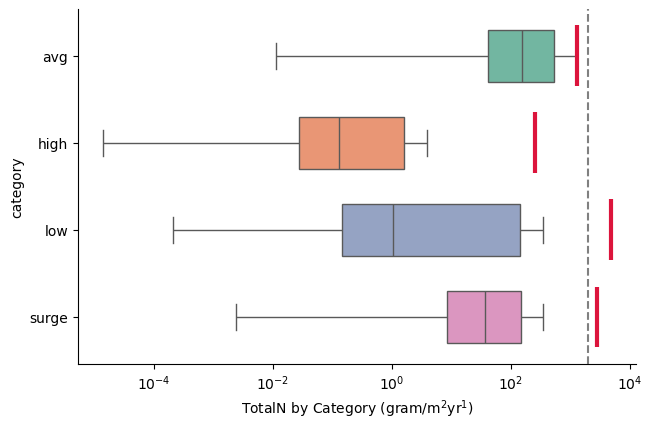

In [17]:
# Build tidy DF from your category frames
import pandas as pd
cats = ["avg","high","low","surge"]
vt = "N"  # or "N"

frames = []
for cat in cats:
    df_cat = globals()[f"TotalLoad_CW_{cat}"]
    col = f"Total{vt}_{cat}_grm2yr"
    frames.append(pd.DataFrame({"category": cat, "value": pd.to_numeric(df_cat[col], errors="coerce")}))

plot_df = pd.concat(frames, ignore_index=True).dropna()

# Plot horizontal with consistent order (so means align)
ax = seaborn_box_with_mean_bars(
    df=plot_df, x="value", y="category",
    orient="h",
    order=cats,                 # <- ensure plotting order
    palette="Set2",
    showfliers=False,
    mean_bar_color="crimson",
    mean_bar_lw=3,
    show_mean_dots=False,
    global_mean=True
)
ax.set_xscale("log")
ax.set_xlabel(f"Total{vt} by Category (gram/m$^{{2}}$yr$^{{1}}$)")
fig = ax.get_figure()
outpath = f"{output_figures}/boxplot_Total{vt}_by_category_with_mean_bars_{year}.jpeg"
fig.savefig(outpath, dpi=300, bbox_inches="tight")
print(f"✅ Saved: {outpath}")
plt.show()


✅ Saved: /home/abolmaal/modelling/FVCOM/Huron/Figures/boxplot_TotalP_by_category_with_mean_bars_23.jpeg


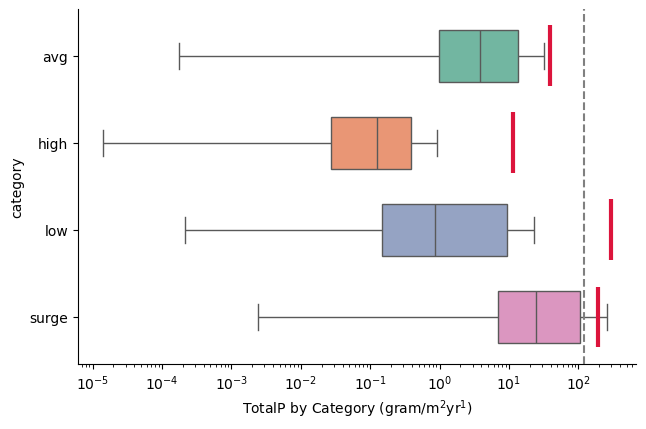

In [18]:
# Build tidy DF from your category frames
import pandas as pd
cats = ["avg","high","low","surge"]
vt = "P"  # or "N"

frames = []
for cat in cats:
    df_cat = globals()[f"TotalLoad_CW_{cat}"]
    col = f"Total{vt}_{cat}_grm2yr"
    frames.append(pd.DataFrame({"category": cat, "value": pd.to_numeric(df_cat[col], errors="coerce")}))

plot_df = pd.concat(frames, ignore_index=True).dropna()

# Plot horizontal with consistent order (so means align)
ax = seaborn_box_with_mean_bars(
    df=plot_df, x="value", y="category",
    orient="h",
    order=cats,                 # <- ensure plotting order
    palette="Set2",
    showfliers=False,
    mean_bar_color="crimson",
    mean_bar_lw=3,
    show_mean_dots=False,
    global_mean=True
)
ax.set_xscale("log")
ax.set_xlabel(f"Total{vt} by Category (gram/m$^{{2}}$yr$^{{1}}$)")
fig = ax.get_figure()
outpath = f"{output_figures}/boxplot_Total{vt}_by_category_with_mean_bars_{year}.jpeg"
fig.savefig(outpath, dpi=300, bbox_inches="tight")
print(f"✅ Saved: {outpath}")
plt.show()


### bar chart to direct indirect total 

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_load_distributions(cat, df=None, save_path=None):
    """
    Create a (2x3) figure showing distributions of Direct, Indirect, and Total TN/TP loads.
    For Indirect TN/TP, filters values to within the 5th–95th quantile.
    """
    if df is None:
        df = globals().get(f"TotalLoad_CW_{cat}")
        if df is None:
            raise ValueError(f"No dataframe found for category '{cat}'")

    # Column mappings: label -> column name
    columns = {
        f"Direct TN Load to CW (g/m²/yr)": f"CoastalWatershedDirectTN_{cat}_grm2yr",
        f"Indirect TN Load to CW (g/m²/yr)": "TotalIndirectCW_TN_grm2yr",
        f"Total TN Load to CW (g/m²/yr)": f"TotalN_{cat}_grm2yr",
        f"Direct TP Load to CW (g/m²/yr)": f"CoastalWatershedDirectTP_{cat}_grm2yr",
        f"Indirect TP Load to CW (g/m²/yr)": "TotalIndirectCW_TP_grm2yr",
        f"Total TP Load to CW (g/m²/yr)": f"TotalP_{cat}_grm2yr"
    }

    # Layout (2 rows × 3 cols)
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()

    # Colors
    colors = ["orange", "blue", "green", "orange", "blue", "green"]

    for ax, (title, col), color in zip(axes, columns.items(), colors):
        if col not in df.columns:
            continue
        
        values = df[col].dropna()
        values = values[values > 0]  # remove non-positive

        # --- Apply quantile filtering only for indirect loads ---
        if "Indirect" in title:
            q_min = np.nanquantile(values, 0.05)
            q_max = np.nanquantile(values, 0.95)
            vmin = max(q_min, 1e-12)
            vmax = max(vmin * 10.0, q_max)
            values = values[(values >= vmin) & (values <= vmax)]

        if values.empty:
            continue

        # Transform to log10
        log_values = np.log10(values)

        # Histogram + KDE
        sns.histplot(log_values, bins=30, kde=True, color=color, ax=ax, stat="count")

        # Stats
        mean_val = values.mean()
        median_val = values.median()

        # Vertical lines
        ax.axvline(np.log10(mean_val), color="red", linestyle="--", label="Mean")
        ax.axvline(np.log10(median_val), color="black", linestyle=":", label="Median")

        # Annotation box
        textstr = f"Mean: {mean_val:.2f} g/m²/yr\nMedian: {median_val:.2f} g/m²/yr"
        ax.text(0.02, 0.95, textstr, transform=ax.transAxes,
                fontsize=10, verticalalignment="top",
                bbox=dict(boxstyle="round", facecolor="white", alpha=0.7))

        # Titles
        ax.set_title(title, fontsize=12)
        ax.set_xlabel("log10(g/m²/yr)")
        ax.set_ylabel("Count")

    # Legend
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center", ncol=2)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    fig.suptitle(f"Direct vs Indirect vs Total Loads ({cat})", fontsize=16, y=1.02)

    outpath = f"{output_figures}/barchartdirectindirecttotal_{cat}.png"
    plt.savefig(outpath, dpi=300, bbox_inches='tight')
    print(f"✅ Saved figure: {outpath}")
    
    plt.show()


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_load_distributions(cat, df=None, save_path=None, output_figures="."):
    """
    Create a (2x3) figure showing distributions of Direct, Indirect, and Total TN/TP loads.
    For Indirect TN/TP, filters values to within the 5th–95th quantile.
    Additionally, removes indirect values above the maximum of direct loads.
    """
    if df is None:
        df = globals().get(f"TotalLoad_CW_{cat}")
        if df is None:
            raise ValueError(f"No dataframe found for category '{cat}'")

    # Column mappings: label -> column name
    columns = {
        f"Direct TN Load to CW (g/m²/yr)": f"CoastalWatershedDirectTN_{cat}_grm2yr",
        f"Indirect TN Load to CW (g/m²/yr)": "TotalIndirectCW_TN_grm2yr",
        f"Total TN Load to CW (g/m²/yr)": f"TotalN_{cat}_grm2yr",
        f"Direct TP Load to CW (g/m²/yr)": f"CoastalWatershedDirectTP_{cat}_grm2yr",
        f"Indirect TP Load to CW (g/m²/yr)": "TotalIndirectCW_TP_grm2yr",
        f"Total TP Load to CW (g/m²/yr)": f"TotalP_{cat}_grm2yr"
    }

    # First compute direct maxima for TN and TP
    direct_TN_col = f"CoastalWatershedDirectTN_{cat}_grm2yr"
    direct_TP_col = f"CoastalWatershedDirectTP_{cat}_grm2yr"
    direct_TN_max = df[direct_TN_col].dropna().max() if direct_TN_col in df else None
    direct_TP_max = df[direct_TP_col].dropna().max() if direct_TP_col in df else None

    # Layout (2 rows × 3 cols)
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()

    colors = ["orange", "blue", "green", "orange", "blue", "green"]

    for ax, (title, col), color in zip(axes, columns.items(), colors):
        if col not in df.columns:
            continue

        values = df[col].dropna()
        values = values[values > 0]

        # --- Apply quantile filtering only for indirect loads ---
        if "Indirect TN" in title:
            # quantile filter
            q_min = np.nanquantile(values, 0.1)
            q_max = np.nanquantile(values, 0.9)
            vmin = max(q_min, 1e-12)
            vmax = max(vmin * 10.0, q_max)
            values = values[(values >= vmin) & (values <= vmax)]

            # remove values greater than direct TN max
            if direct_TN_max is not None:
                values = values[values <= direct_TN_max]

        if "Indirect TP" in title:
            # quantile filter
            q_min = np.nanquantile(values, 0.1)
            q_max = np.nanquantile(values, 0.9)
            vmin = max(q_min, 1e-12)
            vmax = max(vmin * 10.0, q_max)
            values = values[(values >= vmin) & (values <= vmax)]

            # remove values greater than direct TP max
            if direct_TP_max is not None:
                values = values[values <= direct_TP_max]

        if values.empty:
            continue

        # log10 transform
        log_values = np.log10(values)

        # histogram + KDE
        sns.histplot(log_values, bins=30, kde=True, color=color, ax=ax, stat="count")

        # stats
        mean_val = values.mean()
        median_val = values.median()

        # vertical lines
        ax.axvline(np.log10(mean_val), color="red", linestyle="--", label="Mean")
        ax.axvline(np.log10(median_val), color="black", linestyle=":", label="Median")

        # annotation box
        textstr = f"Mean: {mean_val:.2f} g/m²/yr\nMedian: {median_val:.2f} g/m²/yr"
        ax.text(0.02, 0.95, textstr, transform=ax.transAxes,
                fontsize=10, verticalalignment="top",
                bbox=dict(boxstyle="round", facecolor="white", alpha=0.7))

        # titles
        ax.set_title(title, fontsize=12)
        ax.set_xlabel("log10(g/m²/yr)")
        ax.set_ylabel("Count")

    # legend
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper right", ncol=2)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    fig.suptitle(f"Direct vs Indirect vs Total Loads ({cat})", fontsize=16, y=1.02)

    outpath = f"{output_figures}/barchartdirectindirecttotal_{cat}_{year}.jpg"
    plt.savefig(outpath, dpi=300, bbox_inches='tight')
    print(f"✅ Saved figure: {outpath}")

    plt.show()


In [27]:
output_figures = "/home/abolmaal/modelling/FVCOM/Huron/Figures"

In [ ]:
# For all categories
for cat in ["avg", "high", "low", "surge"]:
    plot_load_distributions(cat, output_figures=output_figures)

✅ Saved figure: /home/abolmaal/modelling/FVCOM/Huron/Figures/barchartdirectindirecttotal_avg_23.jpg


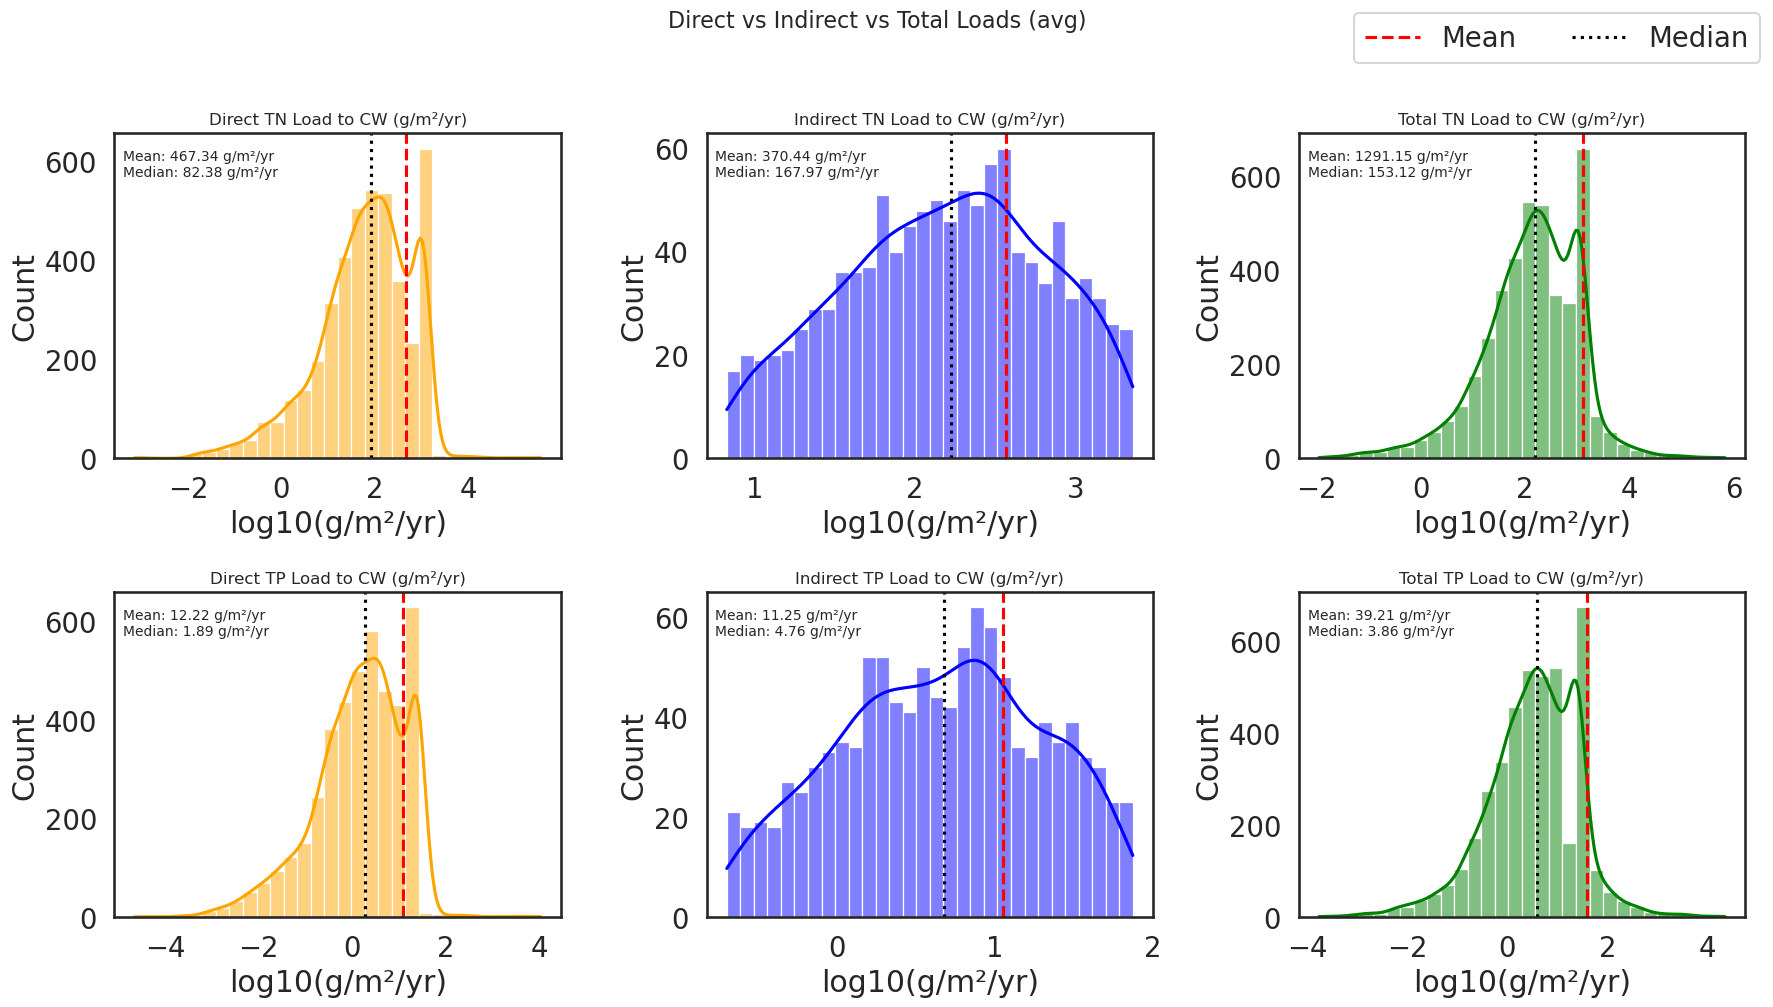

In [28]:
plot_load_distributions(
    cat="avg",
    df=None,
    output_figures=output_figures
)

### Creatw a summary table

In [12]:
import numpy as np
import pandas as pd
import os

# ---------- helper: stats for one series ----------
def _calc_stats(series):
    """Mean and selected percentiles for a pandas Series."""
    s = pd.to_numeric(series, errors="coerce")
    s = s.replace([np.inf, -np.inf], np.nan).dropna()

    if s.empty:
        return pd.Series(
            {
                "Mean": np.nan,
                "10th": np.nan,
                "25th": np.nan,
                "Med":  np.nan,
                "75th": np.nan,
                "90th": np.nan,
            }
        )

    qs = s.quantile([0.10, 0.25, 0.50, 0.75, 0.90])
    return pd.Series(
        {
            "Mean": s.mean(),
            "10th": qs.loc[0.10],
            "25th": qs.loc[0.25],
            "Med":  qs.loc[0.50],
            "75th": qs.loc[0.75],
            "90th": qs.loc[0.90],
        }
    )

# ---------- main function: builds summary table ----------
def make_wetload_summary_table(df, cat):
    """
    df  : TotalLoad_CW_{cat} dataframe
    cat : category string, e.g. 'avg', 'high', 'low'
    Returns a long-format summary table for TP and TN.
    """

    # ---- column names in your df (adjust if needed) ----
    tp_direct_col   = f"CoastalWatershedDirectTP_{cat}_grm2yr"
    tp_indirect_col = "TotalIndirectCW_TP_grm2yr"
    tn_direct_col   = f"CoastalWatershedDirectTN_{cat}_grm2yr"
    tn_indirect_col = "TotalIndirectCW_TN_grm2yr"

    # ---- Total Phosphorus ----
    tp_direct = df[tp_direct_col]
    tp_indir  = df[tp_indirect_col]
    tp_total  = tp_direct + tp_indir
    tp_ratio  = tp_direct / tp_indir.replace(0, np.nan)   # Direct / Indirect

    tp_table = pd.DataFrame(
        {
            "Direct":          _calc_stats(tp_direct),
            "Indirect":        _calc_stats(tp_indir),
            "Total":           _calc_stats(tp_total),
            "Direct/Indirect": _calc_stats(tp_ratio),
        }
    ).T  # rows = variables

    # ---- Total Nitrogen ----
    tn_direct = df[tn_direct_col]
    tn_indir  = df[tn_indirect_col]
    tn_total  = tn_direct + tn_indir
    tn_ratio  = tn_direct / tn_indir.replace(0, np.nan)

    tn_table = pd.DataFrame(
        {
            "Direct":          _calc_stats(tn_direct),
            "Indirect":        _calc_stats(tn_indir),
            "Total":           _calc_stats(tn_total),
            "Direct/Indirect": _calc_stats(tn_ratio),
        }
    ).T

    # ---- convert to long format with Nutrient column ----
    def _to_long_block(nutrient_name, subdf):
        out = subdf.copy()
        out.insert(0, "Nutrient", nutrient_name)   # first column
        out.insert(1, "Variable", out.index)       # Direct / Indirect / Total / Direct/Indirect
        return out

    tp_long = _to_long_block("Total Phosphorus", tp_table)
    tn_long = _to_long_block("Total Nitrogen",  tn_table)

    long_df = pd.concat([tp_long, tn_long], axis=0, ignore_index=True)
    long_df = long_df[["Nutrient", "Variable", "Mean", "10th", "25th", "Med", "75th", "90th"]]

    return long_df

# ---------- example usage ----------
cat = "avg"  # or "high", "low", etc.
df = globals()[f"TotalLoad_CW_{cat}"]

summary_table = make_wetload_summary_table(df, cat)
summary_table_rounded = summary_table.round(2)

print(summary_table_rounded)

# ---------- saving ----------


# 1) Save CSV
csv_path = os.path.join(output_figures, f"WetLoad_summary_table_{cat}.csv")
summary_table_rounded.to_csv(csv_path, index=False)
print("✅ Saved CSV to:", csv_path)

# 2) Save LaTeX (full table env) into output_figures
latex_tabular = summary_table_rounded.to_latex(
    index=False,
    escape=False,
    column_format="|llrrrrrr|"   # outer box only
)

table_env = r"""
\begin{table}[ht]
\centering
\caption{Table 1. Summary of direct, indirect, total, and direct/indirect nutrient loads.}
\label{tab:wetload_summary}
\resizebox{\linewidth}{!}{%
"""[1:]  # drop first newline

table_env += latex_tabular
table_env += r"""
}
\end{table}
"""

tex_path = os.path.join(output_figures, f"WetLoad_summary_table_{cat}_full.tex")
with open(tex_path, "w") as f:
    f.write(table_env)

print("✅ Saved LaTeX table to:", tex_path)


           Nutrient         Variable     Mean  10th   25th     Med    75th  \
0  Total Phosphorus           Direct    12.22  0.07   0.40    1.89    8.21   
1  Total Phosphorus         Indirect    26.99  0.00   0.00    0.00    0.85   
2  Total Phosphorus            Total    39.21  0.23   0.99    3.86   13.43   
3  Total Phosphorus  Direct/Indirect    15.13  0.00   0.03    0.11    0.56   
4    Total Nitrogen           Direct   467.34  2.79  17.27   82.38  357.07   
5    Total Nitrogen         Indirect   823.81  0.00   0.00    0.00   28.38   
6    Total Nitrogen            Total  1291.15  9.24  41.21  153.12  535.93   
7    Total Nitrogen  Direct/Indirect   112.37  0.01   0.03    0.15    0.72   

      90th  
0    24.63  
1    12.52  
2    24.65  
3     3.36  
4  1071.22  
5   426.28  
6  1071.86  
7     3.99  
✅ Saved CSV to: /home/abolmaal/modelling/FVCOM/Huron/Figures/WetLoad_summary_table_avg.csv
✅ Saved LaTeX table to: /home/abolmaal/modelling/FVCOM/Huron/Figures/WetLoad_summary_tabl

# Ridge plot 

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_ridge_loads(
    cat,
    df=None,
    include_total=False,         # set True to add a "Total" ridge with label "C"
    filter_indirect=True,        # 10–90% trim + cap by direct max for Indirect
    output_figures=".",
    save_prefix="ridge_direct_indirect",
    # --- style knobs ---
    fig_width=14,
    ridge_height=2.4,
    aspect=4.5,
    font_scale=1.2,
    color_direct="#a6dba0",      # light green
    color_indirect="#92c5de",    # light blue
    color_total="#fddbc7",       # light salmon (if include_total=True)
    panel_xy=(0.03, 0.8),       # position of A/B (and C) inside each axes (axes coords)
    show_titles=True,            # add per-figure titles back
):
    """
    Ridgeline (KDE) plots for Direct vs Indirect (and optional Total) for TN & TP.
    Units preserved as g/m²/yr. X-axis is log-scaled and labeled as 10^n.
    Each ridge shows min, max, mean, and median with lines and small labeled boxes.
    Panel letters inside each subplot:
        Indirect = 'A', Direct = 'B', (Total = 'C' if included)
    """
    if df is None:
        df = globals().get(f"TotalLoad_CW_{cat}")
        if df is None:
            raise ValueError(f"No dataframe found for category '{cat}'")

    sns.set_style("white")
    sns.set_context("talk", font_scale=font_scale)

    # column names expected in df
    cols = {
        ("TN", "Direct"):   f"CoastalWatershedDirectTN_{cat}_grm2yr",
        ("TN", "Indirect"): "TotalIndirectCW_TN_grm2yr",
        ("TP", "Direct"):   f"CoastalWatershedDirectTP_{cat}_grm2yr",
        ("TP", "Indirect"): "TotalIndirectCW_TP_grm2yr",
    }
    if include_total:
        cols[("TN", "Total")] = f"TotalN_{cat}_grm2yr"
        cols[("TP", "Total")] = f"TotalP_{cat}_grm2yr"

    def prepare_vals(nutrient, kind):
        col = cols.get((nutrient, kind))
        if not col or col not in df.columns:
            return pd.Series(dtype=float)
        vals = pd.to_numeric(df[col], errors="coerce").replace([np.inf, -np.inf], np.nan).dropna()
        vals = vals[vals > 0]
        if vals.empty:
            return vals

        # Optional trimming for Indirect
        if kind == "Indirect" and filter_indirect:
            q10, q90 = np.nanquantile(vals, [0.10, 0.90])
            lo = max(q10, 1e-12)
            hi = max(lo * 10.0, q90)
            vals = vals[(vals >= lo) & (vals <= hi)]
            dcol = cols.get((nutrient, "Direct"))
            if dcol in df:
                dvals = pd.to_numeric(df[dcol], errors="coerce").replace([np.inf, -np.inf], np.nan).dropna()
                dvals = dvals[dvals > 0]
                if not dvals.empty:
                    vals = vals[vals <= float(dvals.max())]
        return vals

    palette = {"Direct": color_direct, "Indirect": color_indirect, "Total": color_total}
    panel_letter = {"Indirect": "a)", "Direct": "b)", "Total": "c)"}  # (C only if include_total=True)

    def _plot_one(nutrient):
        # Build long-form data (log10 for KDE; keep raw for labels)
        recs = []
        kinds = ["Indirect", "Direct"] + (["Total"] if include_total else [])
        for kind in kinds:
            v = prepare_vals(nutrient, kind)
            if not v.empty:
                recs.append(pd.DataFrame({
                    "xlog": np.log10(v.values),  # KDE in log10 space
                    "raw": v.values,
                    "Kind": kind
                }))
        if not recs:
            return None
        sub = pd.concat(recs, ignore_index=True)
        order = [k for k in ["Indirect", "Direct", "Total"] if k in sub["Kind"].unique()]

        # AFTER
        g = sns.FacetGrid(
            sub, row="Kind", row_order=order, hue="Kind",
            sharex=True, sharey=False, height=ridge_height, aspect=aspect,
            margin_titles=False, palette=palette
        )
        g.map_dataframe(sns.kdeplot, x="xlog", fill=True, alpha=0.9, linewidth=1.0, bw_method="scott")
        
        # remove facet subtitles like "Kind = Direct"
        g.set_titles("")            # clears row/col titles
        try:
            if g._legend is not None:
                g._legend.remove()  # just in case a legend appears
        except Exception:
            pass
        g.set_xlabels("Nutrient Load (g/m²/year)", fontsize=12)    
        # Annotate min, max, mean, median + panel letter inside each axes
        for kind, ax in g.axes_dict.items():
            row = sub[sub["Kind"] == kind]
            r = row["raw"].to_numpy()
            rmin, rmax = float(np.min(r)), float(np.max(r))
            rmean, rmed = float(np.mean(r)), float(np.median(r))

            # x-positions in log space
            xmin, xmax = np.log10(rmin), np.log10(rmax)
            xmean, xmed = np.log10(rmean), np.log10(rmed)

            # min/max lines (black dashed), mean (red solid), median (dark gray dotted)
            ax.axvline(xmin, ls="--", lw=1.6, color="k")
            ax.axvline(xmax, ls="--", lw=1.6, color="k")
            ax.axvline(xmean, ls="-",  lw=1.6, color="#d62728")
            ax.axvline(xmed, ls=":",  lw=2.0, color="#333333")

            # label boxes positioned above the curves
            ymax = ax.get_ylim()[1]
            y1 = ymax * 0.92  # min/max row
            y2 = ymax * 0.78  # mean/median row

            def _box(ax_, x, y, txt, ha):
                ax_.text(
                    x, y, txt, ha=ha, va="center", fontsize=10,
                    bbox=dict(boxstyle="round,pad=0.25", facecolor="white",
                              edgecolor="none", alpha=0.85)
                )

            _box(ax, xmin, y1, f"min={rmin:.3g}", "right")
            _box(ax, xmax, y1, f"max={rmax:.3g}", "left")
            _box(ax, xmean, y2, f"mean={rmean:.3g}", "center")
            _box(ax, xmed, y2 - (ymax*0.10), f"median={rmed:.3g}", "center")

            # Panel letter inside each subplot (top-left, inside axes)
            ax.text(
                panel_xy[0], panel_xy[1], panel_letter.get(kind, ""),
                transform=ax.transAxes, ha="left", va="top",
                fontsize=18, fontweight="bold",
                bbox=dict(facecolor="white", edgecolor="none", alpha=0.8, pad=0.2)
            )
            ax.set_ylabel("")

        # Format x-axis as 10^n across all ridges of this figure
        xmin_all = float(sub["xlog"].min())
        xmax_all = float(sub["xlog"].max())
        kmin = int(np.floor(xmin_all))
        kmax = int(np.ceil(xmax_all))
        xticks = np.arange(kmin, kmax + 1)
        for ax in g.axes.flat:
            ax.set_xticks(xticks)
            ax.set_xticklabels([fr"$10^{k}$" for k in xticks], fontsize=11)

        # Layout & optional title
        g.fig.subplots_adjust(hspace=0.30, left=0.08, right=0.98, top=0.90, bottom=0.18)
        g.fig.set_size_inches(fig_width, ridge_height * (len(order) + 0.9))
        if show_titles:
            g.fig.suptitle(f"{nutrient}: Direct vs Indirect" + (" + Total" if include_total else "") +
                           " (g/m²/yr, log scale)", fontsize=18, y=0.98)

        # Save
        out = f"{output_figures}/{save_prefix}_{nutrient}_{cat}_{year}.jpeg"
        g.savefig(out, dpi=300, bbox_inches="tight")
        print(f"✅ Saved: {out}")
        return g

    g1 = _plot_one("TN")
    g2 = _plot_one("TP")
    return {"TN": g1, "TP": g2}

✅ Saved: /home/abolmaal/modelling/FVCOM/Huron/Figures/ridge_direct_indirect_TN_avg_23.jpeg
✅ Saved: /home/abolmaal/modelling/FVCOM/Huron/Figures/ridge_direct_indirect_TP_avg_23.jpeg


{'TN': <seaborn.axisgrid.FacetGrid at 0x7042909e7a00>,
 'TP': <seaborn.axisgrid.FacetGrid at 0x70429186b550>}

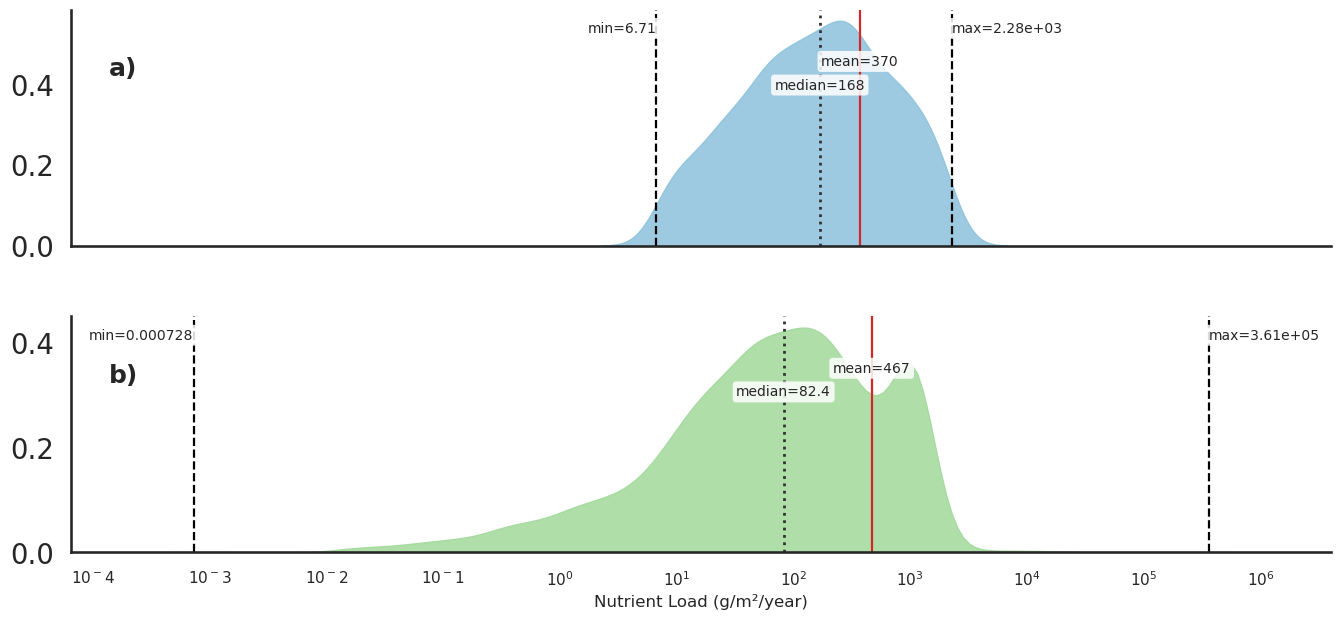

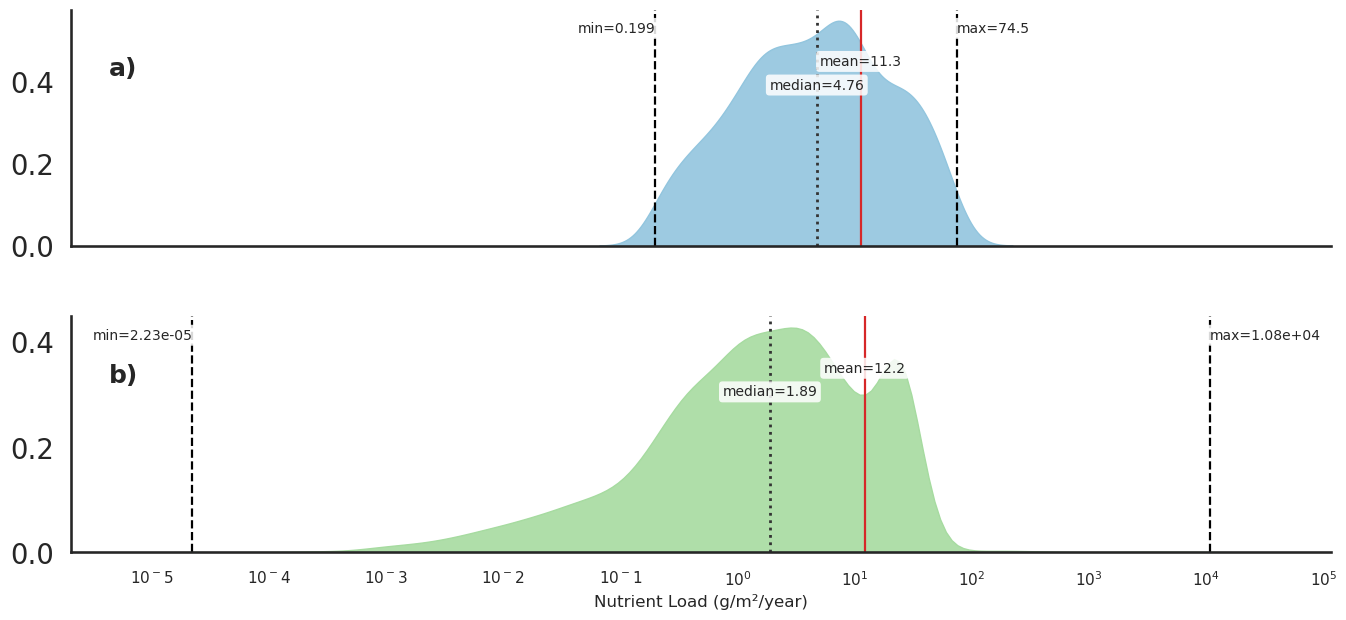

In [14]:
# ---------- Example call ----------
plot_ridge_loads(
    cat="avg",
    df=TotalLoad_CW_avg,
    include_total=False,      # True to add "Total" (labeled 'C')
    filter_indirect=True,
    output_figures=output_figures,
    fig_width=14,
    ridge_height=2.6,
    aspect=4.6,
    show_titles=False,         # titles OFF
)

### total TN over TP

In [21]:
def plot_total_TN_vs_TP(cat, df=None, output_figures="."):
    """
    Plot Total TN load over Total TP load for a given inundation category.

    Creates both:
    - A scatterplot (Total TP vs Total TN)
    - A histogram of the TN:TP ratio
    """

    if df is None:
        df = globals().get(f"TotalLoad_CW_{cat}")
        if df is None:
            raise ValueError(f"No dataframe found for category '{cat}'")

    tn_col = f"TotalN_{cat}_grm2yr"
    tp_col = f"TotalP_{cat}_grm2yr"

    if tn_col not in df.columns or tp_col not in df.columns:
        raise ValueError(f"Columns {tn_col} and/or {tp_col} not found in dataframe")

    # Filter out invalid/zero values
    data = df[[tn_col, tp_col]].dropna()
    data = data[(data[tn_col] > 0) & (data[tp_col] > 0)]

    # Compute N:P ratio
    data["N_to_P_ratio"] = data[tn_col] / data[tp_col]

    # ----------- PLOT -----------
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Scatterplot Total TN vs Total TP (log-log)
    ax = axes[0]
    sns.scatterplot(
        data=data,
        x=tp_col, y=tn_col,
        alpha=0.6, edgecolor="k", linewidth=0.3,
        ax=ax
    )
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("Total TP Load (g/m²/yr)")
    ax.set_ylabel("Total TN Load (g/m²/yr)")
    ax.set_title(f"Total TN vs Total TP ({cat})")

    # Add 1:1 line
    min_val = min(data[tp_col].min(), data[tn_col].min())
    max_val = max(data[tp_col].max(), data[tn_col].max())
    ax.plot([min_val, max_val], [min_val, max_val], "r--", lw=1, label="1:1 line")
    ax.legend()

    # Histogram of TN:TP ratio (log scale)
    ax2 = axes[1]
    sns.histplot(np.log10(data["N_to_P_ratio"]), bins=30, kde=True, ax=ax2, color="purple")
    ax2.set_xlabel("log10(TN/TP)")
    ax2.set_ylabel("Count")
    ax2.set_title("Distribution of N:P ratio")

    plt.tight_layout()
    outpath = f"{output_figures}/Total_TN_vs_TP_{cat}.png"
    plt.savefig(outpath, dpi=300, bbox_inches="tight")
    print(f"✅ Saved: {outpath}")
    plt.show()

✅ Saved: /home/abolmaal/modelling/FVCOM/Huron/Figures/Total_TN_vs_TP_avg.png


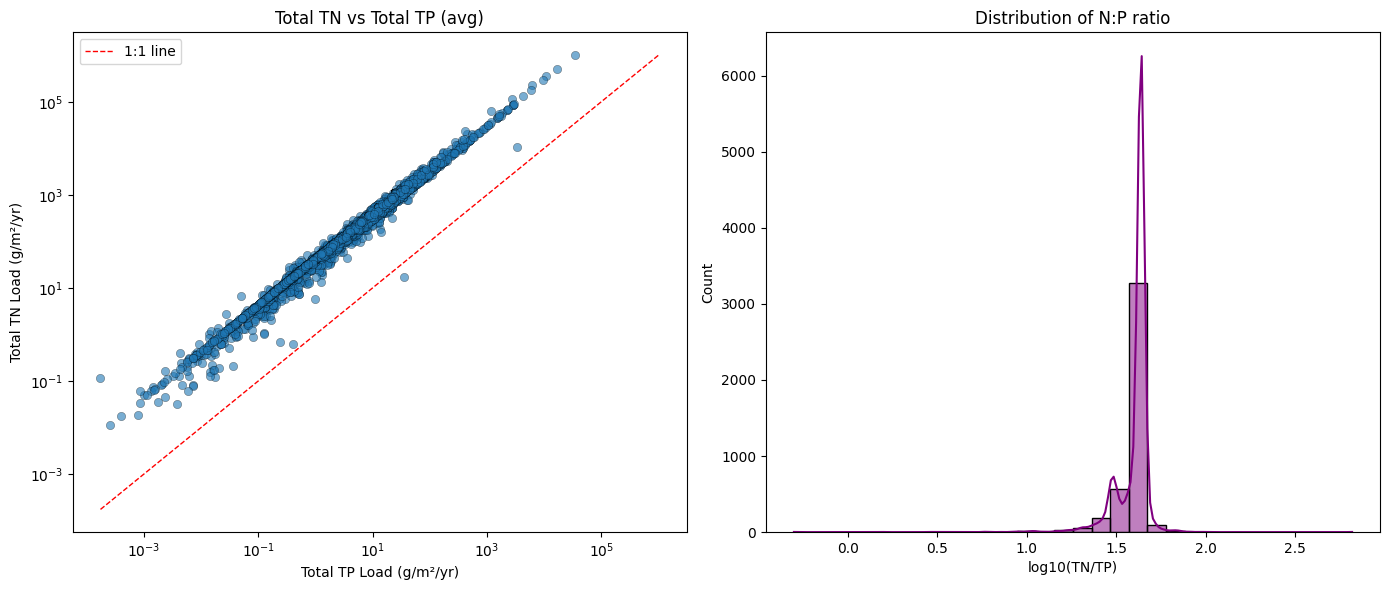

In [23]:
import seaborn as sns
plot_total_TN_vs_TP(cat="avg", output_figures=output_figures)


In [ ]:
def plot_total_TN_vs_TP(cat, df=None, output_figures="."):
    """
    Plot Total TN load over Total TP load for a given inundation category.

    Creates both:
    - A scatterplot (Total TP vs Total TN)
    - A histogram of the TN:TP ratio
    """

    if df is None:
        df = globals().get(f"TotalLoad_CW_{cat}")
        if df is None:
            raise ValueError(f"No dataframe found for category '{cat}'")

    tn_col = f"TotalN_{cat}_grm2yr"
    tp_col = f"TotalP_{cat}_grm2yr"

    if tn_col not in df.columns or tp_col not in df.columns:
        raise ValueError(f"Columns {tn_col} and/or {tp_col} not found in dataframe")

    # Filter out invalid/zero values
    data = df[[tn_col, tp_col]].dropna()
    data = data[(data[tn_col] > 0) & (data[tp_col] > 0)]

    # Compute N:P ratio
    data["N_to_P_ratio"] = data[tn_col] / data[tp_col]

    # ----------- PLOT -----------
    fig= uplt.figure(share = False)

    # Scatterplot Total TN vs Total TP (log-log)
    ax = fig.subplot(121)
    ax.scatter(
        data=data,cycle=cycle,
    )
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("Total TP Load (g/m²/yr)")
    ax.set_ylabel("Total TN Load (g/m²/yr)")
    ax.set_title(f"Total TN vs Total TP ({cat})")

    # Add 1:1 line
    min_val = min(data[tp_col].min(), data[tn_col].min())
    max_val = max(data[tp_col].max(), data[tn_col].max())
    ax.plot([min_val, max_val], [min_val, max_val], "r--", lw=1, label="1:1 line")
    ax.legend()

    # Histogram of TN:TP ratio (log scale)
    ax2 = axes[1]
    sns.histplot(np.log10(data["N_to_P_ratio"]), bins=30, kde=True, ax=ax2, color="purple")
    ax2.set_xlabel("log10(TN/TP)")
    ax2.set_ylabel("Count")
    ax2.set_title("Distribution of N:P ratio")

    plt.tight_layout()
    outpath = f"{output_figures}/Total_TN_vs_TP_{cat}.png"
    plt.savefig(outpath, dpi=300, bbox_inches="tight")
    print(f"✅ Saved: {outpath}")
    plt.show()

### Bivariate plot 

In [23]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize
import geopandas as gpd
from shapely.geometry import box
from matplotlib.patches import Rectangle
import matplotlib.ticker as mticker
GL_ALBERS = "EPSG:3174"   # NAD83 / Great Lakes Albers Equal Area

# ---------- helpers ----------
def _load_gdf(src):
    if src is None:
        return None
    if isinstance(src, gpd.GeoDataFrame):
        return src.copy()
    if isinstance(src, str):
        return gpd.read_file(src)
    if isinstance(src, dict):
        return gpd.GeoDataFrame.from_features(src["features"], crs="EPSG:4326")
    raise TypeError(f"Unsupported type for geodata source: {type(src)}")

def _to_3174(gdf: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    if gdf is None:
        return None
    if gdf.crs is None:
        raise ValueError("No CRS defined, set it first")
    return gdf.to_crs(GL_ALBERS)

def _project_extent_4326_to_3174(extent_ll):
    """[minlon,maxlon,minlat,maxlat] (EPSG:4326) → [minx,maxx,miny,maxy] in EPSG:3174 (m)."""
    minlon, maxlon, minlat, maxlat = extent_ll
    bbox_ll = gpd.GeoSeries([box(minlon, minlat, maxlon, maxlat)], crs="EPSG:4326")
    minx, miny, maxx, maxy = bbox_ll.to_crs(GL_ALBERS).total_bounds
    return [minx, maxx, miny, maxy]

def _get_cmap():
    # Use your colormaps package if present; else fall back to Matplotlib.
    try:
        import colormaps as cmaps
        return cmaps.ylorrd
    except Exception:
        return matplotlib.colormaps.get_cmap("YlOrRd")
# --- add these helpers near the top of your file ---
def _proj_box_4326_to_3174(ext_ll):
    minx, maxx, miny, maxy = _project_extent_4326_to_3174(ext_ll)
    return [minx, maxx, miny, maxy]


def _proj_box_4326_to_3174(ext_ll):
    minx, maxx, miny, maxy = _project_extent_4326_to_3174(ext_ll)
    return [minx, maxx, miny, maxy]

def _equalize_proj_boxes(boxes_proj, mode="first"):
    """
    Force all projected boxes to same W,H.
    mode='first' uses first box size; mode='max' uses max W/H across all.
    """
    if not boxes_proj: return boxes_proj
    widths  = [bx[1]-bx[0] for bx in boxes_proj]
    heights = [bx[3]-bx[2] for bx in boxes_proj]
    if mode == "max":
        W, H = max(widths), max(heights)
    else:
        W, H = widths[0], heights[0]

    out = []
    for xmin, xmax, ymin, ymax in boxes_proj:
        cx, cy = 0.5*(xmin+xmax), 0.5*(ymin+ymax)
        out.append([cx - W/2, cx + W/2, cy - H/2, cy + H/2])
    return out

def _fit_box_to_ratio(fig_box, target_ratio):
    """
    Adjust a figure box [l,b,w,h] so that w/h == target_ratio, keeping its center fixed.
    """
    l, b, w, h = fig_box
    c_x, c_y = l + w/2, b + h/2
    # choose to modify width to match ratio
    new_w = h * target_ratio
    return [c_x - new_w/2, c_y - h/2, new_w, h]
#######
def _equalize_proj_boxes(boxes_proj, mode="first"):
    """
    boxes_proj: list of [xmin,xmax,ymin,ymax] in EPSG:3174
    mode: 'first' -> use w,h of box0; 'max' -> use max w,h across all
    """
    if not boxes_proj: return boxes_proj
    ws = [bx[1]-bx[0] for bx in boxes_proj]
    hs = [bx[3]-bx[2] for bx in boxes_proj]
    if mode == "max":
        W, H = max(ws), max(hs)
    else:  # 'first'
        W, H = ws[0], hs[0]

    out = []
    for (xmin, xmax, ymin, ymax) in boxes_proj:
        cx, cy = 0.5*(xmin+xmax), 0.5*(ymin+ymax)
        out.append([cx - W/2, cx + W/2, cy - H/2, cy + H/2])
    return out

def _hide_axes_ticks(ax):
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.tick_params(which="both", length=0, labelbottom=False, labelleft=False)
    ax.get_xaxis().get_offset_text().set_visible(False)
    ax.get_yaxis().get_offset_text().set_visible(False)
    # (optional) also remove any auto locators/formatters
    ax.xaxis.set_major_locator(mticker.NullLocator())
    ax.yaxis.set_major_locator(mticker.NullLocator())
# ------------------ main function ------------------
def plot_TN_over_TP(
    cat,
    Lakes=None,
    Counties=None,
    font_size=12,
    title=None,
    output_figures='.',
    extent=[-84.5, -81, 42.5, 46.5],   # default Huron region (lon/lat)

    # ---- ZOOMS (lon/lat → projected) ----
    zoom_extents_ll=None,               # list of [minlon,maxlon,minlat,maxlat]
    zoom_boxes=None,                    # list of [left,bottom,width,height] in figure coords
    zoom_edgecolor="#0c0b0b",
    zoom_lw=0.1,                        # thinner locator boxes on the map
    zoom_facealpha=0.0,
    zoom_antialiased=False,
    zoom_add_halo=True,
    zoom_halo_extra=0.9,               # smaller halo to match thinner box
    zoom_hatch=None,

    # Make one inset bigger (the “outside the map” one)
    big_inset_index=0,                  # which inset to enlarge (0-based). Set None to disable.
    big_inset_scale=1.6,                # multiply width & height for that inset

    # ---- export ----
    dpi_out=600,
    year=None
):
    """
    Bivariate TN–TP map with crisp thin zoom boxes and one enlarged inset placed outside the map.
    Colors use cmaps.ylorrd (or Matplotlib YlOrRd fallback) with a 50/50 blend of normalized
    log10(TN) and log10(TP). A 2-D legend shows the bivariate mapping.
    """

    # Load dataframe
    df = globals().get(f'TotalLoad_CW_{cat}')
    if df is None:
        raise ValueError(f"No dataframe found for {cat}")

    tn_col = f"TotalN_{cat}_grm2yr"
    tp_col = f"TotalP_{cat}_grm2yr"
    if tn_col not in df or tp_col not in df:
        raise ValueError(f"Missing {tn_col} or {tp_col} in dataframe")

    # Clean rows
    df = df[(df['start_lon'] != 0.0) & (df['start_lat'] != 0.0)].dropna(subset=[tn_col, tp_col])

    # Project points
    pts = gpd.GeoDataFrame(
        df, geometry=gpd.points_from_xy(df['start_lon'], df['start_lat']), crs="EPSG:4326"
    ).to_crs(GL_ALBERS)

    # Apply extent
    minx, maxx, miny, maxy = _project_extent_4326_to_3174(extent)
    pts = pts.cx[minx:maxx, miny:maxy]
    if pts.empty:
        raise ValueError("No points left after applying extent")

    # Bivariate normalization: log10 then percentile-based scaling for both variables
    tn = np.log10(pts[tn_col].astype(float).values + 1e-6)
    tp = np.log10(pts[tp_col].astype(float).values + 1e-6)
    tn_norm = Normalize(vmin=np.nanpercentile(tn, 10),  vmax=np.nanpercentile(tn, 90))
    tp_norm = Normalize(vmin=np.nanpercentile(tp, 10),  vmax=np.nanpercentile(tp, 90))

    # Bivariate blend (simple 50/50 mix through one sequential palette)
    #cmap = _get_cmap()
    cmap = cmaps.rdylgn
    mix = 0.5 * (tn_norm(tn) + tp_norm(tp))
    colors = cmap(np.clip(mix, 0, 1))

    # Plot
    fig, ax = plt.subplots(figsize=(6.69, 5))

    if Counties is not None:
        _to_3174(_load_gdf(Counties)).plot(ax=ax, facecolor="lightgray", edgecolor="black", lw=0.5, zorder=0.7)

    if Lakes is not None:
        _to_3174(_load_gdf(Lakes)).plot(ax=ax, facecolor="#bcdcf6", edgecolor="#2a75a5", alpha=0.7, lw=0.6, zorder=0.6)

    ax.scatter(pts.geometry.x, pts.geometry.y, c=colors, s=35, alpha=0.97,
               edgecolor="black", lw=0.25, zorder=1.0)
    ax.set_aspect("equal")
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)
    _hide_axes_ticks(ax)

    # -------- Bivariate legend (2-D) --------
    leg_ax = fig.add_axes([0.77, 0.13, 0.20, 0.22])  # [x0,y0,w,h] fig coords
    n = 90
    tn_vals = np.linspace(tn_norm.vmin, tn_norm.vmax, n)
    tp_vals = np.linspace(tp_norm.vmin, tp_norm.vmax, n)
    legend_img = np.zeros((n, n, 4))
    for i, t in enumerate(tn_vals):
        for j, p in enumerate(tp_vals):
            legend_img[i, j] = cmap(0.5 * (tn_norm(t) + tp_norm(p)))
    leg_ax.imshow(
        legend_img, origin="upper",
        extent=[tp_norm.vmin, tp_norm.vmax, tn_norm.vmin, tn_norm.vmax],
        aspect="auto"
    )
    leg_ax.set_xlabel("TP (gr m$^{-2}$ yr$^{-1}$)", fontsize=8)
    leg_ax.set_ylabel("TN (gr m$^{-2}$ yr$^{-1}$)", fontsize=8)

   # ==================== ZOOM INSETS ====================
    if zoom_extents_ll:
        # 1) project all requested lon/lat boxes to EPSG:3174
        zboxes_proj = [_proj_box_4326_to_3174(ex) for ex in zoom_extents_ll]

        # 2) force SAME map extent (width & height) for every inset (and locator)
        zboxes_proj = _equalize_proj_boxes(zboxes_proj, mode="first")
        W = zboxes_proj[0][1] - zboxes_proj[0][0]
        H = zboxes_proj[0][3] - zboxes_proj[0][2]
        data_ratio = W / H  # must match inset axes *box* ratio for identical visual size

        # 3) default figure positions if not provided
        if zoom_boxes is None:
            zoom_boxes = []
            top = 0.80
            for _ in zboxes_proj:
                zoom_boxes.append([0.73, top, 0.23, 0.18])  # [left,bottom,width,height]
                top -= 0.22

        # 4) make one inset bigger (optional)
        if big_inset_index is not None and 0 <= big_inset_index < len(zoom_boxes):
            l, b, w, h = zoom_boxes[big_inset_index]
            zoom_boxes[big_inset_index] = [l, b, w*big_inset_scale, h*big_inset_scale]

        # 5) adjust every inset figure box to have the SAME aspect ratio as the data
        zoom_boxes = [_fit_box_to_ratio(box, data_ratio) for box in zoom_boxes]

        # 6) draw each inset + its thin locator on the main map
        for (zxmin, zxmax, zymin, zymax), box_spec in zip(zboxes_proj, zoom_boxes):
            # thin crisp locator rectangle on main map
            if zoom_add_halo:
                ax.add_patch(Rectangle(
                    (zxmin, zymin), W, H, fill=False, edgecolor="black",
                    linewidth=zoom_lw + zoom_halo_extra, antialiased=zoom_antialiased,
                    zorder=9.8, joinstyle="miter", capstyle="butt"
                ))
            ax.add_patch(Rectangle(
                (zxmin, zymin), W, H, fill=False, edgecolor=zoom_edgecolor,
                linewidth=zoom_lw, antialiased=zoom_antialiased, zorder=10.0,
                joinstyle="miter", capstyle="butt"
            ))

            # inset axes
            iax = fig.add_axes(box_spec)
            for sp in iax.spines.values():
                sp.set_color(zoom_edgecolor); sp.set_linewidth(max(1.0, zoom_lw+0.4))

            # background layers (clipped)
            if Counties is not None:
                cnt = _to_3174(_load_gdf(Counties)).cx[zxmin:zxmax, zymin:zymax]
                if not cnt.empty:
                    cnt.plot(ax=iax, facecolor="lightgray", edgecolor="black", lw=0.4, zorder=0.5)
            if Lakes is not None:
                lak = _to_3174(_load_gdf(Lakes)).cx[zxmin:zxmax, zymin:zymax]
                if not lak.empty:
                    lak.plot(ax=iax, facecolor="#bcdcf6", edgecolor="#2a75a5", alpha=0.7, lw=0.5, zorder=0.6)

            # points (same bivariate colors computed earlier)
            pts_z = pts.cx[zxmin:zxmax, zymin:zymax]
            if not pts_z.empty:
                tn_z = np.log10(pts_z[tn_col].astype(float).values + 1e-6)
                tp_z = np.log10(pts_z[tp_col].astype(float).values + 1e-6)
                mix_z = 0.5 * (tn_norm(tn_z) + tp_norm(tp_z))
                iax.scatter(pts_z.geometry.x, pts_z.geometry.y,
                            c=cmap(np.clip(mix_z, 0, 1)), s=42, alpha=0.98,
                            edgecolor="black", lw=0.25, zorder=1.0)

            iax.set_xlim(zxmin, zxmax); iax.set_ylim(zymin, zymax)
            iax.set_aspect("equal")
            _hide_axes_ticks(iax)
            iax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
# =====================================================
# =====================================================
    # =====================================================

    if title:
        ax.set_title(title, fontsize=font_size+2)

    outpath = f"{output_figures}/Bivariate_TNoverTP_{cat}{'_'+str(year) if year else ''}.jpeg"
    plt.savefig(outpath, dpi=dpi_out, bbox_inches="tight")
    print(f"✅ Saved {outpath}")
    plt.show()


✅ Saved /home/abolmaal/modelling/FVCOM/Huron/Figures/Bivariate_TNoverTP_avg_23.jpeg


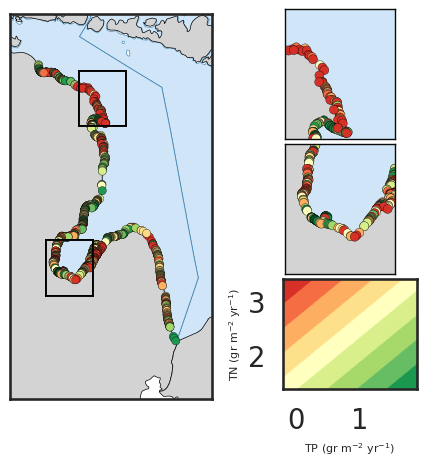

✅ Saved /home/abolmaal/modelling/FVCOM/Huron/Figures/Bivariate_TNoverTP_high_23.jpeg


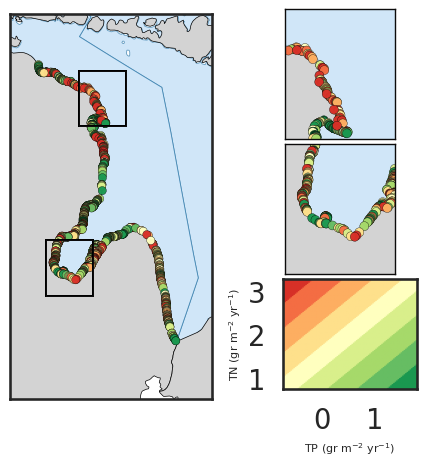

✅ Saved /home/abolmaal/modelling/FVCOM/Huron/Figures/Bivariate_TNoverTP_low_23.jpeg


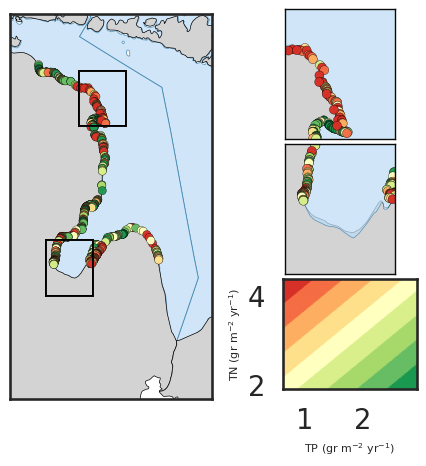

✅ Saved /home/abolmaal/modelling/FVCOM/Huron/Figures/Bivariate_TNoverTP_surge_23.jpeg


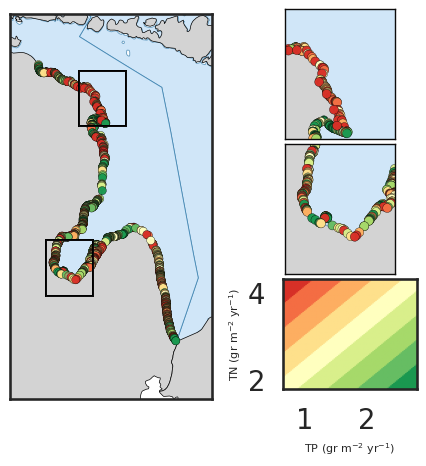

In [24]:
for cat in ["avg","high","low","surge"]:
    plot_TN_over_TP(
        cat,
        Counties=counties, Lakes=Huron,
        extent=[-84.5, -82, 42.5, 46],
        zoom_extents_ll=[[-83.6,-83.0,45,45.5], [-83.9,-83.6,43.5,43.9]],
        zoom_boxes=[[0.73,0.63,0.25,0.26], [0.73,0.36,0.25,0.26]],
        big_inset_index=None,
        zoom_lw=0.4, year=year, output_figures=output_figures
    )

In [46]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import geopandas as gpd
from shapely.geometry import box

GL_ALBERS = "EPSG:3174"  # Great Lakes Albers

def _load_gdf(src):
    if src is None: return None
    if isinstance(src, gpd.GeoDataFrame): return src.copy()
    if isinstance(src, str): return gpd.read_file(src)
    if isinstance(src, dict): return gpd.GeoDataFrame.from_features(src["features"], crs="EPSG:4326")
    raise TypeError(f"Unsupported geodata source: {type(src)}")

def _to_3174(gdf):
    if gdf is None: return None
    if gdf.crs is None: raise ValueError("No CRS on layer")
    return gdf.to_crs(GL_ALBERS)

def _proj_extent_4326_to_3174(ext_ll):
    minlon, maxlon, minlat, maxlat = ext_ll
    gs = gpd.GeoSeries([box(minlon, minlat, maxlon, maxlat)], crs="EPSG:4326")
    minx, miny, maxx, maxy = gs.to_crs(GL_ALBERS).total_bounds
    return [minx, maxx, miny, maxy]

def _hide_axes_ticks(ax):
    ax.set_xlabel(""); ax.set_ylabel("")
    ax.set_xticks([]); ax.set_yticks([])
    ax.tick_params(which="both", length=0, labelbottom=False, labelleft=False)
    ax.get_xaxis().get_offset_text().set_visible(False)
    ax.get_yaxis().get_offset_text().set_visible(False)

def plot_TN_TP_ratio_diverging(
    cat,
    Lakes=None,
    Counties=None,
    extent=[-84.5, -81.0, 42.5, 46.5],
    title=None,
    output_figures=".",
    year=None,
    vclip_pct=(5, 95),          # robust range selector on log10 ratio
    diverge_cmap=None,          # None-> try cmocean.balance, else 'coolwarm'
    point_size=36,
    dpi_out=600,
):
    """
    Plot log10(TN/TP) with a diverging colormap centered at 0 (TwoSlopeNorm).
    Red -> TN-dominant; Blue -> TP-dominant; White -> ~1:1.
    """

    # ---- data ----
    df = globals().get(f"TotalLoad_CW_{cat}")
    if df is None:
        raise ValueError(f"No dataframe found for category '{cat}'")

    tn_col = f"TotalN_{cat}_grm2yr"
    tp_col = f"TotalP_{cat}_grm2yr"
    for c in (tn_col, tp_col):
        if c not in df.columns:
            raise ValueError(f"Missing column: {c}")

    # keep valid coordinates
    df = df[(df.start_lon != 0.0) & (df.start_lat != 0.0)].dropna(subset=[tn_col, tp_col]).copy()

    # project points to 3174
    pts = gpd.GeoDataFrame(
        df, geometry=gpd.points_from_xy(df.start_lon, df.start_lat), crs="EPSG:4326"
    ).to_crs(GL_ALBERS)

    # apply extent
    minx, maxx, miny, maxy = _proj_extent_4326_to_3174(extent)
    pts = pts.cx[minx:maxx, miny:maxy]
    if pts.empty:
        raise ValueError("No points in selected extent.")

    # ---- symmetric metric: log10(TN/TP) ----
    eps = 1e-9  # extra safe epsilon
    ratio_log10 = np.log10((pts[tn_col].astype(float).values + eps) /
                           (pts[tp_col].astype(float).values + eps))

    # robust symmetric limits around 0
    p_lo, p_hi = np.nanpercentile(ratio_log10, vclip_pct)
    L = max(abs(p_lo), abs(p_hi))  # symmetric span
    if not np.isfinite(L) or L <= 0:
        L = 1.0  # fallback
    vmin, vcenter, vmax = -L, 0.0, +L
    norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)

    # colormap
    if diverge_cmap is None:
        try:
            import cmocean  # noqa: F401
            diverge_cmap = matplotlib.colormaps.get_cmap("cmo.balance")  # name exposed by cmocean
        except Exception:
            diverge_cmap = matplotlib.colormaps.get_cmap("coolwarm")

    # ---- plot ----
    fig, ax = plt.subplots(figsize=(6.69, 5.0))

    if Counties is not None:
        _to_3174(_load_gdf(Counties)).plot(ax=ax, facecolor="#d4d9e0", edgecolor="black", lw=0.5, zorder=0.5)
    if Lakes is not None:
        _to_3174(_load_gdf(Lakes)).plot(ax=ax, facecolor="#bcd7ff", edgecolor="#5b7aa6", lw=0.6, alpha=0.9, zorder=0.6)

    sc = ax.scatter(
        pts.geometry.x, pts.geometry.y,
        c=ratio_log10, cmap=diverge_cmap, norm=norm,
        s=point_size, edgecolor="black", lw=0.25, alpha=0.98, zorder=1.0
    )

    ax.set_aspect("equal"); ax.set_xlim(minx, maxx); ax.set_ylim(miny, maxy)
    _hide_axes_ticks(ax)

    if title:
        ax.set_title(title, fontsize=14)

    # ---- colorbar with helpful ticks (map back to ratios) ----
    cax = fig.add_axes([0.88, 0.18, 0.025, 0.62])  # right-side slim bar
    cb = fig.colorbar(sc, cax=cax)
    cb.set_label(r'$\log_{10}(\mathrm{TN}/\mathrm{TP})$')

    # nice symmetric ticks around 0 → show also the ratio values
    ticks = np.array([vmin, -L/2, -0.3, 0.0, 0.3, L/2, vmax])
    ticks = ticks[(ticks >= vmin) & (ticks <= vmax)]
    cb.set_ticks(ticks)
    # secondary labels (optional): ratio values under the ticks
    # Example textual labels like 0.5×, 1×, 2×:
    tick_labels = []
    for t in ticks:
        r = 10**t
        if np.isclose(r, 1.0, atol=1e-2):
            tick_labels.append("1×")
        elif r < 1:
            tick_labels.append(f"{r:.2f}×")
        else:
            tick_labels.append(f"{r:.1f}×")
    cb.ax.set_yticklabels([f"{tl}\n({t:.2f})" for tl, t in zip(tick_labels, ticks)])

    # ---- save ----
    out = f"{output_figures}/TN_TP_ratio_diverging_{cat}{'_'+str(year) if year else ''}.jpeg"
    plt.savefig(out, dpi=dpi_out, bbox_inches="tight")
    print(f"✅ Saved {out}")
    plt.show()


In [25]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.patches import Rectangle
import geopandas as gpd
from shapely.geometry import box

GL_ALBERS = "EPSG:3174"   # NAD83 / Great Lakes Albers Equal Area

# ---------------- helpers ----------------
def _load_gdf(src):
    if src is None: return None
    if isinstance(src, gpd.GeoDataFrame): return src.copy()
    if isinstance(src, str): return gpd.read_file(src)
    if isinstance(src, dict): return gpd.GeoDataFrame.from_features(src["features"], crs="EPSG:4326")
    raise TypeError(f"Unsupported type: {type(src)}")

def _to_3174(gdf):
    if gdf is None: return None
    if gdf.crs is None: raise ValueError("No CRS on layer; set it first")
    return gdf.to_crs(GL_ALBERS)

def _project_extent_4326_to_3174(ext_ll):
    minlon, maxlon, minlat, maxlat = ext_ll
    bbox_ll = gpd.GeoSeries([box(minlon, minlat, maxlon, maxlat)], crs="EPSG:4326")
    minx, miny, maxx, maxy = bbox_ll.to_crs(GL_ALBERS).total_bounds
    return [minx, maxx, miny, maxy]

def _proj_box_4326_to_3174(ext_ll):
    return _project_extent_4326_to_3174(ext_ll)

def _equalize_proj_boxes(boxes_proj, mode="first"):
    if not boxes_proj: return boxes_proj
    ws = [b[1]-b[0] for b in boxes_proj]
    hs = [b[3]-b[2] for b in boxes_proj]
    W = ws[0] if mode == "first" else max(ws)
    H = hs[0] if mode == "first" else max(hs)
    out = []
    for xmin, xmax, ymin, ymax in boxes_proj:
        cx, cy = 0.5*(xmin+xmax), 0.5*(ymin+ymax)
        out.append([cx-W/2, cx+W/2, cy-H/2, cy+H/2])
    return out

def _fit_box_to_ratio(fig_box, target_ratio):
    l, b, w, h = fig_box
    cx, cy = l + w/2, b + h/2
    new_w = h * target_ratio
    return [cx - new_w/2, cy - h/2, new_w, h]

def _bilinear_rgba(x, y, cLL, cLR, cUL, cUR):
    """
    Bilinear mix of corner RGBA colors.
    - x: TP normalized in [0,1]  (→ right)
    - y: TN normalized in [0,1]  (↑ up)
    Returns an array with shape x.shape + (4,)
    """
    x = np.clip(np.asarray(x, float), 0, 1)
    y = np.clip(np.asarray(y, float), 0, 1)

    wLL = (1 - x) * (1 - y)
    wLR = x * (1 - y)
    wUL = (1 - x) * y
    wUR = x * y

    r = wLL * cLL[0] + wLR * cLR[0] + wUL * cUL[0] + wUR * cUR[0]
    g = wLL * cLL[1] + wLR * cLR[1] + wUL * cUL[1] + wUR * cUR[1]
    b = wLL * cLL[2] + wLR * cLR[2] + wUL * cUL[2] + wUR * cUR[2]
    a = wLL * cLL[3] + wLR * cLR[3] + wUL * cUL[3] + wUR * cUR[3]

    rgba = np.stack([r, g, b, a], axis=-1)
    return np.clip(np.nan_to_num(rgba, nan=0.0, posinf=1.0, neginf=0.0), 0.0, 1.0)


# ---------------- main ----------------
def plot_TN_over_TP_bivariate(
    cat,
    Lakes=None, Counties=None,
    font_size=6, title=None,
    output_figures='.', extent=[-84.5, -81, 42.5, 46.5],
    zoom_extents_ll=None,        # [[minlon,maxlon,minlat,maxlat], ...]
    zoom_boxes=None,             # [[left,bottom,width,height], ...] in fig coords
    equalize_zoom_extents=True,
    big_inset_index=None, big_inset_scale=1.6,
    zoom_edgecolor="black", zoom_lw=1.0, zoom_halo=0.8,
    dpi_out=600, year=None,
    debug=False
):
    # ==== data ====
    df = globals().get(f"TotalLoad_CW_{cat}")
    if df is None:
        raise ValueError(f"No dataframe found for {cat}")
    tn_col = f"TotalN_{cat}_grm2yr"
    tp_col = f"TotalP_{cat}_grm2yr"
    if tn_col not in df or tp_col not in df:
        raise ValueError(f"Missing {tn_col} or {tp_col} in dataframe")

    df = df[(df.start_lon != 0.0) & (df.start_lat != 0.0)].dropna(subset=[tn_col, tp_col])
    pts = gpd.GeoDataFrame(
        df, geometry=gpd.points_from_xy(df.start_lon, df.start_lat), crs="EPSG:4326"
    ).to_crs(GL_ALBERS)

    # extent
    minx, maxx, miny, maxy = _project_extent_4326_to_3174(extent)
    pts = pts.cx[minx:maxx, miny:maxy]
    if pts.empty:
        raise ValueError("No points in the requested extent")

    # log10 + validity filter
    tn_raw = np.log10(pts[tn_col].astype(float).values + 1e-6)
    tp_raw = np.log10(pts[tp_col].astype(float).values + 1e-6)
    valid = np.isfinite(tn_raw) & np.isfinite(tp_raw)
    pts_v = pts.iloc[valid].copy()
    tn = tn_raw[valid]; tp = tp_raw[valid]

    if pts_v.empty:
        raise ValueError("All points became invalid after filtering")

    # percentile normalization (5–95)
    tnN = Normalize(vmin=np.nanpercentile(tn, 5), vmax=np.nanpercentile(tn, 95))
    tpN = Normalize(vmin=np.nanpercentile(tp, 5), vmax=np.nanpercentile(tp, 95))
    tn_n = np.clip(tnN(tn).astype(float), 0.0, 1.0)
    tp_n = np.clip(tpN(tp).astype(float), 0.0, 1.0)

    # corner colors (blue, yellow, green, red)
    cLL = (0.10, 0.28, 0.73, 1.0)  # low TP, low TN
    cLR = (0.98, 0.90, 0.20, 1.0)  # high TP, low TN
    cUL = (0.10, 0.60, 0.24, 1.0)  # low TP, high TN
    cUR = (0.88, 0.18, 0.18, 1.0)  # high TP, high TN

    colors = _bilinear_rgba(tp_n, tn_n, cLL, cLR, cUL, cUR)  # x=TP, y=TN

    # optional sanity
    if debug:
        print("N points:", len(pts_v), "colors shape:", colors.shape,
              "min/max:", colors.min(), colors.max(),
              "nonfinite:", np.any(~np.isfinite(colors)))

    # ==== plot base ====
    fig, ax = plt.subplots(figsize=(6.9, 5.3))
    if Counties is not None:
        _to_3174(_load_gdf(Counties)).plot(ax=ax, facecolor="#cfd3d8", edgecolor="black", lw=0.5, zorder=0.5)
    if Lakes is not None:
        _to_3174(_load_gdf(Lakes)).plot(ax=ax, facecolor="#bcd7ff", edgecolor="#5b7aa6", lw=0.6, alpha=0.9, zorder=0.6)

    # IMPORTANT: plot the filtered points (pts_v) with the same-length colors
    x = pts_v.geometry.x.values
    y = pts_v.geometry.y.values
    ax.scatter(x, y, c=colors, s=36, edgecolor="black", lw=0.25, alpha=0.98, zorder=1.0)

    ax.set_aspect("equal"); ax.set_xlim(minx, maxx); ax.set_ylim(miny, maxy)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    ax.get_xaxis().get_offset_text().set_visible(False)
    ax.get_yaxis().get_offset_text().set_visible(False)
    if title: ax.set_title(title, fontsize=font_size+2)

    # ==== 2-D legend ====
    leg_ax = fig.add_axes([0.75, 0.12, 0.20, 0.22])
    n = 64
    gx = np.linspace(0, 1, n)   # TP →
    gy = np.linspace(0, 1, n)   # TN ↑
    XX, YY = np.meshgrid(gx, gy)
    leg_img = _bilinear_rgba(XX, YY, cLL, cLR, cUL, cUR)
    leg_ax.imshow(leg_img, origin="lower", extent=[0,1,0,1], aspect="auto")
    def _tick_fmt(norm):
        lo, hi = norm.vmin, norm.vmax
        return [f"{lo:.2f}", f"{0.5*(lo+hi):.2f}", f"{hi:.2f}"]
    leg_ax.set_xticks([0,0.5,1], _tick_fmt(tpN), fontsize=7)
    leg_ax.set_yticks([0,0.5,1], _tick_fmt(tnN), fontsize=7)
    leg_ax.set_xlabel(r"TP (gr m$^{-2}$ yr$^{-1}$)", fontsize=8)
    leg_ax.set_ylabel(r"TN (gr m$^{-2}$ yr$^{-1}$)", fontsize=8)
    for s in leg_ax.spines.values():
        s.set_linewidth(1.0); s.set_edgecolor("black")

    # ==== zooms ====
    if zoom_extents_ll:
        zproj = [_proj_box_4326_to_3174(z) for z in zoom_extents_ll]
        if equalize_zoom_extents: zproj = _equalize_proj_boxes(zproj, mode="first")
        W = zproj[0][1] - zproj[0][0]; H = zproj[0][3] - zproj[0][2]
        data_ratio = W / H

        if zoom_boxes is None:
            zoom_boxes = [[0.67, 0.70, 0.20, 0.22],
                          [0.67, 0.45, 0.20, 0.22]]
        if big_inset_index is not None and 0 <= big_inset_index < len(zoom_boxes):
            l, b, w, h = zoom_boxes[big_inset_index]
            zoom_boxes[big_inset_index] = [l, b, w*big_inset_scale, h*big_inset_scale]
        zoom_boxes = [_fit_box_to_ratio(zb, data_ratio) for zb in zoom_boxes]

        for (zxmin, zxmax, zymin, zymax), box_spec in zip(zproj, zoom_boxes):
            # locator on main map
            ax.add_patch(Rectangle((zxmin, zymin), W, H, fill=False, edgecolor="white",
                                   linewidth=zoom_lw+zoom_halo, zorder=9.8))
            ax.add_patch(Rectangle((zxmin, zymin), W, H, fill=False, edgecolor=zoom_edgecolor,
                                   linewidth=zoom_lw, zorder=10.0))

            iax = fig.add_axes(box_spec)
            for sp in iax.spines.values():
                sp.set_color("black"); sp.set_linewidth(1.2)

            if Counties is not None:
                cnt = _to_3174(_load_gdf(Counties)).cx[zxmin:zxmax, zymin:zymax]
                if not cnt.empty: cnt.plot(ax=iax, facecolor="#cfd3d8", edgecolor="black", lw=0.4, zorder=0.5)
            if Lakes is not None:
                lak = _to_3174(_load_gdf(Lakes)).cx[zxmin:zxmax, zymin:zymax]
                if not lak.empty: lak.plot(ax=iax, facecolor="#bcd7ff", edgecolor="#5b7aa6", lw=0.5, zorder=0.6)

            sub = pts_v.cx[zxmin:zxmax, zymin:zymax]
            if not sub.empty:
                tn_z = np.log10(sub[tn_col].astype(float).values + 1e-6)
                tp_z = np.log10(sub[tp_col].astype(float).values + 1e-6)
                ok = np.isfinite(tn_z) & np.isfinite(tp_z)
                if np.any(ok):
                    sub = sub.iloc[ok]
                    tn_nz = np.clip(tnN(tn_z[ok]).astype(float), 0, 1)
                    tp_nz = np.clip(tpN(tp_z[ok]).astype(float), 0, 1)
                    col_z = _bilinear_rgba(tp_nz, tn_nz, cLL, cLR, cUL, cUR)
                    iax.scatter(sub.geometry.x.values, sub.geometry.y.values,
                                c=col_z, s=42, edgecolor="black", lw=0.25, alpha=0.98, zorder=1.0)

            iax.set_xlim(zxmin, zxmax); iax.set_ylim(zymin, zymax)
            iax.set_aspect("equal")
            iax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

    # ==== save ====
    outpath = f"{output_figures}/Bivariate_TN_TP_{cat}{'_'+str(year) if year else ''}.jpeg"
    plt.savefig(outpath, dpi=dpi_out, bbox_inches="tight")
    print("✅ Saved:", outpath)
    plt.show()


✅ Saved: /home/abolmaal/modelling/FVCOM/Huron/Figures/Bivariate_TN_TP_avg_23.jpeg


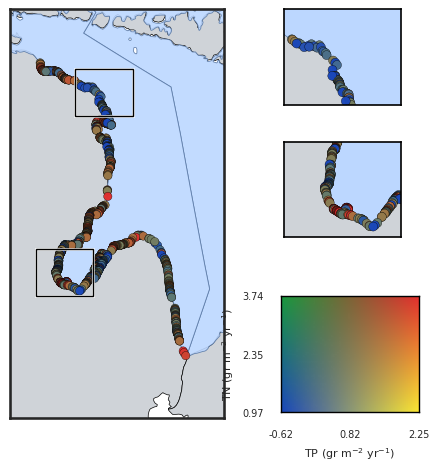

✅ Saved: /home/abolmaal/modelling/FVCOM/Huron/Figures/Bivariate_TN_TP_high_23.jpeg


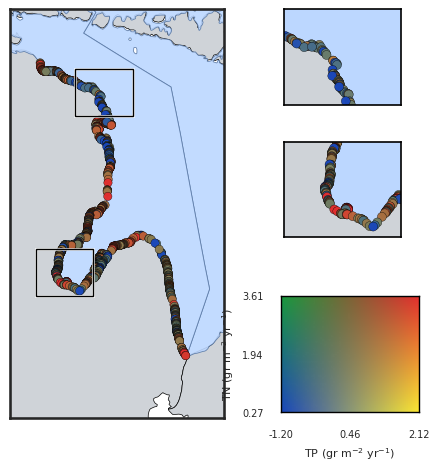

✅ Saved: /home/abolmaal/modelling/FVCOM/Huron/Figures/Bivariate_TN_TP_low_23.jpeg


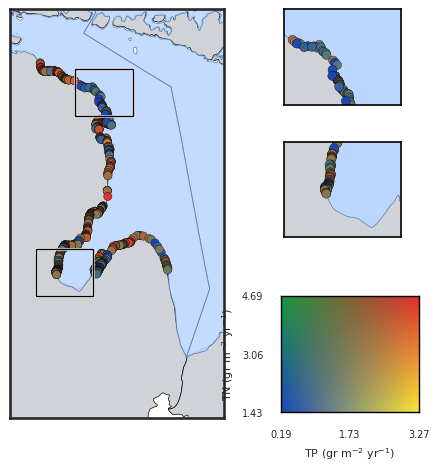

✅ Saved: /home/abolmaal/modelling/FVCOM/Huron/Figures/Bivariate_TN_TP_surge_23.jpeg


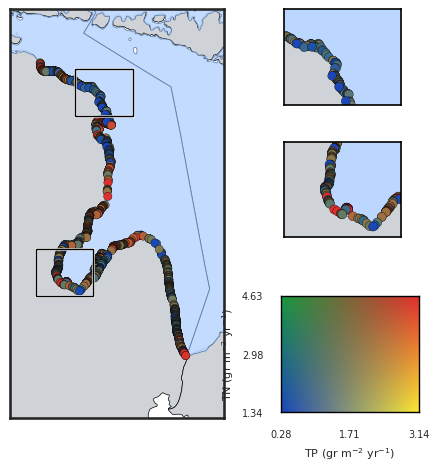

In [26]:
for cat in ["avg","high","low","surge"]:
    plot_TN_over_TP_bivariate(
        cat,
        Lakes=Huron, Counties=counties,
        extent=[-84.5, -82.0, 42.5, 46.0],
        zoom_extents_ll=[[-83.70,-83.00,45.10,45.50],
                         [-84.30,-83.40,43.50,44.00]],
        zoom_boxes=[[0.74,0.70,0.20,0.18],
                    [0.74,0.45,0.20,0.18]],
        big_inset_index=None,
        #title=f"TN–TP Bivariate ({cat})",
        output_figures=output_figures,
        year=year
    )

### Heat map 

In [59]:
# ========= TN/TP HEATMAP (EPSG:3174) with TP-dominance highlighting =========
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import Normalize, TwoSlopeNorm
from shapely.geometry import box
from matplotlib.ticker import ScalarFormatter

# Optional smoothing (kept off by default)
try:
    from scipy.ndimage import gaussian_filter
except Exception:
    gaussian_filter = None

GL_ALBERS = "EPSG:3174"   # NAD83 / Great Lakes Albers Equal Area

# ----------------- helpers -----------------
def _load_gdf(src):
    if src is None:
        return None
    if isinstance(src, gpd.GeoDataFrame):
        return src.copy()
    if isinstance(src, str):
        return gpd.read_file(src)
    if isinstance(src, dict):
        return gpd.GeoDataFrame.from_features(src["features"], crs="EPSG:4326")
    raise TypeError(f"Unsupported type for geodata source: {type(src)}")

def _to_3174(gdf: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    if gdf is None:
        return None
    if gdf.crs is None:
        raise ValueError("No CRS defined for a layer; set it before plotting.")
    return gdf.to_crs(GL_ALBERS)

def _project_extent_4326_to_3174(extent_ll):
    """[minlon, maxlon, minlat, maxlat] in EPSG:4326 → [minx, maxx, miny, maxy] in EPSG:3174 (m)."""
    minlon, maxlon, minlat, maxlat = extent_ll
    bbox_ll = gpd.GeoSeries([box(minlon, minlat, maxlon, maxlat)], crs="EPSG:4326")
    minx, miny, maxx, maxy = bbox_ll.to_crs(GL_ALBERS).total_bounds
    return [minx, maxx, miny, maxy]

# ----------------- main -----------------
def plot_TN_over_TP_heatmap(
    cat,
    Lakes=None,
    Counties=None,
    font_size=12,
    title=None,
    output_figures='.',
    extent=[-84.5, -81.0, 42.5, 46.5],   # lon/lat for the region
    cell_size_m=1000,                    # smaller → finer grid
    metric="ratio",                      # "ratio" (log10(TN/TP)) or "sumlog"
    agg="mean",                          # "mean" or "median" per cell
    min_points_per_cell=3,               # mask sparse cells
    min_mass=1e-6,                       # ignore extremely tiny TN/TP to avoid crazy ratios (g·m^-2·yr^-1)
    smoothing_sigma_cells=0.0,           # 0 = off (recommended when highlighting rare negatives)
    display_interpolation='nearest',     # 'nearest' keeps sharp squares; try 'bilinear' for softer look
    # --- contrast controls ---
    vmin_pct=5, vmax_pct=95,             # only used for "sumlog"; for "ratio" we use a fixed ±center_span
    center_span=0.25,                    # for "ratio": show ±center_span dex around 0 (e.g., 0.25 ≈ TN/TP 0.56–1.78)
    cmap_name=None,                      # override colormap; default coolwarm (ratio) / viridis (sumlog)
    # --- TP-dominance highlighting ---
    highlight_tp=True,                   # outline TP-dominant cells
    tp_threshold=0.02,                   # outline where log10(TN/TP) < -0.02 (~ TN/TP < 0.95)
    outline_color="#1f77b4",
    outline_lw=0.9,
    # --- output ---
    dpi_out=500,
    year=None
):
    """
    Rasterizes point TN/TP data into a heatmap in EPSG:3174.

    Expects a globals()[f'TotalLoad_CW_{cat}'] DataFrame with:
      - start_lon, start_lat (EPSG:4326)
      - TotalN_{cat}_grm2yr  (float, g·m^-2·yr^-1)
      - TotalP_{cat}_grm2yr  (float, g·m^-2·yr^-1)

    Key options for seeing rare TP-dominant spots:
      - center_span (tight symmetric color window around 0)
      - highlight_tp=True with tp_threshold≈0.02
      - smoothing_sigma_cells=0 and display_interpolation='nearest'
    """
    # ---- load data ----
    df = globals().get(f'TotalLoad_CW_{cat}')
    if df is None:
        raise ValueError(f"No dataframe found for {cat}")
    tn_col = f"TotalN_{cat}_grm2yr"
    tp_col = f"TotalP_{cat}_grm2yr"
    for col in (tn_col, tp_col, 'start_lon', 'start_lat'):
        if col not in df.columns:
            raise ValueError(f"Missing column: {col}")

    # ---- clean / project / clip ----
    df = df[(df['start_lon'] != 0.0) & (df['start_lat'] != 0.0)]
    df = df.dropna(subset=[tn_col, tp_col])
    if df.empty:
        raise ValueError("No valid TN/TP rows to plot")

    pts = gpd.GeoDataFrame(
        df, geometry=gpd.points_from_xy(df['start_lon'], df['start_lat']), crs="EPSG:4326"
    ).to_crs(GL_ALBERS)

    minx, maxx, miny, maxy = _project_extent_4326_to_3174(extent)
    pts = pts.cx[minx:maxx, miny:maxy]
    if pts.empty:
        raise ValueError("No points left after applying extent")

    # ---- per-point metric ----
    eps = 1e-12
    if metric == "ratio":
        # log10(TN/TP) and significance mask to avoid tiny-denominator explosions
        tnv = pts[tn_col].astype(float).values
        tpv = pts[tp_col].astype(float).values
        val = np.log10((tnv + eps) / (tpv + eps))
        sig = (tnv > min_mass) & (tpv > min_mass)
        val = np.where(sig, val, np.nan)

        # tight symmetric window around 0 so small TP-dominant cells show
        vmin, vmax = -center_span, +center_span
        norm = TwoSlopeNorm(vcenter=0.0, vmin=vmin, vmax=vmax)
        cmap = mpl.colormaps.get_cmap(cmap_name or "coolwarm")
        cbar_label = r"$\log_{10}(\mathrm{TN}/\mathrm{TP})$"
    elif metric == "sumlog":
        tn_log = np.log10(pts[tn_col].astype(float).values + eps)
        tp_log = np.log10(pts[tp_col].astype(float).values + eps)
        tn_norm = Normalize(vmin=np.nanpercentile(tn_log, vmin_pct),
                            vmax=np.nanpercentile(tn_log, vmax_pct), clip=True)
        tp_norm = Normalize(vmin=np.nanpercentile(tp_log, vmin_pct),
                            vmax=np.nanpercentile(tp_log, vmax_pct), clip=True)
        val = 0.5 * (tn_norm(tn_log) + tp_norm(tp_log))
        cmap = mpl.colormaps.get_cmap(cmap_name or "viridis")
        norm = None  # set after gridding
        cbar_label = "TN+TP intensity (percentile-normalized)"
    else:
        raise ValueError("metric must be 'ratio' or 'sumlog'")

    # ---- grid & binning ----
    nx = int(np.ceil((maxx - minx) / cell_size_m))
    ny = int(np.ceil((maxy - miny) / cell_size_m))
    xi = np.floor((pts.geometry.x.values - minx) / cell_size_m).astype(int)
    yi = np.floor((pts.geometry.y.values - miny) / cell_size_m).astype(int)
    good = (xi >= 0) & (xi < nx) & (yi >= 0) & (yi < ny) & np.isfinite(val)
    xi, yi, val = xi[good], yi[good], val[good]

    counts = np.zeros((ny, nx), dtype=int)
    grid = np.full((ny, nx), np.nan, dtype=float)

    from collections import defaultdict
    bucket = defaultdict(list)
    for xidx, yidx, v in zip(xi, yi, val):
        bucket[(yidx, xidx)].append(v)

    reducer = np.nanmedian if agg == "median" else np.nanmean
    for (yidx, xidx), arr in bucket.items():
        counts[yidx, xidx] = len(arr)
        grid[yidx, xidx] = reducer(arr)

    # mask sparse cells
    if min_points_per_cell and min_points_per_cell > 1:
        grid[counts < min_points_per_cell] = np.nan

    # finalize norm for sumlog
    if metric == "sumlog":
        vv = grid[np.isfinite(grid)]
        if vv.size == 0:
            raise ValueError("No valid cells after masking")
        lo = np.nanpercentile(vv, vmin_pct)
        hi = np.nanpercentile(vv, vmax_pct)
        norm = Normalize(vmin=lo, vmax=hi, clip=True)

    # optional smoothing (avoid when searching for rare negatives)
    if smoothing_sigma_cells and smoothing_sigma_cells > 0:
        if gaussian_filter is None:
            print("⚠️ SciPy not available—skipping smoothing.")
        else:
            mask = np.isfinite(grid).astype(float)
            vals = np.nan_to_num(grid, nan=0.0)
            vals_blur = gaussian_filter(vals, sigma=smoothing_sigma_cells, mode='nearest')
            mask_blur = gaussian_filter(mask, sigma=smoothing_sigma_cells, mode='nearest')
            with np.errstate(invalid='ignore', divide='ignore'):
                grid = np.where(mask_blur > 0, vals_blur / np.maximum(mask_blur, 1e-9), np.nan)

    # ---- plot ----
    fig, ax = plt.subplots(figsize=(6.69, 5.0))  # journal-friendly size

    # subtle basemap
    if Counties is not None:
        _to_3174(_load_gdf(Counties)).plot(ax=ax, facecolor="#f2f2f2", edgecolor="#888", lw=0.4, zorder=1)
    if Lakes is not None:
        _to_3174(_load_gdf(Lakes)).plot(ax=ax, facecolor="#bcdcf6", edgecolor="#7aaada", alpha=0.85, zorder=2)

    im = ax.imshow(
        np.flipud(grid),
        extent=[minx, maxx, miny, maxy],
        cmap=cmap,
        norm=norm,
        interpolation=display_interpolation,
        zorder=3
    )

    # TP-dominance overlay (outlined squares)
    if highlight_tp and metric == "ratio":
        neg_mask = (grid < -tp_threshold) & np.isfinite(grid)
        if np.any(neg_mask):
            yy, xx = np.where(neg_mask)
            x_centers = minx + (xx + 0.5) * cell_size_m
            y_centers = miny + (yy + 0.5) * cell_size_m
            ax.scatter(
                x_centers, y_centers,
                s=max(9, cell_size_m * 0.06),   # modest size; scales with grid size
                facecolors="none",
                edgecolors=outline_color,
                linewidths=outline_lw,
                marker="s",
                zorder=5,
                label=f"TP-dominant (log10 TN/TP < -{tp_threshold})"
            )
            # optional legend entry only if any TP cells exist
            leg = ax.legend(loc="lower left", frameon=True, framealpha=0.9, fontsize=font_size-3)
            for lh in leg.legendHandles:
                try:
                    lh.set_linewidth(outline_lw)
                except Exception:
                    pass

    # axes cosmetics
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)
    ax.set_aspect("equal")
    ax.tick_params(labelsize=font_size-2)
    for s in ax.spines.values():
        s.set_linewidth(0.6)

    ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=False))
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=False))

    if title:
        ax.set_title(title, fontsize=font_size+2)

    cbar = plt.colorbar(im, ax=ax, pad=0.012, shrink=0.9)
    cbar.ax.tick_params(labelsize=font_size-2)
    cbar.set_label(cbar_label, fontsize=font_size-1)

    # save & show
    suffix = f"_{year}" if year is not None else ""
    outpath = f"{output_figures}/Heatmap_TN_TP_{metric}_{cat}{suffix}.png"
    plt.savefig(outpath, dpi=dpi_out, bbox_inches="tight")
    print(f"✅ Saved {outpath}")
    plt.show()


✅ Saved ./Heatmap_TN_TP_ratio_high_23.png


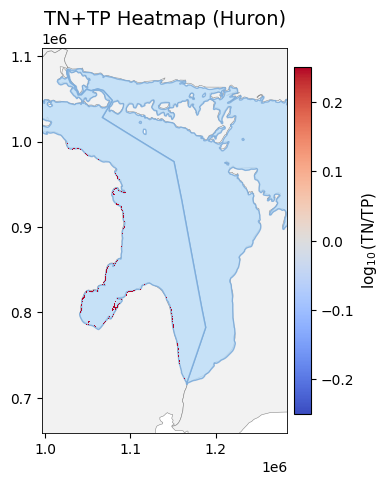

In [60]:
plot_TN_over_TP_heatmap(
    cat="high",
    Lakes=Huron,
    Counties=counties,
    title="TN+TP Heatmap (Huron)",
    extent=[-84.5, -81.0, 42.5, 46.5],
    cell_size_m=1000,
    metric="ratio",
    agg="mean",
    min_points_per_cell=3,
    min_mass=1e-6,
    smoothing_sigma_cells=0.0,          # keep features crisp
    display_interpolation='nearest',
    center_span=0.25,                    # tight diverging scale around 0
    highlight_tp=True,
    tp_threshold=0.02,                   # outline where TN/TP < ~0.95
    outline_color="#1f77b4",
    outline_lw=0.9,
    dpi_out=500,
    year=year
)


In [58]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

def debug_ratio_points(cat, extent=[-84.5,-81,42.5,46.5], eps=1e-12):
    df = globals()[f"TotalLoad_CW_{cat}"].copy()
    tn = df[f"TotalN_{cat}_grm2yr"].astype(float).values
    tp = df[f"TotalP_{cat}_grm2yr"].astype(float).values

    # basic stats
    ratio_log = np.log10((tn + eps) / (tp + eps))
    print("TN stats:", np.nanmin(tn), np.nanmedian(tn), np.nanmax(tn))
    print("TP stats:", np.nanmin(tp), np.nanmedian(tp), np.nanmax(tp))
    print("log10(TN/TP) stats:", np.nanmin(ratio_log), np.nanmedian(ratio_log), np.nanmax(ratio_log))
    print("fraction TN/TP < 1 (i.e., log10<0):", np.mean(ratio_log < 0))

    # show a few most P-dominant (smallest ratios)
    idx = np.argsort(ratio_log)[:10]
    print(df.iloc[idx][["start_lon","start_lat", f"TotalN_{cat}_grm2yr", f"TotalP_{cat}_grm2yr"]])

    # quick point map to visually confirm sign
    pts = gpd.GeoDataFrame(
        df[(df['start_lon']!=0)&(df['start_lat']!=0)],
        geometry=gpd.points_from_xy(df['start_lon'], df['start_lat']),
        crs="EPSG:4326"
    )
    minlon,maxlon,minlat,maxlat = extent
    pts = pts.cx[minlon:maxlon, minlat:maxlat]
    val = np.log10((pts[f"TotalN_{cat}_grm2yr"].astype(float)+eps) /
                   (pts[f"TotalP_{cat}_grm2yr"].astype(float)+eps))
    v = val[np.isfinite(val)]
    lo, hi = np.nanpercentile(v, 5), np.nanpercentile(v, 95)

    # ensure diverging centered at 0, even if all on one side
    if not (lo < 0 < hi):
        span = max(abs(lo), abs(hi))
        lo, hi = -span, span

    fig, ax = plt.subplots(figsize=(4.5, 5))
    pts.plot(ax=ax, color=plt.cm.coolwarm(TwoSlopeNorm(0, lo, hi)(val)), markersize=6, linewidth=0)
    ax.set_title("Points colored by log10(TN/TP)")
    ax.set_xlim(minlon, maxlon); ax.set_ylim(minlat, maxlat)
    plt.show()

debug_ratio_points("avg")


TN stats: 0.0112873159989814 169.7594487499947 1012221.8816864918
TP stats: 0.0001739402964047 4.106145449771244 34341.693983656536
log10(TN/TP) stats: -0.3027300408304396 1.6383370476206591 2.8183996375189215
fraction TN/TP < 1 (i.e., log10<0): 0.0002353494939985879
     start_lon  start_lat  TotalN_avg_grm2yr  TotalP_avg_grm2yr
976        0.0        0.0          17.367158          34.870551
332        0.0        0.0           0.615500           0.400712
943        0.0        0.0           0.675749           0.238921
514        0.0        0.0       10573.757812        3340.967876
557        0.0        0.0           0.207677           0.035907
734        0.0        0.0           5.868939           0.996184
530        0.0        0.0           0.123006           0.017382
790        0.0        0.0           1.029962           0.126119
53         0.0        0.0           1.089498           0.126251
393        0.0        0.0           0.032308           0.003741


ValueError: Length of values (4249) does not match length of index (1392)

### wetlands geographic location 

In [ ]:
GL_ALBERS = "EPSG:3175"   # NAD83 / Great Lakes Albers Equal Area
from shapely.geometry import box
def _to_3175(gdf: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    if gdf is None:
        return None
    if gdf.crs is None:
        # If your Lakes layer has a known CRS, set it before calling this function.
        raise ValueError("Lakes GeoDataFrame has no CRS. Set gdf.crs before plotting.")
    return gdf.to_crs(GL_ALBERS)

def _project_extent_4326_to_3175(extent_ll):
    """extent_ll = [minx, maxx, miny, maxy] in EPSG:4326 → returns [minx, maxx, miny, maxy] in EPSG:3175"""
    minx, maxx, miny, maxy = extent_ll
    bbox_ll = gpd.GeoSeries([box(minx, miny, maxx, maxy)], crs="EPSG:4326")
    bbox_pr = bbox_ll.to_crs(GL_ALBERS).total_bounds
    # total_bounds → (minx, miny, maxx, maxy); reorder to match our [minx, maxx, miny, maxy]
    return [bbox_pr[0], bbox_pr[2], bbox_pr[1], bbox_pr[3]]

def plot_wetload_distribution(
    cat,
    Lakes: gpd.GeoDataFrame,
    font_size=16,
    title=None,
    output_figures='.',
    extent=[-85, -81, 42.5, 46.5]  # lon/lat input extent (EPSG:4326)
):
    # Get dataframe from globals
    df = globals().get(f'TotalLoad_CW_{cat}')
    if df is None:
        raise ValueError(f"No dataframe found for category '{cat}'")

    # Clean invalid coordinates
    df = df[
        (df['start_lon'] != 0.0) &
        (df['start_lat'] != 0.0) &
        (~df['start_lon'].isna()) &
        (~df['start_lat'].isna())
    ].copy()

    if 'Wetland' not in df.columns:
        raise ValueError("Column 'Wetland' not found in dataframe")

    # Clip to input lon/lat extent (EPSG:4326)
    minx_ll, maxx_ll, miny_ll, maxy_ll = extent
    df = df[
        (df['start_lon'] >= minx_ll) & (df['start_lon'] <= maxx_ll) &
        (df['start_lat'] >= miny_ll) & (df['start_lat'] <= maxy_ll)
    ].copy()
    if df.empty:
        raise ValueError("No points remain after filtering by input extent.")

    # Build points GeoDataFrame in 4326 and project to Great Lakes Albers
    pts_4326 = gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df['start_lon'], df['start_lat']),
        crs="EPSG:4326"
    )
    pts_3175 = pts_4326.to_crs(GL_ALBERS)

    # Reproject Lakes
    Lakes_3175 = _to_3175(Lakes)

    # Compute projected plot extent from lon/lat box
    minx_pr, maxx_pr, miny_pr, maxy_pr = _project_extent_4326_to_3175(extent)

    # Unique wetland categories and 8-color map
    cats = sorted([c for c in pts_3175['Wetland'].dropna().unique()])
    cmap = plt.get_cmap("Set2", 8)  # exactly 8 distinct colors
    color_map = {c: cmap(i % 8) for i, c in enumerate(cats)}

    # --- Plot in EPSG:3175 coordinates (meters) ---
    fig, ax = plt.subplots(figsize=(18, 10))

    # Lakes first
    if Lakes_3175 is not None and not Lakes_3175.empty:
        Lakes_3175.plot(ax=ax, facecolor='lightblue', edgecolor='black', alpha=0.5, linewidth=0.8, zorder=0)

    # Points by category (bigger symbols)
    for c in cats:
        sub = pts_3175[pts_3175['Wetland'] == c]
        ax.scatter(
            sub.geometry.x, sub.geometry.y,
            s=60, alpha=0.9, label=f"{c} (n={len(sub)})",
            color=color_map[c], edgecolor="k", linewidth=0.3, zorder=1
        )

    # Labels and layout
    ax.set_title(title or f"Wetland Categories - {cat}", fontsize=font_size + 2)
    ax.set_xlabel("Easting (m, EPSG:3175)", fontsize=font_size)
    ax.set_ylabel("Northing (m, EPSG:3175)", fontsize=font_size)
    ax.tick_params(labelsize=font_size - 2)
    ax.set_xlim(minx_pr, maxx_pr)
    ax.set_ylim(miny_pr, maxy_pr)
    ax.set_aspect('equal')

    # Legend outside
    ax.legend(title="Wetland", bbox_to_anchor=(1.02, 1), loc='upper left',
              borderaxespad=0., fontsize=font_size-3)

    # Save
    os.makedirs(output_figures, exist_ok=True)
    outpath = f"{output_figures}/WetlandCats_{cat}_GLAlbers.png"
    plt.savefig(outpath, dpi=300, bbox_inches='tight')
    print(f"✅ Saved: {outpath}")
    plt.show()

In [ ]:
import os
import geopandas as gpd
import matplotlib.pyplot as plt

GL_ALBERS = TARGET_CRS   # NAD83 / Great Lakes Albers Equal Area
from shapely.geometry import box

def _to_3175(gdf: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    if gdf is None:
        return None
    if gdf.crs is None:
        raise ValueError("Lakes GeoDataFrame has no CRS. Set gdf.crs before plotting.")
    return gdf.to_crs(GL_ALBERS)

def _project_extent_4326_to_3175(extent_ll):
    """extent_ll = [minx, maxx, miny, maxy] in EPSG:4326 → returns [minx, maxx, miny, maxy] in EPSG:3175"""
    minx, maxx, miny, maxy = extent_ll
    bbox_ll = gpd.GeoSeries([box(minx, miny, maxx, maxy)], crs="EPSG:4326")
    bbox_pr = bbox_ll.to_crs(GL_ALBERS).total_bounds
    # total_bounds → (minx, miny, maxx, maxy); reorder to [minx, maxx, miny, maxy]
    return [bbox_pr[0], bbox_pr[2], bbox_pr[1], bbox_pr[3]]

def plot_wetload_distribution(
    cat,
    Lakes: gpd.GeoDataFrame,
    font_size=10,
    title=None,
    output_figures='.',
    extent=[-84, -81, 42.8, 46.5],  # lon/lat input extent (EPSG:4326)
    allowed_wetlands=("Typha", "Phragmites"),   # <<< filter here
):
    # Get dataframe from globals
    df = globals().get(f'TotalLoad_CW_{cat}')
    if df is None:
        raise ValueError(f"No dataframe found for category '{cat}'")

    # Clean invalid coordinates
    df = df[
        (df['start_lon'] != 0.0) &
        (df['start_lat'] != 0.0) &
        (~df['start_lon'].isna()) &
        (~df['start_lat'].isna())
    ].copy()

    if 'Wetland' not in df.columns:
        raise ValueError("Column 'Wetland' not found in dataframe")

    # Keep only Typha and Phragmites (case-insensitive, trims whitespace)
    allowed_norm = {a.strip().casefold() for a in allowed_wetlands}
    df['Wetland_norm'] = df['Wetland'].astype(str).str.strip().str.casefold()
    df = df[df['Wetland_norm'].isin(allowed_norm)].copy()

    # Optional: collapse any variants like "Phragmites australis" (contains match)
    # Uncomment this block if you need fuzzy matching instead of exact:
    # df['Wetland_norm'] = (
    #     df['Wetland'].astype(str).str.strip().str.casefold()
    #         .replace({r'.*\bphragmites\b.*': 'phragmites',
    #                   r'.*\btypha\b.*': 'typha'}, regex=True)
    # )
    # df = df[df['Wetland_norm'].isin({'phragmites','typha'})].copy()

    if df.empty:
        raise ValueError("No Typha or Phragmites points remain after filtering.")

    # Clip to input lon/lat extent (EPSG:4326)
    minx_ll, maxx_ll, miny_ll, maxy_ll = extent
    df = df[
        (df['start_lon'] >= minx_ll) & (df['start_lon'] <= maxx_ll) &
        (df['start_lat'] >= miny_ll) & (df['start_lat'] <= maxy_ll)
    ].copy()
    if df.empty:
        raise ValueError("No points remain after filtering by input extent.")

    # Build points GeoDataFrame in 4326 and project to Great Lakes Albers
    pts_4326 = gpd.GeoDataFrame(
        df.drop(columns=['Wetland_norm']),
        geometry=gpd.points_from_xy(df['start_lon'], df['start_lat']),
        crs="EPSG:4326"
    )
    pts_3175 = pts_4326.to_crs(GL_ALBERS)

    # Reproject Lakes
    Lakes_3175 = _to_3175(Lakes)

    # Compute projected plot extent from lon/lat box
    minx_pr, maxx_pr, miny_pr, maxy_pr = _project_extent_4326_to_3175(extent)

    # Only the two categories, ordered and with fixed colors
    # (adjust colors as you like)
    display_order = []
    color_map = {}
    # Build mapping from normalized → display label
    label_map = {}
    for a in allowed_wetlands:
        key = a.strip().casefold()
        label_map[key] = a.strip()

    # Choose colors (green for Typha, purple for Phragmites; tweak as needed)
    fixed_colors = {
        'typha': "#ce370e",
        'phragmites': '#7570b3',
    }
    present_norms = (
        pts_3175['Wetland'].astype(str).str.strip().str.casefold().unique().tolist()
    )
    for key in ['typha', 'phragmites']:
        if key in present_norms:
            display_order.append(key)
            color_map[key] = fixed_colors[key]

    if not display_order:
        raise ValueError("No Typha or Phragmites categories found to plot.")

    # --- Plot in EPSG:3175 coordinates (meters) ---
    fig, ax = plt.subplots(figsize=single_size)

    # Lakes first
    if Lakes_3175 is not None and not Lakes_3175.empty:
        Lakes_3175.plot(ax=ax, facecolor='gray', edgecolor='black',
                        alpha=0.5, linewidth=0.8, zorder=0)

    # Points by the two categories
    # Recreate a normalized column for plotting
    pts_3175['_wet_norm'] = pts_3175['Wetland'].astype(str).str.strip().str.casefold()

    for key in display_order:
        sub = pts_3175[pts_3175['_wet_norm'] == key]
        label = label_map.get(key, key.title())
        ax.scatter(
            sub.geometry.x, sub.geometry.y,
            s=40, alpha=0.9, label=f"{label} (n={len(sub)})",
            color=color_map[key], edgecolor="k", linewidth=0.3, zorder=1
        )

    # Labels and layout
    # ttl = title or f"Wetland Categories (Typha & Phragmites) - {cat}"
    # ax.set_title(ttl, fontsize=font_size + 2)
    #ax.set_xlabel("Easting (m, EPSG:3175)", fontsize=font_size)
    #ax.set_ylabel("Northing (m, EPSG:3175)", fontsize=font_size)
    #ax.tick_params(labelsize=font_size - 2)
    ax.set_xlim(minx_pr, maxx_pr)
    ax.set_ylim(miny_pr, maxy_pr)
    ax.set_aspect('equal')

    # Legend outside
    plt.axis('off')
    ax.legend(title="Wetland", bbox_to_anchor=(1.02, 1), loc='upper left',
              borderaxespad=0., fontsize=font_size-3)

    # Save
    os.makedirs(output_figures, exist_ok=True)
    outpath = f"{output_figures}/WetlandCats_{cat}_TyphaPhrag_GLAlbers.png"
    plt.savefig(outpath, dpi=300, bbox_inches='tight')
    print(f"✅ Saved: {outpath}")
    plt.show()


In [ ]:
for cat in ['avg']:
    plot_wetload_distribution(
        cat=cat,
        Lakes=Lakes,
        output_figures=output_figures,
        #title=f"Wetland Categories - {cat}"
    )

### TN and TP load for different inundatiotion 

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

def plot_total_load_boxplot(
    nutrient="P",                      # 'P' or 'N'
    categories=("avg","high","low","surge"),
    out_dir_fig=".",
    year=23,
    order=("avg","high","low","surge")  # display order on x-axis
):
    assert nutrient in ("P","N"), "nutrient must be 'P' or 'N'"

    rows = []
    for cat in categories:
        df = globals().get(f"TotalLoad_CW_{cat}")
        if df is None:
            raise KeyError(f"Missing DataFrame: TotalLoad_CW_{cat}")
        col = f"Total{nutrient}_{cat}_grm2yr"
        if col not in df.columns:
            raise KeyError(f"Missing column '{col}' in TotalLoad_CW_{cat}")
        s = pd.to_numeric(df[col], errors="coerce")
        s = s.replace([np.inf, -np.inf], np.nan).dropna()
        s = s[s > 0]  # log-safe
        rows.append(pd.DataFrame({"Category": cat, "TotalLoad": s.values}))

    long_df = pd.concat(rows, ignore_index=True)
    long_df["log10_TotalLoad"] = np.log10(long_df["TotalLoad"])

    plt.figure(figsize=(8, 6))
    sns.boxplot(
        data=long_df,
        x="Category",
        y="log10_TotalLoad",
        hue="Category",
        order=list(order),
        palette=("Oranges" if nutrient == "P" else "Blues"),
        legend=False
    )

    plt.title(
        f"Boxplot of Total {'Phosphorus' if nutrient=='P' else 'Nitrogen'} Load to Coastal Wetlands (log₁₀ g/m²/yr)"
    )
    plt.ylabel("log₁₀(Total load) [g/m²/yr]")
    plt.xlabel("Wetland Category")
    plt.tight_layout()

    fname = f"Boxplot_Total{nutrient}_log10_{year}.png"
    plt.savefig(os.path.join(out_dir_fig, fname), dpi=300)
    plt.show()
    print(f"✅ Saved: {os.path.join(out_dir_fig, fname)}")


In [ ]:
plot_total_load_boxplot("P", categories=categories, out_dir_fig=output_figures, year=year)



In [ ]:
plot_total_load_boxplot("N", categories=categories, out_dir_fig=output_figures, year=year)
